In [1]:
!pip install torch
!pip install torchvision
!pip install torchmetrics
!pip install opencv-python

!lscpu |grep 'Model name'
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Fri May 26 13:46:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                          

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import sys
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Grayscale, ToPILImage, ToTensor, Normalize, CenterCrop

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

from sklearn.model_selection import train_test_split

# Directorios

In [2]:
dataset_path = './datasets/covid-19-radiography-dataset.csv'
unfiltered_images_path = './datasets/unfiltered_images'
feature_extracted_images_path = './datasets/feature_extracted_images'
bilateral_filtered_images_path = './datasets/bilateral_filtered_images'

# Extracción de features

In [ ]:
if (not os.path.exists(feature_extracted_images_path)):
    os.mkdir(feature_extracted_images_path)

index = 0
for file_name in os.listdir(unfiltered_images_path):
    original_image_path = os.path.join(unfiltered_images_path, file_name)
    feature_extracted_image_path = os.path.join(feature_extracted_images_path, file_name)

    print(index+1)

    if (os.path.exists(feature_extracted_image_path)):
      index+=1
      continue

    img = cv2.imread(original_image_path)

    orb = cv2.ORB_create()
    kp = orb.detect(img, None)

    kp, des = orb.compute(img, kp)

    img2 = cv2.drawKeypoints(img, kp, None, color=(255, 255, 255), flags=0)

    cv2.imwrite(feature_extracted_image_path, img2)
    index+=1

# Bilateral Filter

In [6]:
if (not os.path.exists(bilateral_filtered_images_path)):
    os.mkdir(bilateral_filtered_images_path)

index = 0
for file_name in os.listdir(unfiltered_images_path):
    original_image_path = os.path.join(unfiltered_images_path, file_name)
    filtered_image_path = os.path.join(bilateral_filtered_images_path, file_name)

    print(index+1)

    if (os.path.exists(filtered_image_path)):
      index+=1
      continue

    img = cv2.imread(original_image_path)

    bilateral_filtered_image = cv2.bilateralFilter(img, 5, 75, 75)

    cv2.imwrite(filtered_image_path, bilateral_filtered_image)
    index+=1

Streaming output truncated to the last 5000 lines.
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283
16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
1

# Carga del set de datos

## Clase para el set de datos

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, file_names, labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = labels
        self.file_names = file_names
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_names.iloc[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.head()

,file_name,label
0,COVID-1.png,0
1,COVID-10.png,0
2,COVID-100.png,0
3,COVID-1000.png,0
4,COVID-1001.png,0


## Distribución de las clases en el set de datos

In [5]:
class_ids = {
    0: 'covid',
    1: 'lung_opacity',
    2: 'normal',
    3: 'viral_pneumonia'
}

def count_dataset_classes(labels, class_ids):
    class_count = {
        'covid': 0,
        'lung_opacity': 0,
        'normal': 0,
        'viral_pneumonia': 0
    }
    
    for label in labels:
        class_id = class_ids[label]
        class_count[class_id] += 1
    
    return class_count

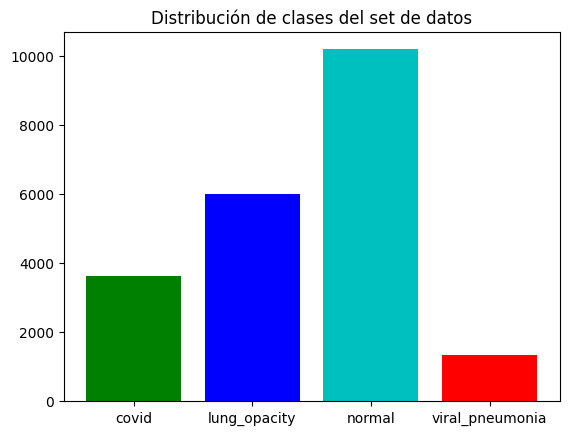

In [6]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)

fig, ax = plt.subplots()
ax.set_title('Distribución de clases del set de datos')
ax.bar(list(dataset_class_count.keys()), list(dataset_class_count.values()), color=['g', 'b', 'c', 'r'])

plt.show()

## División del set de datos

Train set distribution:  {'covid': 2893, 'lung_opacity': 4809, 'normal': 8154, 'viral_pneumonia': 1076}
Test set distribution:  {'covid': 723, 'lung_opacity': 1203, 'normal': 2038, 'viral_pneumonia': 269}
Test vs Train distribution:  {'covid': 0.19994469026548672, 'lung_opacity': 0.2000998003992016, 'normal': 0.1999607535321821, 'viral_pneumonia': 0.2}


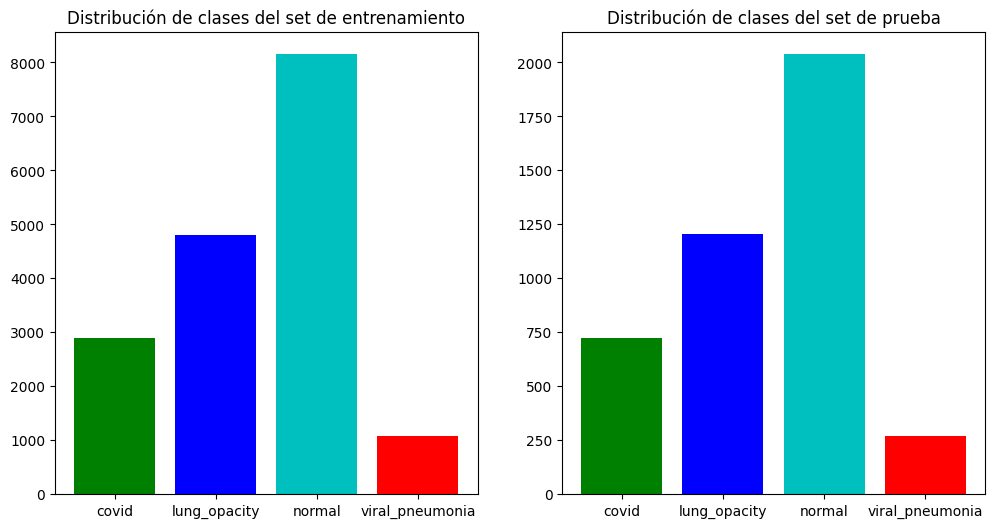

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_file_names, dataset_labels, test_size=0.2, random_state=404, stratify=dataset_labels)

train_class_count = count_dataset_classes(y_train, class_ids)
test_class_count = count_dataset_classes(y_test, class_ids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Distribución de clases del set de entrenamiento')
ax[0].bar(list(train_class_count.keys()), list(train_class_count.values()), color=['g', 'b', 'c', 'r'])

ax[1].set_title('Distribución de clases del set de prueba')
ax[1].bar(list(test_class_count.keys()), list(test_class_count.values()), color=['g', 'b', 'c', 'r'])

print('Train set distribution: ', train_class_count)
print('Test set distribution: ', test_class_count)
print('Test vs Train distribution: ', {k: test_class_count[k] / (dataset_class_count[k]) for k in test_class_count})
plt.show()

## Feature Engineering

In [8]:
unfiltered_train_dataset = CustomDataset(unfiltered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

unfiltered_test_dataset = CustomDataset(unfiltered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

In [9]:
feature_extracted_train_dataset = CustomDataset(feature_extracted_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

feature_extracted_test_dataset = CustomDataset(feature_extracted_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

In [10]:
bilateral_filtered_train_dataset = CustomDataset(bilateral_filtered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

bilateral_filtered_test_dataset = CustomDataset(bilateral_filtered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

# Uso de GPU si está disponible

In [11]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# Métricas de evaluación

## Definición de métricas

In [12]:
train_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)
test_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)

train_precision = MulticlassPrecision(num_classes=4, average=None).to(device)
test_precision = MulticlassPrecision(num_classes=4, average=None).to(device)

train_recall = MulticlassRecall(num_classes=4, average=None).to(device)
test_recall = MulticlassRecall(num_classes=4, average=None).to(device)

train_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)
test_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)

train_roc = MulticlassROC(num_classes=4).to(device)
test_roc = MulticlassROC(num_classes=4).to(device)

train_auroc = MulticlassAUROC(num_classes=4).to(device)
test_auroc = MulticlassAUROC(num_classes=4).to(device)

## Cálculo de métricas

In [13]:
def compute_metrics(train_list, test_list, train_loss, test_loss):
    train_list.append({'loss': train_loss,
                       'accuracy': train_accuracy.compute(),
                       'precision': train_precision.compute(), 
                       'recall': train_recall.compute(),
                       'f1': train_f1.compute(),
                       'roc': train_roc.compute(),
                       'auroc': train_auroc.compute()})
    
    test_list.append({'loss': test_loss,
                      'accuracy': test_accuracy.compute(),
                      'precision': test_precision.compute(),
                      'recall': test_recall.compute(),
                      'f1': test_f1.compute(),
                      'roc': test_roc.compute(),
                      'auroc': test_auroc.compute()})
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

## Tablas de las métricas

In [14]:
def show_accuracy_table(train_accuracies, test_accuracies, epochs):
    accuracy_df = pd.DataFrame({
        'Covid Train Accuracy': [train_accuracies[i][0].item() for i in range(epochs)],
        'Covid Test Accuracy': [test_accuracies[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Accuracy': [train_accuracies[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Accuracy': [test_accuracies[i][1].item() for i in range(epochs)],
        
        'Normal Train Accuracy': [train_accuracies[i][2].item() for i in range(epochs)],
        'Normal Test Accuracy': [test_accuracies[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Accuracy': [train_accuracies[i][3].item() for i in range(epochs)],
        'Pneumonia Test Accuracy': [test_accuracies[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    accuracy_df.index.name = 'Epoch'
    display(accuracy_df)

In [15]:
def show_precision_table(train_precisions, test_precisions, epochs):
    precision_df = pd.DataFrame({
        'Covid Train Precision': [train_precisions[i][0].item() for i in range(epochs)],
        'Covid Test Precision': [test_precisions[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Precision': [train_precisions[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Precision': [test_precisions[i][1].item() for i in range(epochs)],
        
        'Normal Train Precision': [train_precisions[i][2].item() for i in range(epochs)],
        'Normal Test Precision': [test_precisions[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Precision': [train_precisions[i][3].item() for i in range(epochs)],
        'Pneumonia Test Precision': [test_precisions[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    precision_df.index.name = 'Epoch'
    display(precision_df)

In [16]:
def show_recall_table(train_recalls, test_recalls, epochs):
    recall_df = pd.DataFrame({
        'Covid Train Recall': [train_recalls[i][0].item() for i in range(epochs)],
        'Covid Test Recall': [test_recalls[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Recall': [train_recalls[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Recall': [test_recalls[i][1].item() for i in range(epochs)],
        
        'Normal Train Recall': [train_recalls[i][2].item() for i in range(epochs)],
        'Normal Test Recall': [test_recalls[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Recall': [train_recalls[i][3].item() for i in range(epochs)],
        'Pneumonia Test Recall': [test_recalls[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    recall_df.index.name = 'Epoch'
    display(recall_df)

In [17]:
def show_f1_score_table(train_f1_scores, test_f1_scores, epochs):
    f1_score_df = pd.DataFrame({
        'Covid Train F1-Score': [train_f1_scores[i][0].item() for i in range(epochs)],
        'Covid Test F1-Score': [test_f1_scores[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train F1-Score': [train_f1_scores[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test F1-Score': [test_f1_scores[i][1].item() for i in range(epochs)],
        
        'Normal Train F1-Score': [train_f1_scores[i][2].item() for i in range(epochs)],
        'Normal Test F1-Score': [test_f1_scores[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train F1-Score': [train_f1_scores[i][3].item() for i in range(epochs)],
        'Pneumonia Test F1-Score': [test_f1_scores[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])
    
    f1_score_df.index.name = 'Epoch'
    display(f1_score_df) 

In [18]:
def show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].set_title('ROC Curve for Covid')
    ax[0, 0].set_ylabel('TPR')
    ax[0, 0].set_xlabel('FPR')

    ax[0, 1].set_title('ROC Curve for Lung Opacity')
    ax[0, 1].set_ylabel('TPR')
    ax[0, 1].set_xlabel('FPR')

    ax[1, 0].set_title('ROC Curve for Normal')
    ax[1, 0].set_ylabel('TPR')
    ax[1, 0].set_xlabel('FPR')

    ax[1, 1].set_title('ROC Curve for Pneumonia')
    ax[1, 1].set_ylabel('TPR')
    ax[1, 1].set_xlabel('FPR')

    ax[0, 0].plot(Tensor.cpu(train_roc_fpr[0]), Tensor.cpu(train_roc_tpr[0]), label='Train', color='b')
    ax[0, 0].plot(Tensor.cpu(test_roc_fpr[0]), Tensor.cpu(test_roc_tpr[0]), label='Test', color='g')

    ax[0, 1].plot(Tensor.cpu(train_roc_fpr[1]), Tensor.cpu(train_roc_tpr[1]), label='Train', color='b')
    ax[0, 1].plot(Tensor.cpu(test_roc_fpr[1]), Tensor.cpu(test_roc_tpr[1]), label='Test', color='g')

    ax[1, 0].plot(Tensor.cpu(train_roc_fpr[2]), Tensor.cpu(train_roc_tpr[2]), label='Train', color='b')
    ax[1, 0].plot(Tensor.cpu(test_roc_fpr[2]), Tensor.cpu(test_roc_tpr[2]), label='Test', color='g')

    ax[1, 1].plot(Tensor.cpu(train_roc_fpr[3]), Tensor.cpu(train_roc_tpr[3]), label='Train', color='b')
    ax[1, 1].plot(Tensor.cpu(test_roc_fpr[3]), Tensor.cpu(test_roc_tpr[3]), label='Test', color='g')

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()
    ax[1, 1].legend()
    fig.show()

In [19]:
def show_learning_curve(train_losses, test_losses, epoch_list):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss vs Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(epoch_list)

    ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
    ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

    ax.legend()
    fig.show()

# Función de entrenamiento

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    loss = torch.Tensor([0]).to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        
        train_accuracy.update(pred, y)
        train_precision.update(pred, y)
        train_recall.update(pred, y)
        train_f1.update(pred, y)    
        train_roc.update(pred, y)
        train_auroc.update(pred, y)
        
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return loss.item()

# Función de evaluación

In [21]:
def test(dataloader, model, loss_fn):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            test_accuracy.update(pred, y)
            test_precision.update(pred, y)
            test_recall.update(pred, y)
            test_f1.update(pred, y)    
            test_roc.update(pred, y)
            test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    accuracy_df = pd.DataFrame({
        'Covid Test Accuracy': [test_accuracy.compute()[0].item()],
        'Lung-Opacity Test Accuracy': [test_accuracy.compute()[1].item()],
        'Normal Test Accuracy': [test_accuracy.compute()[2].item()],
        'Pneumonia Test Accuracy': [test_accuracy.compute()[3].item()]
    })
    display(accuracy_df)
    return test_loss

# Modelo 1 - MLP básica
## Sin Feature Extractor

## Arquitectura del modelo

In [ ]:
class MLP_basic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_basic, self).__init__()
        # Capa de entrada
        self.fc1 = nn.Linear(input_size, hidden_size) 
        # Capa de salida 
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Función de activación ReLU en la capa oculta
        x = torch.relu(self.fc1(x))  
        # Sin función de activación en la capa de salida
        x = self.fc2(x)  
        return x

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
epochs = 15

unfiltered_basic_mlp_model = MLP_basic(250*250, 128, 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_basic_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_basic_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_basic_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.401151  [   32/16932]
Current Loss: 1.364301  [  352/16932]
Current Loss: 1.316510  [  672/16932]
Current Loss: 1.285605  [  992/16932]
Current Loss: 1.204236  [ 1312/16932]
Current Loss: 1.162680  [ 1632/16932]
Current Loss: 1.134155  [ 1952/16932]
Current Loss: 1.140960  [ 2272/16932]
Current Loss: 1.239731  [ 2592/16932]
Current Loss: 1.113698  [ 2912/16932]
Current Loss: 1.068023  [ 3232/16932]
Current Loss: 1.037620  [ 3552/16932]
Current Loss: 1.011539  [ 3872/16932]
Current Loss: 1.188659  [ 4192/16932]
Current Loss: 0.950344  [ 4512/16932]
Current Loss: 1.137512  [ 4832/16932]
Current Loss: 0.945718  [ 5152/16932]
Current Loss: 0.939196  [ 5472/16932]
Current Loss: 0.923109  [ 5792/16932]
Current Loss: 0.947975  [ 6112/16932]
Current Loss: 0.953155  [ 6432/16932]
Current Loss: 0.943702  [ 6752/16932]
Current Loss: 0.930089  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.067773,0.624273,0.906771,0.30855


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.141592  [   32/16932]
Current Loss: 0.761529  [  352/16932]
Current Loss: 0.965780  [  672/16932]
Current Loss: 1.014742  [  992/16932]
Current Loss: 0.699902  [ 1312/16932]
Current Loss: 0.872144  [ 1632/16932]
Current Loss: 0.848044  [ 1952/16932]
Current Loss: 1.103961  [ 2272/16932]
Current Loss: 0.979200  [ 2592/16932]
Current Loss: 0.893097  [ 2912/16932]
Current Loss: 0.832110  [ 3232/16932]
Current Loss: 1.065279  [ 3552/16932]
Current Loss: 0.885472  [ 3872/16932]
Current Loss: 0.925020  [ 4192/16932]
Current Loss: 1.092968  [ 4512/16932]
Current Loss: 0.756318  [ 4832/16932]
Current Loss: 0.829798  [ 5152/16932]
Current Loss: 0.703591  [ 5472/16932]
Current Loss: 0.928147  [ 5792/16932]
Current Loss: 0.592609  [ 6112/16932]
Current Loss: 0.843154  [ 6432/16932]
Current Loss: 0.965932  [ 6752/16932]
Current Loss: 1.041770  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.130014,0.612635,0.887144,0.583643


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.088743  [   32/16932]
Current Loss: 1.034511  [  352/16932]
Current Loss: 0.708324  [  672/16932]
Current Loss: 0.724511  [  992/16932]
Current Loss: 0.814004  [ 1312/16932]
Current Loss: 0.899136  [ 1632/16932]
Current Loss: 0.783343  [ 1952/16932]
Current Loss: 0.754249  [ 2272/16932]
Current Loss: 0.825645  [ 2592/16932]
Current Loss: 0.806608  [ 2912/16932]
Current Loss: 0.948985  [ 3232/16932]
Current Loss: 0.876388  [ 3552/16932]
Current Loss: 0.843673  [ 3872/16932]
Current Loss: 0.885535  [ 4192/16932]
Current Loss: 0.922814  [ 4512/16932]
Current Loss: 0.862445  [ 4832/16932]
Current Loss: 0.771319  [ 5152/16932]
Current Loss: 0.836114  [ 5472/16932]
Current Loss: 0.852872  [ 5792/16932]
Current Loss: 0.909144  [ 6112/16932]
Current Loss: 0.919169  [ 6432/16932]
Current Loss: 0.911617  [ 6752/16932]
Current Loss: 0.795554  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.106501,0.632585,0.89107,0.643123


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.943565  [   32/16932]
Current Loss: 0.754649  [  352/16932]
Current Loss: 0.897996  [  672/16932]
Current Loss: 0.760338  [  992/16932]
Current Loss: 0.663478  [ 1312/16932]
Current Loss: 0.680341  [ 1632/16932]
Current Loss: 0.831140  [ 1952/16932]
Current Loss: 0.937525  [ 2272/16932]
Current Loss: 0.612725  [ 2592/16932]
Current Loss: 0.889560  [ 2912/16932]
Current Loss: 0.843271  [ 3232/16932]
Current Loss: 0.978474  [ 3552/16932]
Current Loss: 0.777386  [ 3872/16932]
Current Loss: 0.811525  [ 4192/16932]
Current Loss: 0.724912  [ 4512/16932]
Current Loss: 0.893700  [ 4832/16932]
Current Loss: 0.714195  [ 5152/16932]
Current Loss: 0.813231  [ 5472/16932]
Current Loss: 0.988915  [ 5792/16932]
Current Loss: 0.706405  [ 6112/16932]
Current Loss: 0.776351  [ 6432/16932]
Current Loss: 0.702754  [ 6752/16932]
Current Loss: 0.753603  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.149378,0.639235,0.879293,0.680297


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.780037  [   32/16932]
Current Loss: 1.012008  [  352/16932]
Current Loss: 0.787338  [  672/16932]
Current Loss: 0.809977  [  992/16932]
Current Loss: 0.739268  [ 1312/16932]
Current Loss: 0.740124  [ 1632/16932]
Current Loss: 0.669281  [ 1952/16932]
Current Loss: 0.811013  [ 2272/16932]
Current Loss: 0.680514  [ 2592/16932]
Current Loss: 0.826201  [ 2912/16932]
Current Loss: 0.679699  [ 3232/16932]
Current Loss: 0.832603  [ 3552/16932]
Current Loss: 0.979110  [ 3872/16932]
Current Loss: 0.855290  [ 4192/16932]
Current Loss: 0.947634  [ 4512/16932]
Current Loss: 0.980222  [ 4832/16932]
Current Loss: 0.785765  [ 5152/16932]
Current Loss: 0.968423  [ 5472/16932]
Current Loss: 0.813853  [ 5792/16932]
Current Loss: 0.826185  [ 6112/16932]
Current Loss: 0.816369  [ 6432/16932]
Current Loss: 0.748507  [ 6752/16932]
Current Loss: 1.053249  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.114799,0.655029,0.886654,0.698885


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.753180  [   32/16932]
Current Loss: 0.704992  [  352/16932]
Current Loss: 0.846700  [  672/16932]
Current Loss: 0.904368  [  992/16932]
Current Loss: 0.860574  [ 1312/16932]
Current Loss: 0.786396  [ 1632/16932]
Current Loss: 0.660737  [ 1952/16932]
Current Loss: 0.882336  [ 2272/16932]
Current Loss: 0.674081  [ 2592/16932]
Current Loss: 0.755078  [ 2912/16932]
Current Loss: 0.683450  [ 3232/16932]
Current Loss: 0.937834  [ 3552/16932]
Current Loss: 0.811164  [ 3872/16932]
Current Loss: 0.703426  [ 4192/16932]
Current Loss: 0.874554  [ 4512/16932]
Current Loss: 0.991595  [ 4832/16932]
Current Loss: 0.749847  [ 5152/16932]
Current Loss: 0.894911  [ 5472/16932]
Current Loss: 0.508696  [ 5792/16932]
Current Loss: 0.856276  [ 6112/16932]
Current Loss: 0.690790  [ 6432/16932]
Current Loss: 0.814063  [ 6752/16932]
Current Loss: 0.661663  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.147994,0.679136,0.875859,0.702602


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.706681  [   32/16932]
Current Loss: 0.806683  [  352/16932]
Current Loss: 0.768119  [  672/16932]
Current Loss: 0.578037  [  992/16932]
Current Loss: 0.778739  [ 1312/16932]
Current Loss: 0.799706  [ 1632/16932]
Current Loss: 0.494093  [ 1952/16932]
Current Loss: 0.699363  [ 2272/16932]
Current Loss: 0.610872  [ 2592/16932]
Current Loss: 0.736988  [ 2912/16932]
Current Loss: 0.731123  [ 3232/16932]
Current Loss: 0.915115  [ 3552/16932]
Current Loss: 0.739684  [ 3872/16932]
Current Loss: 0.822330  [ 4192/16932]
Current Loss: 0.759000  [ 4512/16932]
Current Loss: 0.930162  [ 4832/16932]
Current Loss: 0.749289  [ 5152/16932]
Current Loss: 0.578354  [ 5472/16932]
Current Loss: 0.683994  [ 5792/16932]
Current Loss: 0.814283  [ 6112/16932]
Current Loss: 0.899306  [ 6432/16932]
Current Loss: 0.604032  [ 6752/16932]
Current Loss: 0.742623  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.157676,0.660017,0.887144,0.70632


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.657391  [   32/16932]
Current Loss: 0.634781  [  352/16932]
Current Loss: 0.885216  [  672/16932]
Current Loss: 0.706988  [  992/16932]
Current Loss: 0.805545  [ 1312/16932]
Current Loss: 0.733329  [ 1632/16932]
Current Loss: 0.967782  [ 1952/16932]
Current Loss: 0.741009  [ 2272/16932]
Current Loss: 0.684016  [ 2592/16932]
Current Loss: 0.830128  [ 2912/16932]
Current Loss: 0.646639  [ 3232/16932]
Current Loss: 1.008981  [ 3552/16932]
Current Loss: 0.469108  [ 3872/16932]
Current Loss: 0.642613  [ 4192/16932]
Current Loss: 0.798067  [ 4512/16932]
Current Loss: 0.734007  [ 4832/16932]
Current Loss: 0.790900  [ 5152/16932]
Current Loss: 0.806759  [ 5472/16932]
Current Loss: 0.666746  [ 5792/16932]
Current Loss: 0.787527  [ 6112/16932]
Current Loss: 0.585969  [ 6432/16932]
Current Loss: 0.868280  [ 6752/16932]
Current Loss: 0.802603  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.179806,0.646717,0.89107,0.72119


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.672918  [   32/16932]
Current Loss: 0.864317  [  352/16932]
Current Loss: 0.796739  [  672/16932]
Current Loss: 1.129489  [  992/16932]
Current Loss: 0.657577  [ 1312/16932]
Current Loss: 0.906301  [ 1632/16932]
Current Loss: 1.007540  [ 1952/16932]
Current Loss: 0.716562  [ 2272/16932]
Current Loss: 0.840125  [ 2592/16932]
Current Loss: 0.602587  [ 2912/16932]
Current Loss: 1.006947  [ 3232/16932]
Current Loss: 0.632881  [ 3552/16932]
Current Loss: 0.821722  [ 3872/16932]
Current Loss: 0.633414  [ 4192/16932]
Current Loss: 0.554416  [ 4512/16932]
Current Loss: 0.849449  [ 4832/16932]
Current Loss: 0.875119  [ 5152/16932]
Current Loss: 0.740193  [ 5472/16932]
Current Loss: 0.838818  [ 5792/16932]
Current Loss: 0.684416  [ 6112/16932]
Current Loss: 0.871693  [ 6432/16932]
Current Loss: 0.558554  [ 6752/16932]
Current Loss: 0.633740  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.222683,0.640067,0.892051,0.724907


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.893095  [   32/16932]
Current Loss: 0.897618  [  352/16932]
Current Loss: 0.755457  [  672/16932]
Current Loss: 0.775068  [  992/16932]
Current Loss: 0.836584  [ 1312/16932]
Current Loss: 0.802070  [ 1632/16932]
Current Loss: 0.845397  [ 1952/16932]
Current Loss: 0.711794  [ 2272/16932]
Current Loss: 0.740184  [ 2592/16932]
Current Loss: 1.058805  [ 2912/16932]
Current Loss: 0.880485  [ 3232/16932]
Current Loss: 0.806645  [ 3552/16932]
Current Loss: 0.825383  [ 3872/16932]
Current Loss: 0.814148  [ 4192/16932]
Current Loss: 0.780870  [ 4512/16932]
Current Loss: 0.680435  [ 4832/16932]
Current Loss: 0.691578  [ 5152/16932]
Current Loss: 0.780362  [ 5472/16932]
Current Loss: 0.800989  [ 5792/16932]
Current Loss: 0.887814  [ 6112/16932]
Current Loss: 0.777563  [ 6432/16932]
Current Loss: 0.884393  [ 6752/16932]
Current Loss: 0.615384  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.217151,0.68246,0.878312,0.762082


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.778491  [   32/16932]
Current Loss: 0.588251  [  352/16932]
Current Loss: 0.591035  [  672/16932]
Current Loss: 0.417981  [  992/16932]
Current Loss: 0.723112  [ 1312/16932]
Current Loss: 0.798776  [ 1632/16932]
Current Loss: 0.858024  [ 1952/16932]
Current Loss: 0.812696  [ 2272/16932]
Current Loss: 0.912413  [ 2592/16932]
Current Loss: 0.810579  [ 2912/16932]
Current Loss: 0.527360  [ 3232/16932]
Current Loss: 0.732859  [ 3552/16932]
Current Loss: 0.735308  [ 3872/16932]
Current Loss: 0.701872  [ 4192/16932]
Current Loss: 0.772348  [ 4512/16932]
Current Loss: 0.729698  [ 4832/16932]
Current Loss: 0.757437  [ 5152/16932]
Current Loss: 0.752802  [ 5472/16932]
Current Loss: 0.593771  [ 5792/16932]
Current Loss: 0.732279  [ 6112/16932]
Current Loss: 0.696811  [ 6432/16932]
Current Loss: 0.604735  [ 6752/16932]
Current Loss: 0.757413  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.26556,0.668329,0.880765,0.773234


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.012113  [   32/16932]
Current Loss: 0.909024  [  352/16932]
Current Loss: 0.631599  [  672/16932]
Current Loss: 0.908365  [  992/16932]
Current Loss: 0.824471  [ 1312/16932]
Current Loss: 0.790289  [ 1632/16932]
Current Loss: 0.807590  [ 1952/16932]
Current Loss: 0.632820  [ 2272/16932]
Current Loss: 0.648344  [ 2592/16932]
Current Loss: 0.800481  [ 2912/16932]
Current Loss: 0.690887  [ 3232/16932]
Current Loss: 0.581914  [ 3552/16932]
Current Loss: 0.693833  [ 3872/16932]
Current Loss: 0.971711  [ 4192/16932]
Current Loss: 0.730709  [ 4512/16932]
Current Loss: 0.601151  [ 4832/16932]
Current Loss: 0.889928  [ 5152/16932]
Current Loss: 0.614205  [ 5472/16932]
Current Loss: 0.774492  [ 5792/16932]
Current Loss: 0.742169  [ 6112/16932]
Current Loss: 0.737426  [ 6432/16932]
Current Loss: 0.864772  [ 6752/16932]
Current Loss: 0.751421  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.248963,0.67581,0.884691,0.784387


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.735275  [   32/16932]
Current Loss: 0.622836  [  352/16932]
Current Loss: 0.713389  [  672/16932]
Current Loss: 0.739192  [  992/16932]
Current Loss: 0.777812  [ 1312/16932]
Current Loss: 0.724378  [ 1632/16932]
Current Loss: 0.899382  [ 1952/16932]
Current Loss: 0.637497  [ 2272/16932]
Current Loss: 0.780994  [ 2592/16932]
Current Loss: 0.550935  [ 2912/16932]
Current Loss: 0.757166  [ 3232/16932]
Current Loss: 0.579729  [ 3552/16932]
Current Loss: 0.558656  [ 3872/16932]
Current Loss: 0.928114  [ 4192/16932]
Current Loss: 0.579928  [ 4512/16932]
Current Loss: 0.875940  [ 4832/16932]
Current Loss: 0.776403  [ 5152/16932]
Current Loss: 0.576608  [ 5472/16932]
Current Loss: 0.871054  [ 5792/16932]
Current Loss: 0.742853  [ 6112/16932]
Current Loss: 0.609365  [ 6432/16932]
Current Loss: 1.005471  [ 6752/16932]
Current Loss: 0.988165  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.257261,0.714879,0.874877,0.806691


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.836919  [   32/16932]
Current Loss: 0.781273  [  352/16932]
Current Loss: 0.711937  [  672/16932]
Current Loss: 0.871101  [  992/16932]
Current Loss: 0.591354  [ 1312/16932]
Current Loss: 0.836371  [ 1632/16932]
Current Loss: 0.884991  [ 1952/16932]
Current Loss: 0.668310  [ 2272/16932]
Current Loss: 0.622244  [ 2592/16932]
Current Loss: 0.933630  [ 2912/16932]
Current Loss: 0.668682  [ 3232/16932]
Current Loss: 0.662904  [ 3552/16932]
Current Loss: 0.692012  [ 3872/16932]
Current Loss: 0.629179  [ 4192/16932]
Current Loss: 0.741923  [ 4512/16932]
Current Loss: 0.786397  [ 4832/16932]
Current Loss: 0.835294  [ 5152/16932]
Current Loss: 0.726359  [ 5472/16932]
Current Loss: 0.709785  [ 5792/16932]
Current Loss: 0.671434  [ 6112/16932]
Current Loss: 0.651519  [ 6432/16932]
Current Loss: 0.571385  [ 6752/16932]
Current Loss: 0.587562  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.257261,0.717373,0.879293,0.799257


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.606629  [   32/16932]
Current Loss: 0.599419  [  352/16932]
Current Loss: 0.550240  [  672/16932]
Current Loss: 0.761849  [  992/16932]
Current Loss: 0.561126  [ 1312/16932]
Current Loss: 0.786465  [ 1632/16932]
Current Loss: 0.788146  [ 1952/16932]
Current Loss: 0.637462  [ 2272/16932]
Current Loss: 0.557214  [ 2592/16932]
Current Loss: 0.761465  [ 2912/16932]
Current Loss: 0.808270  [ 3232/16932]
Current Loss: 0.700564  [ 3552/16932]
Current Loss: 0.742939  [ 3872/16932]
Current Loss: 0.770239  [ 4192/16932]
Current Loss: 0.642829  [ 4512/16932]
Current Loss: 0.703398  [ 4832/16932]
Current Loss: 0.709815  [ 5152/16932]
Current Loss: 0.654043  [ 5472/16932]
Current Loss: 0.662258  [ 5792/16932]
Current Loss: 0.788280  [ 6112/16932]
Current Loss: 0.643949  [ 6432/16932]
Current Loss: 0.678739  [ 6752/16932]
Current Loss: 0.754083  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.242047,0.704904,0.892542,0.799257


Training time: 20.181 minutes


## Evaluación del modelo

### Curva de entrenamiento

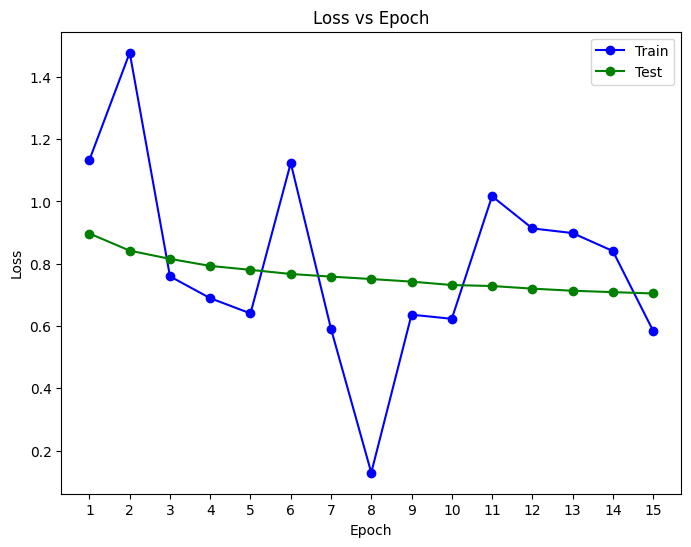

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.034566,0.067773,0.425660,0.624273,0.911332,0.906771,0.067844,0.308550
2,0.104390,0.130014,0.615721,0.612635,0.879078,0.887144,0.411710,0.583643
3,0.135499,0.106501,0.634851,0.632585,0.863380,0.891070,0.556691,0.643123
4,0.145178,0.149378,0.643585,0.639235,0.863380,0.879293,0.596654,0.680297
5,0.170757,0.114799,0.653774,0.655029,0.864238,0.886654,0.642193,0.698885
6,0.193916,0.147994,0.657101,0.679136,0.863748,0.875859,0.673792,0.702602
7,0.203941,0.157676,0.665419,0.660017,0.863503,0.887144,0.685874,0.706320
8,0.220532,0.179806,0.668538,0.646717,0.865955,0.891070,0.693309,0.721190
9,0.234359,0.222683,0.673529,0.640067,0.866323,0.892051,0.712825,0.724907


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.350877,0.408333,0.576782,0.621689,0.576181,0.660236,0.363184,0.783019
2,0.425352,0.415929,0.631613,0.666968,0.657193,0.673621,0.706539,0.720183
3,0.455285,0.461078,0.645318,0.669894,0.673362,0.675595,0.676836,0.714876
4,0.463576,0.475771,0.651031,0.676937,0.680983,0.686590,0.687366,0.703846
5,0.510331,0.525316,0.661060,0.675236,0.689463,0.684729,0.700101,0.698885
6,0.539423,0.507109,0.664005,0.674649,0.696982,0.701100,0.705253,0.713208
7,0.547818,0.535211,0.666389,0.688042,0.702274,0.694583,0.718598,0.722433
8,0.566607,0.532787,0.673157,0.693405,0.705959,0.698730,0.725681,0.723881
9,0.588542,0.547619,0.675354,0.700000,0.710664,0.706019,0.734674,0.738636


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.034566,0.067773,0.425660,0.624273,0.911332,0.906771,0.067844,0.308550
2,0.104390,0.130014,0.615721,0.612635,0.879078,0.887144,0.411710,0.583643
3,0.135499,0.106501,0.634851,0.632585,0.863380,0.891070,0.556691,0.643123
4,0.145178,0.149378,0.643585,0.639235,0.863380,0.879293,0.596654,0.680297
5,0.170757,0.114799,0.653774,0.655029,0.864238,0.886654,0.642193,0.698885
6,0.193916,0.147994,0.657101,0.679136,0.863748,0.875859,0.673792,0.702602
7,0.203941,0.157676,0.665419,0.660017,0.863503,0.887144,0.685874,0.706320
8,0.220532,0.179806,0.668538,0.646717,0.865955,0.891070,0.693309,0.721190
9,0.234359,0.222683,0.673529,0.640067,0.866323,0.892051,0.712825,0.724907


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.062933,0.116251,0.489830,0.622978,0.706000,0.764110,0.114330,0.442667
2,0.167638,0.198103,0.623565,0.638648,0.752112,0.765777,0.520258,0.644764
3,0.208844,0.173034,0.640042,0.650705,0.756623,0.768515,0.610913,0.677104
4,0.221111,0.227368,0.647286,0.657546,0.761410,0.771084,0.638806,0.691871
5,0.255892,0.188422,0.657397,0.664979,0.767020,0.772718,0.669898,0.698885
6,0.285278,0.229122,0.660535,0.676885,0.771455,0.778796,0.689164,0.707865
7,0.297229,0.243590,0.665904,0.673738,0.774587,0.779142,0.701854,0.714286
8,0.317492,0.268873,0.670840,0.669247,0.777815,0.783265,0.709125,0.722533
9,0.335229,0.316617,0.674440,0.668693,0.780811,0.788207,0.723585,0.731707


### Gráfico ROC para cada clase

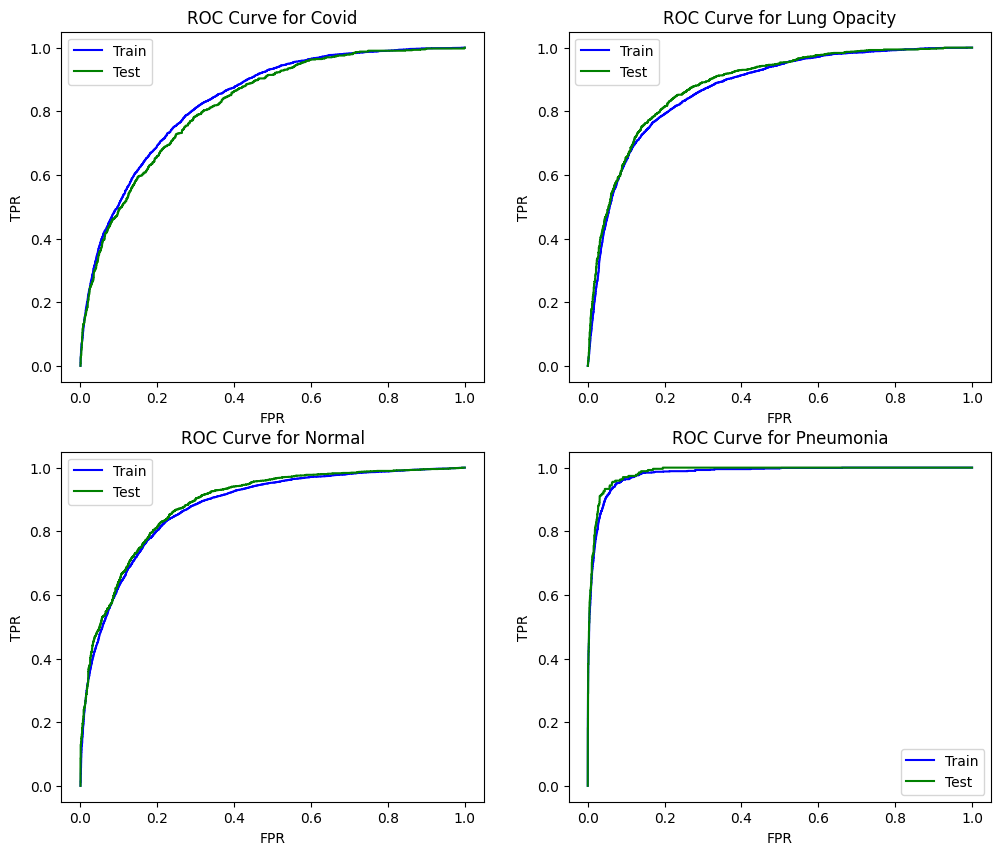

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 1 - MLP básica
## Con Feature Extractor

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
epochs = 15

feature_extracted_basic_mlp_model = MLP_basic(250*250, 128, 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_basic_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_basic_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_basic_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.405256  [   32/16932]
Current Loss: 1.370157  [  352/16932]
Current Loss: 1.294526  [  672/16932]
Current Loss: 1.300086  [  992/16932]
Current Loss: 1.154341  [ 1312/16932]
Current Loss: 1.252450  [ 1632/16932]
Current Loss: 1.121855  [ 1952/16932]
Current Loss: 1.217396  [ 2272/16932]
Current Loss: 1.129636  [ 2592/16932]
Current Loss: 1.059456  [ 2912/16932]
Current Loss: 1.191265  [ 3232/16932]
Current Loss: 1.186172  [ 3552/16932]
Current Loss: 1.121377  [ 3872/16932]
Current Loss: 1.075347  [ 4192/16932]
Current Loss: 0.981641  [ 4512/16932]
Current Loss: 1.053179  [ 4832/16932]
Current Loss: 0.973909  [ 5152/16932]
Current Loss: 0.989026  [ 5472/16932]
Current Loss: 1.036051  [ 5792/16932]
Current Loss: 0.950337  [ 6112/16932]
Current Loss: 1.095296  [ 6432/16932]
Current Loss: 1.062924  [ 6752/16932]
Current Loss: 0.818066  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.078838,0.581879,0.909715,0.200743


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.669726  [   32/16932]
Current Loss: 0.928633  [  352/16932]
Current Loss: 0.848081  [  672/16932]
Current Loss: 0.774095  [  992/16932]
Current Loss: 0.891817  [ 1312/16932]
Current Loss: 1.005378  [ 1632/16932]
Current Loss: 0.963911  [ 1952/16932]
Current Loss: 0.831047  [ 2272/16932]
Current Loss: 0.865567  [ 2592/16932]
Current Loss: 0.877001  [ 2912/16932]
Current Loss: 0.871120  [ 3232/16932]
Current Loss: 0.830790  [ 3552/16932]
Current Loss: 0.881920  [ 3872/16932]
Current Loss: 0.886294  [ 4192/16932]
Current Loss: 0.865034  [ 4512/16932]
Current Loss: 0.980539  [ 4832/16932]
Current Loss: 1.024435  [ 5152/16932]
Current Loss: 0.840655  [ 5472/16932]
Current Loss: 1.078321  [ 5792/16932]
Current Loss: 0.831436  [ 6112/16932]
Current Loss: 0.922476  [ 6432/16932]
Current Loss: 0.745631  [ 6752/16932]
Current Loss: 0.731553  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.11065,0.627598,0.881747,0.550186


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.915829  [   32/16932]
Current Loss: 0.842309  [  352/16932]
Current Loss: 0.969635  [  672/16932]
Current Loss: 0.870948  [  992/16932]
Current Loss: 1.125933  [ 1312/16932]
Current Loss: 0.987882  [ 1632/16932]
Current Loss: 0.788288  [ 1952/16932]
Current Loss: 1.015105  [ 2272/16932]
Current Loss: 1.292382  [ 2592/16932]
Current Loss: 0.670135  [ 2912/16932]
Current Loss: 0.802089  [ 3232/16932]
Current Loss: 0.689516  [ 3552/16932]
Current Loss: 0.926554  [ 3872/16932]
Current Loss: 0.874261  [ 4192/16932]
Current Loss: 0.798810  [ 4512/16932]
Current Loss: 0.882666  [ 4832/16932]
Current Loss: 0.902311  [ 5152/16932]
Current Loss: 0.735594  [ 5472/16932]
Current Loss: 0.847845  [ 5792/16932]
Current Loss: 0.770269  [ 6112/16932]
Current Loss: 0.891802  [ 6432/16932]
Current Loss: 0.946235  [ 6752/16932]
Current Loss: 0.765660  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.105118,0.64921,0.877821,0.654275


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.745709  [   32/16932]
Current Loss: 1.007325  [  352/16932]
Current Loss: 0.923748  [  672/16932]
Current Loss: 0.674040  [  992/16932]
Current Loss: 0.822359  [ 1312/16932]
Current Loss: 0.823647  [ 1632/16932]
Current Loss: 0.772735  [ 1952/16932]
Current Loss: 0.886091  [ 2272/16932]
Current Loss: 0.806780  [ 2592/16932]
Current Loss: 0.826247  [ 2912/16932]
Current Loss: 0.849920  [ 3232/16932]
Current Loss: 0.797059  [ 3552/16932]
Current Loss: 0.677239  [ 3872/16932]
Current Loss: 0.957031  [ 4192/16932]
Current Loss: 0.703352  [ 4512/16932]
Current Loss: 1.025073  [ 4832/16932]
Current Loss: 0.871594  [ 5152/16932]
Current Loss: 0.838048  [ 5472/16932]
Current Loss: 0.802611  [ 5792/16932]
Current Loss: 0.905917  [ 6112/16932]
Current Loss: 0.925001  [ 6432/16932]
Current Loss: 0.824788  [ 6752/16932]
Current Loss: 0.927424  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.135546,0.665835,0.866045,0.702602


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.750906  [   32/16932]
Current Loss: 0.852937  [  352/16932]
Current Loss: 0.954257  [  672/16932]
Current Loss: 0.834671  [  992/16932]
Current Loss: 0.866763  [ 1312/16932]
Current Loss: 0.861531  [ 1632/16932]
Current Loss: 0.634194  [ 1952/16932]
Current Loss: 0.772179  [ 2272/16932]
Current Loss: 0.867052  [ 2592/16932]
Current Loss: 0.766718  [ 2912/16932]
Current Loss: 0.632443  [ 3232/16932]
Current Loss: 0.998918  [ 3552/16932]
Current Loss: 0.665670  [ 3872/16932]
Current Loss: 0.668410  [ 4192/16932]
Current Loss: 0.802621  [ 4512/16932]
Current Loss: 0.749125  [ 4832/16932]
Current Loss: 0.811254  [ 5152/16932]
Current Loss: 1.018418  [ 5472/16932]
Current Loss: 0.824457  [ 5792/16932]
Current Loss: 0.615945  [ 6112/16932]
Current Loss: 0.867028  [ 6432/16932]
Current Loss: 0.983671  [ 6752/16932]
Current Loss: 0.851124  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.149378,0.673317,0.866045,0.713755


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.766807  [   32/16932]
Current Loss: 0.968517  [  352/16932]
Current Loss: 0.843187  [  672/16932]
Current Loss: 0.836476  [  992/16932]
Current Loss: 0.894631  [ 1312/16932]
Current Loss: 0.892962  [ 1632/16932]
Current Loss: 1.005988  [ 1952/16932]
Current Loss: 0.827133  [ 2272/16932]
Current Loss: 0.878676  [ 2592/16932]
Current Loss: 0.577790  [ 2912/16932]
Current Loss: 0.784641  [ 3232/16932]
Current Loss: 0.825408  [ 3552/16932]
Current Loss: 0.677918  [ 3872/16932]
Current Loss: 0.822909  [ 4192/16932]
Current Loss: 0.761624  [ 4512/16932]
Current Loss: 0.907110  [ 4832/16932]
Current Loss: 0.912284  [ 5152/16932]
Current Loss: 0.944411  [ 5472/16932]
Current Loss: 0.856363  [ 5792/16932]
Current Loss: 0.819259  [ 6112/16932]
Current Loss: 0.734364  [ 6432/16932]
Current Loss: 0.703904  [ 6752/16932]
Current Loss: 0.920393  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.143845,0.660848,0.879293,0.724907


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.734560  [   32/16932]
Current Loss: 0.754719  [  352/16932]
Current Loss: 0.782549  [  672/16932]
Current Loss: 0.841426  [  992/16932]
Current Loss: 0.721511  [ 1312/16932]
Current Loss: 0.698358  [ 1632/16932]
Current Loss: 0.736346  [ 1952/16932]
Current Loss: 0.700689  [ 2272/16932]
Current Loss: 0.730228  [ 2592/16932]
Current Loss: 0.794311  [ 2912/16932]
Current Loss: 0.755974  [ 3232/16932]
Current Loss: 0.965197  [ 3552/16932]
Current Loss: 0.791828  [ 3872/16932]
Current Loss: 0.789232  [ 4192/16932]
Current Loss: 0.639443  [ 4512/16932]
Current Loss: 0.745810  [ 4832/16932]
Current Loss: 0.854204  [ 5152/16932]
Current Loss: 0.733463  [ 5472/16932]
Current Loss: 0.847091  [ 5792/16932]
Current Loss: 0.832443  [ 6112/16932]
Current Loss: 0.886315  [ 6432/16932]
Current Loss: 0.966655  [ 6752/16932]
Current Loss: 0.753200  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.153527,0.700748,0.863592,0.743494


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.832148  [   32/16932]
Current Loss: 0.706493  [  352/16932]
Current Loss: 0.775887  [  672/16932]
Current Loss: 1.028963  [  992/16932]
Current Loss: 0.809789  [ 1312/16932]
Current Loss: 1.037634  [ 1632/16932]
Current Loss: 0.859675  [ 1952/16932]
Current Loss: 0.787811  [ 2272/16932]
Current Loss: 0.688956  [ 2592/16932]
Current Loss: 0.799750  [ 2912/16932]
Current Loss: 0.878156  [ 3232/16932]
Current Loss: 0.739390  [ 3552/16932]
Current Loss: 0.613107  [ 3872/16932]
Current Loss: 0.649805  [ 4192/16932]
Current Loss: 0.611949  [ 4512/16932]
Current Loss: 0.738303  [ 4832/16932]
Current Loss: 0.798189  [ 5152/16932]
Current Loss: 0.926885  [ 5472/16932]
Current Loss: 0.780242  [ 5792/16932]
Current Loss: 0.828440  [ 6112/16932]
Current Loss: 0.723938  [ 6432/16932]
Current Loss: 1.057640  [ 6752/16932]
Current Loss: 0.848135  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.157676,0.677473,0.883709,0.732342


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.629157  [   32/16932]
Current Loss: 0.744170  [  352/16932]
Current Loss: 0.860449  [  672/16932]
Current Loss: 0.788746  [  992/16932]
Current Loss: 0.909786  [ 1312/16932]
Current Loss: 0.862224  [ 1632/16932]
Current Loss: 0.887459  [ 1952/16932]
Current Loss: 0.639151  [ 2272/16932]
Current Loss: 0.821099  [ 2592/16932]
Current Loss: 1.003944  [ 2912/16932]
Current Loss: 0.849686  [ 3232/16932]
Current Loss: 0.859118  [ 3552/16932]
Current Loss: 0.781258  [ 3872/16932]
Current Loss: 0.622027  [ 4192/16932]
Current Loss: 0.910244  [ 4512/16932]
Current Loss: 0.778674  [ 4832/16932]
Current Loss: 0.799027  [ 5152/16932]
Current Loss: 0.798484  [ 5472/16932]
Current Loss: 0.781903  [ 5792/16932]
Current Loss: 0.984234  [ 6112/16932]
Current Loss: 0.801711  [ 6432/16932]
Current Loss: 0.997814  [ 6752/16932]
Current Loss: 0.917766  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.165975,0.695761,0.878312,0.747212


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.656346  [   32/16932]
Current Loss: 1.029434  [  352/16932]
Current Loss: 0.928388  [  672/16932]
Current Loss: 0.494829  [  992/16932]
Current Loss: 0.666150  [ 1312/16932]
Current Loss: 0.854282  [ 1632/16932]
Current Loss: 0.866081  [ 1952/16932]
Current Loss: 0.740129  [ 2272/16932]
Current Loss: 0.847272  [ 2592/16932]
Current Loss: 0.816355  [ 2912/16932]
Current Loss: 0.728644  [ 3232/16932]
Current Loss: 0.621798  [ 3552/16932]
Current Loss: 0.894776  [ 3872/16932]
Current Loss: 0.774151  [ 4192/16932]
Current Loss: 0.788689  [ 4512/16932]
Current Loss: 0.684713  [ 4832/16932]
Current Loss: 0.795297  [ 5152/16932]
Current Loss: 1.044740  [ 5472/16932]
Current Loss: 0.894256  [ 5792/16932]
Current Loss: 0.828459  [ 6112/16932]
Current Loss: 0.798755  [ 6432/16932]
Current Loss: 0.899187  [ 6752/16932]
Current Loss: 0.812765  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.233748,0.699086,0.859176,0.769517


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.718216  [   32/16932]
Current Loss: 0.757378  [  352/16932]
Current Loss: 0.701713  [  672/16932]
Current Loss: 0.888749  [  992/16932]
Current Loss: 0.774191  [ 1312/16932]
Current Loss: 0.861460  [ 1632/16932]
Current Loss: 0.765306  [ 1952/16932]
Current Loss: 0.787648  [ 2272/16932]
Current Loss: 0.750491  [ 2592/16932]
Current Loss: 0.763809  [ 2912/16932]
Current Loss: 0.717218  [ 3232/16932]
Current Loss: 0.931950  [ 3552/16932]
Current Loss: 0.574129  [ 3872/16932]
Current Loss: 0.949302  [ 4192/16932]
Current Loss: 0.632773  [ 4512/16932]
Current Loss: 0.847004  [ 4832/16932]
Current Loss: 0.809957  [ 5152/16932]
Current Loss: 0.828090  [ 5472/16932]
Current Loss: 0.786209  [ 5792/16932]
Current Loss: 0.622652  [ 6112/16932]
Current Loss: 0.777462  [ 6432/16932]
Current Loss: 0.800711  [ 6752/16932]
Current Loss: 0.659843  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.20332,0.707398,0.877331,0.750929


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.582755  [   32/16932]
Current Loss: 0.746317  [  352/16932]
Current Loss: 0.880188  [  672/16932]
Current Loss: 0.661109  [  992/16932]
Current Loss: 0.711365  [ 1312/16932]
Current Loss: 0.544569  [ 1632/16932]
Current Loss: 0.925645  [ 1952/16932]
Current Loss: 0.629063  [ 2272/16932]
Current Loss: 0.777800  [ 2592/16932]
Current Loss: 0.921506  [ 2912/16932]
Current Loss: 0.884136  [ 3232/16932]
Current Loss: 1.025649  [ 3552/16932]
Current Loss: 0.831320  [ 3872/16932]
Current Loss: 0.793116  [ 4192/16932]
Current Loss: 0.874536  [ 4512/16932]
Current Loss: 0.810699  [ 4832/16932]
Current Loss: 0.601261  [ 5152/16932]
Current Loss: 0.675136  [ 5472/16932]
Current Loss: 0.746760  [ 5792/16932]
Current Loss: 0.846772  [ 6112/16932]
Current Loss: 1.108987  [ 6432/16932]
Current Loss: 0.777974  [ 6752/16932]
Current Loss: 0.619693  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.207469,0.701579,0.881256,0.758364


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.747513  [   32/16932]
Current Loss: 0.744908  [  352/16932]
Current Loss: 0.769385  [  672/16932]
Current Loss: 0.712655  [  992/16932]
Current Loss: 0.693256  [ 1312/16932]
Current Loss: 0.763079  [ 1632/16932]
Current Loss: 0.735289  [ 1952/16932]
Current Loss: 0.760035  [ 2272/16932]
Current Loss: 0.667204  [ 2592/16932]
Current Loss: 0.787224  [ 2912/16932]
Current Loss: 0.755544  [ 3232/16932]
Current Loss: 0.746958  [ 3552/16932]
Current Loss: 0.737909  [ 3872/16932]
Current Loss: 0.659403  [ 4192/16932]
Current Loss: 0.830871  [ 4512/16932]
Current Loss: 0.671896  [ 4832/16932]
Current Loss: 0.740970  [ 5152/16932]
Current Loss: 0.830986  [ 5472/16932]
Current Loss: 0.611267  [ 5792/16932]
Current Loss: 0.659920  [ 6112/16932]
Current Loss: 0.818338  [ 6432/16932]
Current Loss: 0.752868  [ 6752/16932]
Current Loss: 0.653344  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.208852,0.709061,0.882237,0.750929


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.722531  [   32/16932]
Current Loss: 0.781334  [  352/16932]
Current Loss: 0.850618  [  672/16932]
Current Loss: 0.897778  [  992/16932]
Current Loss: 0.611828  [ 1312/16932]
Current Loss: 0.676104  [ 1632/16932]
Current Loss: 0.838202  [ 1952/16932]
Current Loss: 0.721193  [ 2272/16932]
Current Loss: 0.740755  [ 2592/16932]
Current Loss: 0.698890  [ 2912/16932]
Current Loss: 0.677795  [ 3232/16932]
Current Loss: 0.922720  [ 3552/16932]
Current Loss: 0.655390  [ 3872/16932]
Current Loss: 0.639005  [ 4192/16932]
Current Loss: 0.784138  [ 4512/16932]
Current Loss: 0.679799  [ 4832/16932]
Current Loss: 0.456471  [ 5152/16932]
Current Loss: 0.645113  [ 5472/16932]
Current Loss: 0.782604  [ 5792/16932]
Current Loss: 0.646498  [ 6112/16932]
Current Loss: 0.757222  [ 6432/16932]
Current Loss: 0.553090  [ 6752/16932]
Current Loss: 0.703081  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.240664,0.719867,0.877331,0.773234


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.705091  [   32/16932]
Current Loss: 0.689714  [  352/16932]
Current Loss: 0.679409  [  672/16932]
Current Loss: 0.881501  [  992/16932]
Current Loss: 0.959231  [ 1312/16932]
Current Loss: 0.794409  [ 1632/16932]
Current Loss: 0.650200  [ 1952/16932]
Current Loss: 1.050725  [ 2272/16932]
Current Loss: 0.722365  [ 2592/16932]
Current Loss: 0.630899  [ 2912/16932]
Current Loss: 0.797702  [ 3232/16932]
Current Loss: 0.715223  [ 3552/16932]
Current Loss: 0.748933  [ 3872/16932]
Current Loss: 0.755333  [ 4192/16932]
Current Loss: 0.725011  [ 4512/16932]
Current Loss: 0.616672  [ 4832/16932]
Current Loss: 0.521580  [ 5152/16932]
Current Loss: 0.606929  [ 5472/16932]
Current Loss: 0.571949  [ 5792/16932]
Current Loss: 0.710071  [ 6112/16932]
Current Loss: 0.730062  [ 6432/16932]
Current Loss: 1.035085  [ 6752/16932]
Current Loss: 0.624756  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.195021,0.729011,0.886654,0.765799


Training time: 28.393 minutes


## Evaluación del modelo

### Curva de entrenamiento

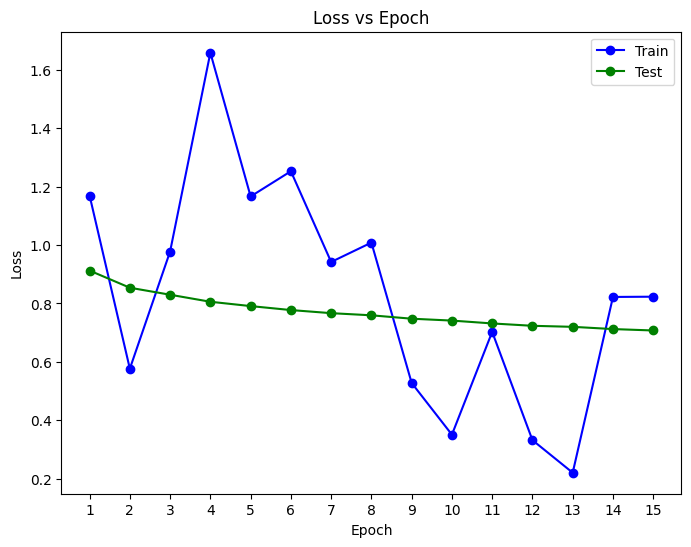

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.033875,0.078838,0.415679,0.581879,0.897228,0.909715,0.046468,0.200743
2,0.094366,0.110650,0.619048,0.627598,0.870248,0.881747,0.334572,0.550186
3,0.123747,0.105118,0.637970,0.649210,0.853691,0.877821,0.500000,0.654275
4,0.143104,0.135546,0.653982,0.665835,0.850748,0.866045,0.560409,0.702602
5,0.166955,0.149378,0.667083,0.673317,0.850625,0.866045,0.604089,0.713755
6,0.186312,0.143845,0.674153,0.660848,0.852956,0.879293,0.618030,0.724907
7,0.200830,0.153527,0.676856,0.700748,0.855776,0.863592,0.639405,0.743494
8,0.219150,0.157676,0.690372,0.677473,0.853691,0.883709,0.654275,0.732342
9,0.234013,0.165975,0.690996,0.695761,0.860927,0.878312,0.651487,0.747212


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.513089,0.410072,0.537944,0.615655,0.574751,0.644870,0.168919,0.658537
2,0.451987,0.437158,0.613435,0.647513,0.651248,0.673538,0.621762,0.685185
3,0.454315,0.496732,0.632577,0.652465,0.668363,0.682564,0.612059,0.671756
4,0.480836,0.478049,0.638838,0.658176,0.680498,0.697353,0.632075,0.675000
5,0.512195,0.488688,0.650314,0.663934,0.690630,0.703748,0.641658,0.676056
6,0.535253,0.527919,0.656807,0.670886,0.697593,0.698363,0.652601,0.684211
7,0.536969,0.526066,0.664421,0.665877,0.703215,0.713128,0.669261,0.694444
8,0.559083,0.553398,0.666399,0.678037,0.711977,0.705721,0.677575,0.721612
9,0.581116,0.560748,0.672944,0.677184,0.715305,0.714856,0.690640,0.720430


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.033875,0.078838,0.415679,0.581879,0.897228,0.909715,0.046468,0.200743
2,0.094366,0.110650,0.619048,0.627598,0.870248,0.881747,0.334572,0.550186
3,0.123747,0.105118,0.637970,0.649210,0.853691,0.877821,0.500000,0.654275
4,0.143104,0.135546,0.653982,0.665835,0.850748,0.866045,0.560409,0.702602
5,0.166955,0.149378,0.667083,0.673317,0.850625,0.866045,0.604089,0.713755
6,0.186312,0.143845,0.674153,0.660848,0.852956,0.879293,0.618030,0.724907
7,0.200830,0.153527,0.676856,0.700748,0.855776,0.863592,0.639405,0.743494
8,0.219150,0.157676,0.690372,0.677473,0.853691,0.883709,0.654275,0.732342
9,0.234013,0.165975,0.690996,0.695761,0.860927,0.878312,0.651487,0.747212


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.063554,0.132251,0.468974,0.598291,0.700666,0.754732,0.072886,0.307692
2,0.156134,0.176600,0.616229,0.637400,0.744987,0.763706,0.435045,0.610309
3,0.194512,0.173516,0.635262,0.650833,0.749744,0.767976,0.550384,0.662900
4,0.220565,0.211207,0.646321,0.661983,0.756159,0.772598,0.594089,0.688525
5,0.251825,0.228814,0.658592,0.668593,0.762323,0.776507,0.622307,0.694394
6,0.276410,0.226087,0.665367,0.665829,0.767491,0.778454,0.634845,0.703971
7,0.292327,0.237687,0.670581,0.682868,0.772031,0.781181,0.653992,0.718133
8,0.314875,0.245425,0.678174,0.677755,0.776421,0.784749,0.665721,0.726937
9,0.333662,0.256137,0.681851,0.686347,0.781389,0.788199,0.670493,0.733577


### Gráfico ROC para cada clase

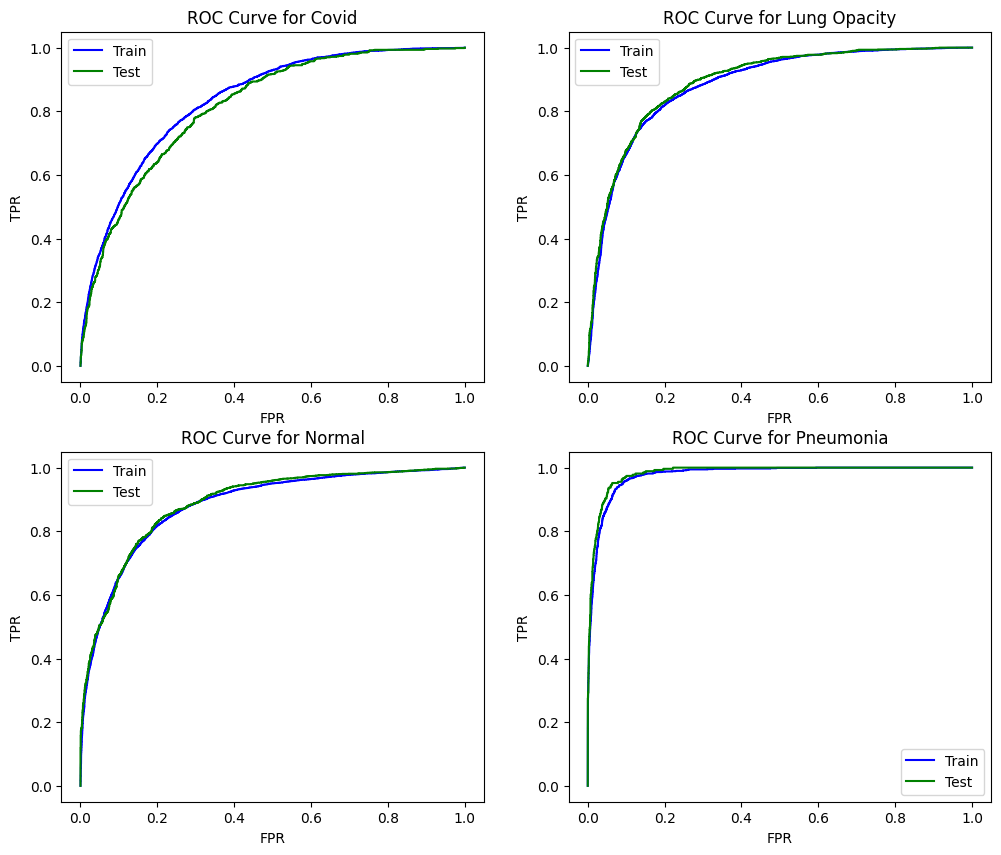

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 2 - MLP con capas ocultas múltiples
## Sin Feature Extractor

## Arquitectura del modelo

In [ ]:
class MLP_hiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP_hiddenLayers, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Capa de entrada
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()

        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            hidden_layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden_layers.append(hidden_layer)

        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x


## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-4
momentum = 0.2
epochs = 15

unfiltered_hidden_layers_mlp_model = MLP_hiddenLayers(250*250, [512, 256], 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_hidden_layers_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_hidden_layers_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_hidden_layers_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.397831  [   32/16932]
Current Loss: 1.378978  [  352/16932]
Current Loss: 1.384717  [  672/16932]
Current Loss: 1.372627  [  992/16932]
Current Loss: 1.339100  [ 1312/16932]
Current Loss: 1.341683  [ 1632/16932]
Current Loss: 1.354315  [ 1952/16932]
Current Loss: 1.323780  [ 2272/16932]
Current Loss: 1.312542  [ 2592/16932]
Current Loss: 1.340717  [ 2912/16932]
Current Loss: 1.325326  [ 3232/16932]
Current Loss: 1.312809  [ 3552/16932]
Current Loss: 1.317825  [ 3872/16932]
Current Loss: 1.272977  [ 4192/16932]
Current Loss: 1.283811  [ 4512/16932]
Current Loss: 1.194895  [ 4832/16932]
Current Loss: 1.255296  [ 5152/16932]
Current Loss: 1.272740  [ 5472/16932]
Current Loss: 1.254151  [ 5792/16932]
Current Loss: 1.217908  [ 6112/16932]
Current Loss: 1.241321  [ 6432/16932]
Current Loss: 1.250858  [ 6752/16932]
Current Loss: 1.149055  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.001383,0.262677,0.982826,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.134277  [   32/16932]
Current Loss: 1.140489  [  352/16932]
Current Loss: 0.982525  [  672/16932]
Current Loss: 1.103181  [  992/16932]
Current Loss: 1.038212  [ 1312/16932]
Current Loss: 1.056319  [ 1632/16932]
Current Loss: 1.043153  [ 1952/16932]
Current Loss: 1.181488  [ 2272/16932]
Current Loss: 1.146851  [ 2592/16932]
Current Loss: 1.023377  [ 2912/16932]
Current Loss: 0.927027  [ 3232/16932]
Current Loss: 1.198297  [ 3552/16932]
Current Loss: 1.217812  [ 3872/16932]
Current Loss: 1.169180  [ 4192/16932]
Current Loss: 0.946208  [ 4512/16932]
Current Loss: 0.992873  [ 4832/16932]
Current Loss: 0.919347  [ 5152/16932]
Current Loss: 0.956149  [ 5472/16932]
Current Loss: 1.060327  [ 5792/16932]
Current Loss: 1.039171  [ 6112/16932]
Current Loss: 1.056490  [ 6432/16932]
Current Loss: 1.061659  [ 6752/16932]
Current Loss: 1.088837  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.013831,0.505403,0.958292,0.01487


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.984798  [   32/16932]
Current Loss: 1.119897  [  352/16932]
Current Loss: 1.060854  [  672/16932]
Current Loss: 0.882297  [  992/16932]
Current Loss: 1.058156  [ 1312/16932]
Current Loss: 1.126335  [ 1632/16932]
Current Loss: 1.106574  [ 1952/16932]
Current Loss: 0.906419  [ 2272/16932]
Current Loss: 1.097079  [ 2592/16932]
Current Loss: 1.051992  [ 2912/16932]
Current Loss: 0.983222  [ 3232/16932]
Current Loss: 0.883011  [ 3552/16932]
Current Loss: 0.936988  [ 3872/16932]
Current Loss: 0.805167  [ 4192/16932]
Current Loss: 1.126919  [ 4512/16932]
Current Loss: 0.973049  [ 4832/16932]
Current Loss: 0.907992  [ 5152/16932]
Current Loss: 0.955516  [ 5472/16932]
Current Loss: 0.874615  [ 5792/16932]
Current Loss: 0.962823  [ 6112/16932]
Current Loss: 0.880926  [ 6432/16932]
Current Loss: 0.689123  [ 6752/16932]
Current Loss: 0.894192  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.033195,0.59601,0.932777,0.126394


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.000843  [   32/16932]
Current Loss: 0.944675  [  352/16932]
Current Loss: 1.054336  [  672/16932]
Current Loss: 0.918603  [  992/16932]
Current Loss: 0.822599  [ 1312/16932]
Current Loss: 0.980126  [ 1632/16932]
Current Loss: 0.861962  [ 1952/16932]
Current Loss: 0.871431  [ 2272/16932]
Current Loss: 0.898863  [ 2592/16932]
Current Loss: 1.103631  [ 2912/16932]
Current Loss: 0.908302  [ 3232/16932]
Current Loss: 1.039421  [ 3552/16932]
Current Loss: 0.869847  [ 3872/16932]
Current Loss: 1.183217  [ 4192/16932]
Current Loss: 0.885320  [ 4512/16932]
Current Loss: 0.874945  [ 4832/16932]
Current Loss: 1.145887  [ 5152/16932]
Current Loss: 0.935634  [ 5472/16932]
Current Loss: 0.958847  [ 5792/16932]
Current Loss: 0.958435  [ 6112/16932]
Current Loss: 1.069411  [ 6432/16932]
Current Loss: 0.960371  [ 6752/16932]
Current Loss: 0.999311  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.080221,0.60931,0.917566,0.297398


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.798896  [   32/16932]
Current Loss: 0.883766  [  352/16932]
Current Loss: 0.748420  [  672/16932]
Current Loss: 0.753454  [  992/16932]
Current Loss: 0.845882  [ 1312/16932]
Current Loss: 1.032111  [ 1632/16932]
Current Loss: 0.775208  [ 1952/16932]
Current Loss: 0.802350  [ 2272/16932]
Current Loss: 0.954278  [ 2592/16932]
Current Loss: 0.652714  [ 2912/16932]
Current Loss: 0.948349  [ 3232/16932]
Current Loss: 0.830043  [ 3552/16932]
Current Loss: 0.758794  [ 3872/16932]
Current Loss: 0.726880  [ 4192/16932]
Current Loss: 0.869827  [ 4512/16932]
Current Loss: 0.980287  [ 4832/16932]
Current Loss: 1.055929  [ 5152/16932]
Current Loss: 0.828251  [ 5472/16932]
Current Loss: 1.043038  [ 5792/16932]
Current Loss: 0.881641  [ 6112/16932]
Current Loss: 1.163239  [ 6432/16932]
Current Loss: 0.829537  [ 6752/16932]
Current Loss: 0.974595  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.085754,0.647548,0.897448,0.431227


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.808781  [   32/16932]
Current Loss: 0.803438  [  352/16932]
Current Loss: 1.021450  [  672/16932]
Current Loss: 0.938956  [  992/16932]
Current Loss: 0.890608  [ 1312/16932]
Current Loss: 0.821802  [ 1632/16932]
Current Loss: 0.812821  [ 1952/16932]
Current Loss: 0.756110  [ 2272/16932]
Current Loss: 0.867391  [ 2592/16932]
Current Loss: 0.871675  [ 2912/16932]
Current Loss: 0.698544  [ 3232/16932]
Current Loss: 0.666770  [ 3552/16932]
Current Loss: 0.872742  [ 3872/16932]
Current Loss: 0.869823  [ 4192/16932]
Current Loss: 0.889951  [ 4512/16932]
Current Loss: 0.866507  [ 4832/16932]
Current Loss: 0.881032  [ 5152/16932]
Current Loss: 0.745048  [ 5472/16932]
Current Loss: 0.788314  [ 5792/16932]
Current Loss: 0.938403  [ 6112/16932]
Current Loss: 0.827793  [ 6432/16932]
Current Loss: 0.766714  [ 6752/16932]
Current Loss: 0.872559  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.103734,0.654198,0.885182,0.527881


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.968477  [   32/16932]
Current Loss: 0.823765  [  352/16932]
Current Loss: 0.939421  [  672/16932]
Current Loss: 0.643032  [  992/16932]
Current Loss: 0.819683  [ 1312/16932]
Current Loss: 0.874576  [ 1632/16932]
Current Loss: 0.922409  [ 1952/16932]
Current Loss: 0.795898  [ 2272/16932]
Current Loss: 0.807347  [ 2592/16932]
Current Loss: 0.711317  [ 2912/16932]
Current Loss: 0.677437  [ 3232/16932]
Current Loss: 0.785657  [ 3552/16932]
Current Loss: 0.828181  [ 3872/16932]
Current Loss: 0.893545  [ 4192/16932]
Current Loss: 0.864351  [ 4512/16932]
Current Loss: 0.766159  [ 4832/16932]
Current Loss: 0.763037  [ 5152/16932]
Current Loss: 1.004907  [ 5472/16932]
Current Loss: 0.809096  [ 5792/16932]
Current Loss: 0.709423  [ 6112/16932]
Current Loss: 0.890354  [ 6432/16932]
Current Loss: 0.818139  [ 6752/16932]
Current Loss: 0.877517  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.094053,0.670823,0.882728,0.568773


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.828812  [   32/16932]
Current Loss: 0.867426  [  352/16932]
Current Loss: 0.725272  [  672/16932]
Current Loss: 0.743186  [  992/16932]
Current Loss: 0.762051  [ 1312/16932]
Current Loss: 0.808157  [ 1632/16932]
Current Loss: 0.932514  [ 1952/16932]
Current Loss: 0.747518  [ 2272/16932]
Current Loss: 0.943183  [ 2592/16932]
Current Loss: 0.931222  [ 2912/16932]
Current Loss: 0.890153  [ 3232/16932]
Current Loss: 0.617420  [ 3552/16932]
Current Loss: 0.840251  [ 3872/16932]
Current Loss: 0.823719  [ 4192/16932]
Current Loss: 1.105891  [ 4512/16932]
Current Loss: 0.863079  [ 4832/16932]
Current Loss: 0.901523  [ 5152/16932]
Current Loss: 0.678205  [ 5472/16932]
Current Loss: 0.779303  [ 5792/16932]
Current Loss: 1.018583  [ 6112/16932]
Current Loss: 0.716436  [ 6432/16932]
Current Loss: 0.850331  [ 6752/16932]
Current Loss: 0.805575  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.105118,0.657523,0.893523,0.624535


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.861406  [   32/16932]
Current Loss: 0.826062  [  352/16932]
Current Loss: 0.762365  [  672/16932]
Current Loss: 1.021638  [  992/16932]
Current Loss: 1.006170  [ 1312/16932]
Current Loss: 0.772629  [ 1632/16932]
Current Loss: 0.772996  [ 1952/16932]
Current Loss: 0.674354  [ 2272/16932]
Current Loss: 0.849916  [ 2592/16932]
Current Loss: 0.719248  [ 2912/16932]
Current Loss: 0.860650  [ 3232/16932]
Current Loss: 0.821754  [ 3552/16932]
Current Loss: 0.851837  [ 3872/16932]
Current Loss: 0.692410  [ 4192/16932]
Current Loss: 0.636319  [ 4512/16932]
Current Loss: 0.979832  [ 4832/16932]
Current Loss: 1.015196  [ 5152/16932]
Current Loss: 0.831536  [ 5472/16932]
Current Loss: 0.911448  [ 5792/16932]
Current Loss: 0.551150  [ 6112/16932]
Current Loss: 0.820270  [ 6432/16932]
Current Loss: 0.779072  [ 6752/16932]
Current Loss: 0.728880  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.127248,0.681629,0.873896,0.650558


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.852516  [   32/16932]
Current Loss: 0.971036  [  352/16932]
Current Loss: 0.867409  [  672/16932]
Current Loss: 0.962517  [  992/16932]
Current Loss: 0.520979  [ 1312/16932]
Current Loss: 0.924875  [ 1632/16932]
Current Loss: 0.681022  [ 1952/16932]
Current Loss: 0.749544  [ 2272/16932]
Current Loss: 0.880948  [ 2592/16932]
Current Loss: 0.968560  [ 2912/16932]
Current Loss: 0.754577  [ 3232/16932]
Current Loss: 0.795736  [ 3552/16932]
Current Loss: 0.764771  [ 3872/16932]
Current Loss: 0.904145  [ 4192/16932]
Current Loss: 0.700659  [ 4512/16932]
Current Loss: 0.844562  [ 4832/16932]
Current Loss: 0.847622  [ 5152/16932]
Current Loss: 0.808771  [ 5472/16932]
Current Loss: 0.903806  [ 5792/16932]
Current Loss: 0.789564  [ 6112/16932]
Current Loss: 0.689200  [ 6432/16932]
Current Loss: 0.529478  [ 6752/16932]
Current Loss: 0.776592  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.138313,0.670823,0.879293,0.672862


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.780331  [   32/16932]
Current Loss: 0.805285  [  352/16932]
Current Loss: 0.929454  [  672/16932]
Current Loss: 0.718475  [  992/16932]
Current Loss: 0.808028  [ 1312/16932]
Current Loss: 0.684327  [ 1632/16932]
Current Loss: 0.725743  [ 1952/16932]
Current Loss: 0.754236  [ 2272/16932]
Current Loss: 0.800582  [ 2592/16932]
Current Loss: 0.689151  [ 2912/16932]
Current Loss: 0.921378  [ 3232/16932]
Current Loss: 0.753465  [ 3552/16932]
Current Loss: 0.693395  [ 3872/16932]
Current Loss: 0.634769  [ 4192/16932]
Current Loss: 0.588100  [ 4512/16932]
Current Loss: 0.599542  [ 4832/16932]
Current Loss: 0.677786  [ 5152/16932]
Current Loss: 0.827229  [ 5472/16932]
Current Loss: 0.885707  [ 5792/16932]
Current Loss: 0.902020  [ 6112/16932]
Current Loss: 0.697082  [ 6432/16932]
Current Loss: 0.727121  [ 6752/16932]
Current Loss: 0.816372  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.123098,0.68246,0.882728,0.684015


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.640204  [   32/16932]
Current Loss: 0.859335  [  352/16932]
Current Loss: 0.720757  [  672/16932]
Current Loss: 0.853269  [  992/16932]
Current Loss: 0.864335  [ 1312/16932]
Current Loss: 0.787198  [ 1632/16932]
Current Loss: 0.679122  [ 1952/16932]
Current Loss: 0.816310  [ 2272/16932]
Current Loss: 0.789550  [ 2592/16932]
Current Loss: 0.594260  [ 2912/16932]
Current Loss: 0.925757  [ 3232/16932]
Current Loss: 0.592877  [ 3552/16932]
Current Loss: 0.815103  [ 3872/16932]
Current Loss: 0.618137  [ 4192/16932]
Current Loss: 0.655073  [ 4512/16932]
Current Loss: 0.892403  [ 4832/16932]
Current Loss: 0.685530  [ 5152/16932]
Current Loss: 1.010610  [ 5472/16932]
Current Loss: 0.914225  [ 5792/16932]
Current Loss: 0.628889  [ 6112/16932]
Current Loss: 0.769412  [ 6432/16932]
Current Loss: 0.796063  [ 6752/16932]
Current Loss: 0.943992  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.150761,0.669992,0.880275,0.702602


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.979522  [   32/16932]
Current Loss: 0.943874  [  352/16932]
Current Loss: 0.681499  [  672/16932]
Current Loss: 0.926186  [  992/16932]
Current Loss: 0.842383  [ 1312/16932]
Current Loss: 0.793013  [ 1632/16932]
Current Loss: 0.639282  [ 1952/16932]
Current Loss: 0.889789  [ 2272/16932]
Current Loss: 0.743764  [ 2592/16932]
Current Loss: 0.880067  [ 2912/16932]
Current Loss: 0.766348  [ 3232/16932]
Current Loss: 0.750830  [ 3552/16932]
Current Loss: 0.706429  [ 3872/16932]
Current Loss: 0.891306  [ 4192/16932]
Current Loss: 0.655082  [ 4512/16932]
Current Loss: 0.837363  [ 4832/16932]
Current Loss: 0.785302  [ 5152/16932]
Current Loss: 0.775589  [ 5472/16932]
Current Loss: 0.619296  [ 5792/16932]
Current Loss: 0.762770  [ 6112/16932]
Current Loss: 0.752490  [ 6432/16932]
Current Loss: 0.810636  [ 6752/16932]
Current Loss: 0.778513  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.160443,0.693267,0.871443,0.717472


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.778635  [   32/16932]
Current Loss: 0.717035  [  352/16932]
Current Loss: 0.872801  [  672/16932]
Current Loss: 0.738404  [  992/16932]
Current Loss: 0.865877  [ 1312/16932]
Current Loss: 1.144906  [ 1632/16932]
Current Loss: 0.770979  [ 1952/16932]
Current Loss: 0.710897  [ 2272/16932]
Current Loss: 0.956466  [ 2592/16932]
Current Loss: 0.839150  [ 2912/16932]
Current Loss: 0.987374  [ 3232/16932]
Current Loss: 0.631918  [ 3552/16932]
Current Loss: 0.688436  [ 3872/16932]
Current Loss: 0.760224  [ 4192/16932]
Current Loss: 0.968348  [ 4512/16932]
Current Loss: 0.779539  [ 4832/16932]
Current Loss: 0.566260  [ 5152/16932]
Current Loss: 0.936238  [ 5472/16932]
Current Loss: 0.846806  [ 5792/16932]
Current Loss: 0.934327  [ 6112/16932]
Current Loss: 0.777121  [ 6432/16932]
Current Loss: 0.840915  [ 6752/16932]
Current Loss: 0.863078  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.159059,0.688279,0.878312,0.72119


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.837434  [   32/16932]
Current Loss: 0.707746  [  352/16932]
Current Loss: 0.747425  [  672/16932]
Current Loss: 0.939006  [  992/16932]
Current Loss: 0.617630  [ 1312/16932]
Current Loss: 0.562835  [ 1632/16932]
Current Loss: 0.847530  [ 1952/16932]
Current Loss: 0.713143  [ 2272/16932]
Current Loss: 1.000882  [ 2592/16932]
Current Loss: 0.845073  [ 2912/16932]
Current Loss: 0.894856  [ 3232/16932]
Current Loss: 0.757957  [ 3552/16932]
Current Loss: 0.709178  [ 3872/16932]
Current Loss: 0.826600  [ 4192/16932]
Current Loss: 0.633653  [ 4512/16932]
Current Loss: 0.766604  [ 4832/16932]
Current Loss: 0.933719  [ 5152/16932]
Current Loss: 0.692091  [ 5472/16932]
Current Loss: 0.718624  [ 5792/16932]
Current Loss: 0.664634  [ 6112/16932]
Current Loss: 0.793308  [ 6432/16932]
Current Loss: 0.843753  [ 6752/16932]
Current Loss: 0.871636  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.178423,0.691604,0.871933,0.739777


Training time: 19.331 minutes


## Evaluación del modelo

### Curva de entrenamiento

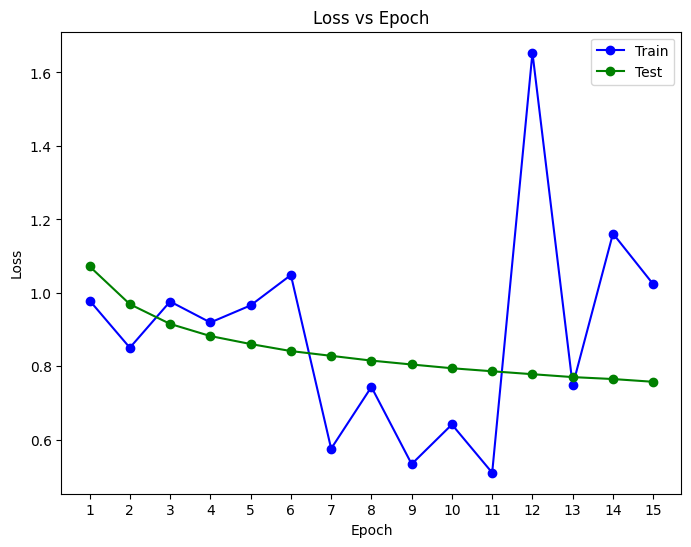

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.007553,0.001383,0.148997,0.262677,0.948022,0.982826,0.000983,0.000000
2,0.009333,0.013831,0.391765,0.505403,0.960142,0.958292,0.000929,0.014870
3,0.042171,0.033195,0.542109,0.596010,0.929237,0.932777,0.052974,0.126394
4,0.063256,0.080221,0.603452,0.609310,0.904955,0.917566,0.196097,0.297398
5,0.090563,0.085754,0.618840,0.647548,0.891219,0.897448,0.342007,0.431227
6,0.097822,0.103734,0.639218,0.654198,0.880059,0.885182,0.434944,0.527881
7,0.116488,0.094053,0.644001,0.670823,0.873804,0.882728,0.502788,0.568773
8,0.118562,0.105118,0.654814,0.657523,0.869512,0.893523,0.534387,0.624535
9,0.131352,0.127248,0.656685,0.681629,0.869389,0.873896,0.568773,0.650558


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.292857,0.500000,0.479093,0.658333,0.504937,0.534418,0.023529,0.000000
2,0.415385,0.303030,0.625290,0.640000,0.566088,0.602592,0.041667,0.444444
3,0.384858,0.347826,0.615439,0.621317,0.616267,0.640499,0.678571,0.809524
4,0.408482,0.400000,0.614830,0.639616,0.641708,0.657756,0.796226,0.808081
5,0.410016,0.378049,0.626263,0.642739,0.656400,0.674659,0.782979,0.794521
6,0.431402,0.384615,0.632901,0.650413,0.665307,0.681784,0.739336,0.780220
7,0.434278,0.419753,0.641466,0.650282,0.673250,0.684030,0.726174,0.765000
8,0.443726,0.431818,0.642129,0.673191,0.678339,0.683559,0.716065,0.770642
9,0.466830,0.462312,0.650463,0.662894,0.681962,0.695975,0.705069,0.735294


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.007553,0.001383,0.148997,0.262677,0.948022,0.982826,0.000983,0.000000
2,0.009333,0.013831,0.391765,0.505403,0.960142,0.958292,0.000929,0.014870
3,0.042171,0.033195,0.542109,0.596010,0.929237,0.932777,0.052974,0.126394
4,0.063256,0.080221,0.603452,0.609310,0.904955,0.917566,0.196097,0.297398
5,0.090563,0.085754,0.618840,0.647548,0.891219,0.897448,0.342007,0.431227
6,0.097822,0.103734,0.639218,0.654198,0.880059,0.885182,0.434944,0.527881
7,0.116488,0.094053,0.644001,0.670823,0.873804,0.882728,0.502788,0.568773
8,0.118562,0.105118,0.654814,0.657523,0.869512,0.893523,0.534387,0.624535
9,0.131352,0.127248,0.656685,0.681629,0.869389,0.873896,0.568773,0.650558


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.014727,0.002759,0.227303,0.375520,0.658920,0.692361,0.001888,0.000000
2,0.018256,0.026455,0.481718,0.564793,0.712245,0.739913,0.001818,0.028777
3,0.076012,0.060606,0.576451,0.608401,0.741063,0.759489,0.098276,0.218650
4,0.109548,0.133641,0.609088,0.624095,0.750929,0.766236,0.314691,0.434783
5,0.148358,0.139797,0.622529,0.645135,0.755995,0.770267,0.476067,0.559036
6,0.159482,0.163399,0.636044,0.652300,0.757761,0.770282,0.547689,0.629712
7,0.183701,0.153672,0.642731,0.660393,0.760527,0.770780,0.594179,0.652452
8,0.187125,0.169077,0.648409,0.665265,0.762120,0.774564,0.612028,0.689938
9,0.205018,0.199566,0.653560,0.672131,0.764354,0.774853,0.629630,0.690335


### Gráfico ROC para cada clase

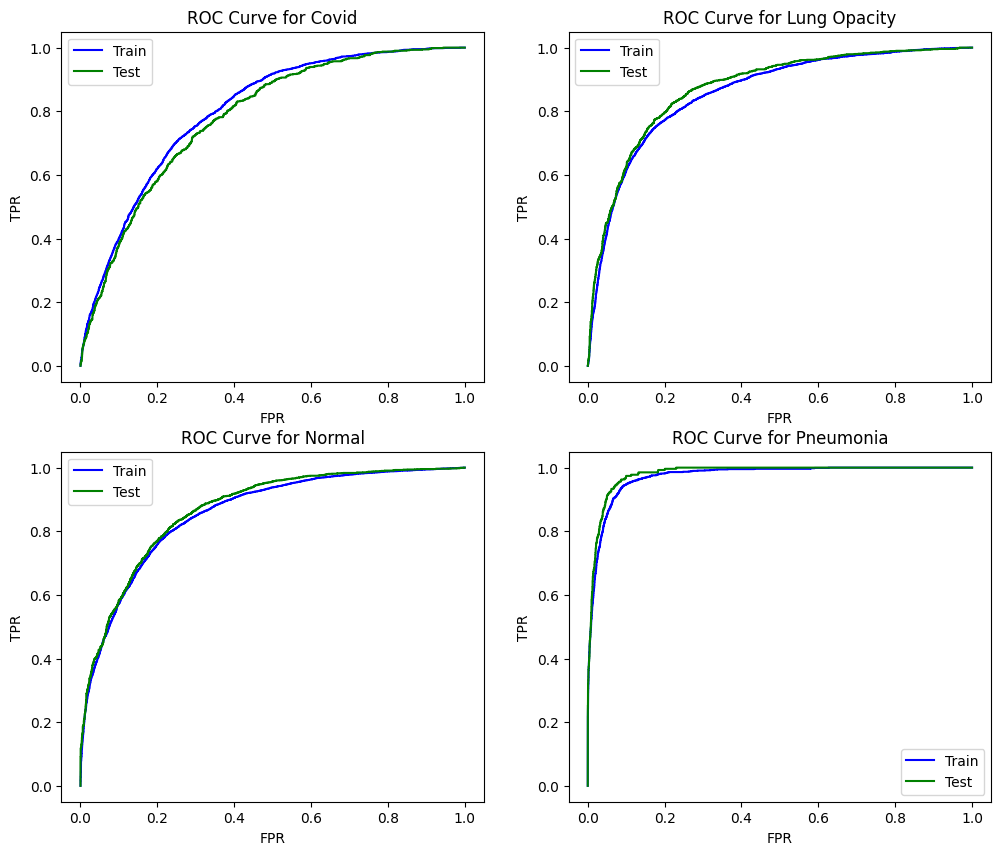

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 2 - MLP con múltiples capas ocultas
## Con Feature Extractor

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-4
momentum = 0.2
epochs = 15

feature_extracted_hidden_layers_mlp_model = MLP_hiddenLayers(250*250, [512, 256], 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_hidden_layers_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_hidden_layers_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_hidden_layers_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.378485  [   32/16932]
Current Loss: 1.363985  [  352/16932]
Current Loss: 1.361793  [  672/16932]
Current Loss: 1.361706  [  992/16932]
Current Loss: 1.343476  [ 1312/16932]
Current Loss: 1.339676  [ 1632/16932]
Current Loss: 1.316740  [ 1952/16932]
Current Loss: 1.273508  [ 2272/16932]
Current Loss: 1.296363  [ 2592/16932]
Current Loss: 1.246633  [ 2912/16932]
Current Loss: 1.341281  [ 3232/16932]
Current Loss: 1.277808  [ 3552/16932]
Current Loss: 1.271988  [ 3872/16932]
Current Loss: 1.263086  [ 4192/16932]
Current Loss: 1.227771  [ 4512/16932]
Current Loss: 1.206764  [ 4832/16932]
Current Loss: 1.260819  [ 5152/16932]
Current Loss: 1.229280  [ 5472/16932]
Current Loss: 1.171826  [ 5792/16932]
Current Loss: 1.271999  [ 6112/16932]
Current Loss: 1.254531  [ 6432/16932]
Current Loss: 1.147968  [ 6752/16932]
Current Loss: 1.279021  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.004149,0.068163,0.987242,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.952411  [   32/16932]
Current Loss: 1.087179  [  352/16932]
Current Loss: 1.170332  [  672/16932]
Current Loss: 1.024938  [  992/16932]
Current Loss: 1.137250  [ 1312/16932]
Current Loss: 1.108751  [ 1632/16932]
Current Loss: 1.153302  [ 1952/16932]
Current Loss: 1.022884  [ 2272/16932]
Current Loss: 1.051343  [ 2592/16932]
Current Loss: 0.977605  [ 2912/16932]
Current Loss: 1.063979  [ 3232/16932]
Current Loss: 1.105184  [ 3552/16932]
Current Loss: 1.057271  [ 3872/16932]
Current Loss: 0.890794  [ 4192/16932]
Current Loss: 1.069217  [ 4512/16932]
Current Loss: 0.924024  [ 4832/16932]
Current Loss: 0.986363  [ 5152/16932]
Current Loss: 1.096139  [ 5472/16932]
Current Loss: 1.169474  [ 5792/16932]
Current Loss: 1.092422  [ 6112/16932]
Current Loss: 1.101799  [ 6432/16932]
Current Loss: 1.016926  [ 6752/16932]
Current Loss: 1.018506  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.02213,0.421446,0.962709,0.0


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.973290  [   32/16932]
Current Loss: 0.837843  [  352/16932]
Current Loss: 0.942005  [  672/16932]
Current Loss: 1.024523  [  992/16932]
Current Loss: 0.958557  [ 1312/16932]
Current Loss: 0.983592  [ 1632/16932]
Current Loss: 1.002292  [ 1952/16932]
Current Loss: 0.949417  [ 2272/16932]
Current Loss: 0.867022  [ 2592/16932]
Current Loss: 1.018135  [ 2912/16932]
Current Loss: 1.027063  [ 3232/16932]
Current Loss: 0.996794  [ 3552/16932]
Current Loss: 0.925773  [ 3872/16932]
Current Loss: 1.111499  [ 4192/16932]
Current Loss: 1.086175  [ 4512/16932]
Current Loss: 0.718457  [ 4832/16932]
Current Loss: 0.850213  [ 5152/16932]
Current Loss: 0.991897  [ 5472/16932]
Current Loss: 0.999667  [ 5792/16932]
Current Loss: 1.031995  [ 6112/16932]
Current Loss: 1.021320  [ 6432/16932]
Current Loss: 0.982969  [ 6752/16932]
Current Loss: 0.983406  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.049793,0.564422,0.924436,0.022305


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.901695  [   32/16932]
Current Loss: 1.070742  [  352/16932]
Current Loss: 0.825697  [  672/16932]
Current Loss: 1.009993  [  992/16932]
Current Loss: 1.034317  [ 1312/16932]
Current Loss: 0.973357  [ 1632/16932]
Current Loss: 0.823967  [ 1952/16932]
Current Loss: 0.922378  [ 2272/16932]
Current Loss: 0.917316  [ 2592/16932]
Current Loss: 1.139244  [ 2912/16932]
Current Loss: 0.979926  [ 3232/16932]
Current Loss: 0.889874  [ 3552/16932]
Current Loss: 0.949187  [ 3872/16932]
Current Loss: 1.003467  [ 4192/16932]
Current Loss: 0.916135  [ 4512/16932]
Current Loss: 1.007303  [ 4832/16932]
Current Loss: 0.804475  [ 5152/16932]
Current Loss: 0.899700  [ 5472/16932]
Current Loss: 0.868680  [ 5792/16932]
Current Loss: 0.891362  [ 6112/16932]
Current Loss: 0.760725  [ 6432/16932]
Current Loss: 0.933982  [ 6752/16932]
Current Loss: 0.832232  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.067773,0.600998,0.911678,0.096654


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.874611  [   32/16932]
Current Loss: 1.038585  [  352/16932]
Current Loss: 0.876877  [  672/16932]
Current Loss: 0.938234  [  992/16932]
Current Loss: 0.822050  [ 1312/16932]
Current Loss: 0.971259  [ 1632/16932]
Current Loss: 0.921691  [ 1952/16932]
Current Loss: 1.066489  [ 2272/16932]
Current Loss: 0.988859  [ 2592/16932]
Current Loss: 0.724192  [ 2912/16932]
Current Loss: 0.827440  [ 3232/16932]
Current Loss: 0.963108  [ 3552/16932]
Current Loss: 0.788924  [ 3872/16932]
Current Loss: 0.956943  [ 4192/16932]
Current Loss: 0.941003  [ 4512/16932]
Current Loss: 0.940031  [ 4832/16932]
Current Loss: 0.963351  [ 5152/16932]
Current Loss: 0.663968  [ 5472/16932]
Current Loss: 0.944698  [ 5792/16932]
Current Loss: 0.848928  [ 6112/16932]
Current Loss: 0.940918  [ 6432/16932]
Current Loss: 0.821403  [ 6752/16932]
Current Loss: 0.921530  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.099585,0.634248,0.896467,0.263941


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.908389  [   32/16932]
Current Loss: 0.785672  [  352/16932]
Current Loss: 0.873376  [  672/16932]
Current Loss: 0.836523  [  992/16932]
Current Loss: 1.088913  [ 1312/16932]
Current Loss: 0.928488  [ 1632/16932]
Current Loss: 0.776174  [ 1952/16932]
Current Loss: 1.048802  [ 2272/16932]
Current Loss: 0.846954  [ 2592/16932]
Current Loss: 0.725269  [ 2912/16932]
Current Loss: 0.863770  [ 3232/16932]
Current Loss: 0.987801  [ 3552/16932]
Current Loss: 0.966290  [ 3872/16932]
Current Loss: 0.728806  [ 4192/16932]
Current Loss: 0.946937  [ 4512/16932]
Current Loss: 0.717304  [ 4832/16932]
Current Loss: 0.886230  [ 5152/16932]
Current Loss: 0.981090  [ 5472/16932]
Current Loss: 1.134229  [ 5792/16932]
Current Loss: 1.116153  [ 6112/16932]
Current Loss: 0.811944  [ 6432/16932]
Current Loss: 0.829642  [ 6752/16932]
Current Loss: 1.004148  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.121715,0.633416,0.893032,0.375465


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.953439  [   32/16932]
Current Loss: 0.928254  [  352/16932]
Current Loss: 0.684321  [  672/16932]
Current Loss: 0.877838  [  992/16932]
Current Loss: 0.778314  [ 1312/16932]
Current Loss: 0.791296  [ 1632/16932]
Current Loss: 0.735668  [ 1952/16932]
Current Loss: 0.746422  [ 2272/16932]
Current Loss: 0.920854  [ 2592/16932]
Current Loss: 0.811255  [ 2912/16932]
Current Loss: 0.803174  [ 3232/16932]
Current Loss: 0.926740  [ 3552/16932]
Current Loss: 0.993888  [ 3872/16932]
Current Loss: 1.013729  [ 4192/16932]
Current Loss: 0.786358  [ 4512/16932]
Current Loss: 1.039722  [ 4832/16932]
Current Loss: 0.701845  [ 5152/16932]
Current Loss: 0.853370  [ 5472/16932]
Current Loss: 0.948584  [ 5792/16932]
Current Loss: 0.939813  [ 6112/16932]
Current Loss: 0.943847  [ 6432/16932]
Current Loss: 1.037203  [ 6752/16932]
Current Loss: 1.019397  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.117566,0.659185,0.881747,0.460967


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.889522  [   32/16932]
Current Loss: 0.794798  [  352/16932]
Current Loss: 0.834289  [  672/16932]
Current Loss: 0.896301  [  992/16932]
Current Loss: 1.071540  [ 1312/16932]
Current Loss: 0.744063  [ 1632/16932]
Current Loss: 0.705405  [ 1952/16932]
Current Loss: 0.827245  [ 2272/16932]
Current Loss: 0.699260  [ 2592/16932]
Current Loss: 1.001765  [ 2912/16932]
Current Loss: 0.823599  [ 3232/16932]
Current Loss: 0.642378  [ 3552/16932]
Current Loss: 1.096978  [ 3872/16932]
Current Loss: 1.017014  [ 4192/16932]
Current Loss: 0.704503  [ 4512/16932]
Current Loss: 0.762256  [ 4832/16932]
Current Loss: 0.820106  [ 5152/16932]
Current Loss: 0.788994  [ 5472/16932]
Current Loss: 0.788853  [ 5792/16932]
Current Loss: 0.825380  [ 6112/16932]
Current Loss: 0.653773  [ 6432/16932]
Current Loss: 0.644725  [ 6752/16932]
Current Loss: 0.923718  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.123098,0.664173,0.874877,0.524164


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.926947  [   32/16932]
Current Loss: 0.876157  [  352/16932]
Current Loss: 0.940772  [  672/16932]
Current Loss: 0.808940  [  992/16932]
Current Loss: 0.847892  [ 1312/16932]
Current Loss: 0.578054  [ 1632/16932]
Current Loss: 0.829074  [ 1952/16932]
Current Loss: 0.886456  [ 2272/16932]
Current Loss: 0.803823  [ 2592/16932]
Current Loss: 0.807714  [ 2912/16932]
Current Loss: 0.839407  [ 3232/16932]
Current Loss: 0.834699  [ 3552/16932]
Current Loss: 0.799351  [ 3872/16932]
Current Loss: 0.735501  [ 4192/16932]
Current Loss: 1.027410  [ 4512/16932]
Current Loss: 1.051652  [ 4832/16932]
Current Loss: 1.100718  [ 5152/16932]
Current Loss: 0.847568  [ 5472/16932]
Current Loss: 1.108284  [ 5792/16932]
Current Loss: 0.947805  [ 6112/16932]
Current Loss: 0.907408  [ 6432/16932]
Current Loss: 0.948860  [ 6752/16932]
Current Loss: 0.799693  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.106501,0.654198,0.882728,0.568773


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.714433  [   32/16932]
Current Loss: 0.918323  [  352/16932]
Current Loss: 0.647293  [  672/16932]
Current Loss: 0.705014  [  992/16932]
Current Loss: 1.024317  [ 1312/16932]
Current Loss: 0.903269  [ 1632/16932]
Current Loss: 1.035201  [ 1952/16932]
Current Loss: 0.792704  [ 2272/16932]
Current Loss: 0.952163  [ 2592/16932]
Current Loss: 0.856253  [ 2912/16932]
Current Loss: 0.828856  [ 3232/16932]
Current Loss: 0.989304  [ 3552/16932]
Current Loss: 0.702238  [ 3872/16932]
Current Loss: 0.900962  [ 4192/16932]
Current Loss: 0.836865  [ 4512/16932]
Current Loss: 0.827608  [ 4832/16932]
Current Loss: 0.771981  [ 5152/16932]
Current Loss: 0.728013  [ 5472/16932]
Current Loss: 0.946122  [ 5792/16932]
Current Loss: 0.793360  [ 6112/16932]
Current Loss: 0.740439  [ 6432/16932]
Current Loss: 0.882984  [ 6752/16932]
Current Loss: 0.930605  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.138313,0.668329,0.869971,0.609665


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.761599  [   32/16932]
Current Loss: 0.889707  [  352/16932]
Current Loss: 0.850642  [  672/16932]
Current Loss: 0.669499  [  992/16932]
Current Loss: 0.936360  [ 1312/16932]
Current Loss: 0.761613  [ 1632/16932]
Current Loss: 0.885776  [ 1952/16932]
Current Loss: 0.631331  [ 2272/16932]
Current Loss: 0.663474  [ 2592/16932]
Current Loss: 0.839073  [ 2912/16932]
Current Loss: 0.923715  [ 3232/16932]
Current Loss: 0.757353  [ 3552/16932]
Current Loss: 0.612745  [ 3872/16932]
Current Loss: 0.816630  [ 4192/16932]
Current Loss: 0.665176  [ 4512/16932]
Current Loss: 0.600161  [ 4832/16932]
Current Loss: 0.980608  [ 5152/16932]
Current Loss: 0.964136  [ 5472/16932]
Current Loss: 1.085485  [ 5792/16932]
Current Loss: 0.925312  [ 6112/16932]
Current Loss: 0.696128  [ 6432/16932]
Current Loss: 0.681554  [ 6752/16932]
Current Loss: 0.824721  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.149378,0.667498,0.865554,0.643123


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.811579  [   32/16932]
Current Loss: 0.712883  [  352/16932]
Current Loss: 0.950168  [  672/16932]
Current Loss: 0.934243  [  992/16932]
Current Loss: 0.730366  [ 1312/16932]
Current Loss: 0.764784  [ 1632/16932]
Current Loss: 0.774156  [ 1952/16932]
Current Loss: 0.898890  [ 2272/16932]
Current Loss: 0.980600  [ 2592/16932]
Current Loss: 0.643114  [ 2912/16932]
Current Loss: 0.931246  [ 3232/16932]
Current Loss: 0.860196  [ 3552/16932]
Current Loss: 0.778918  [ 3872/16932]
Current Loss: 0.967935  [ 4192/16932]
Current Loss: 0.634727  [ 4512/16932]
Current Loss: 0.816352  [ 4832/16932]
Current Loss: 0.557187  [ 5152/16932]
Current Loss: 0.925959  [ 5472/16932]
Current Loss: 0.873064  [ 5792/16932]
Current Loss: 0.804529  [ 6112/16932]
Current Loss: 0.881363  [ 6432/16932]
Current Loss: 0.957360  [ 6752/16932]
Current Loss: 0.890927  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.130014,0.673317,0.868008,0.669145


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.951050  [   32/16932]
Current Loss: 0.860041  [  352/16932]
Current Loss: 0.653625  [  672/16932]
Current Loss: 0.619278  [  992/16932]
Current Loss: 0.723046  [ 1312/16932]
Current Loss: 1.030158  [ 1632/16932]
Current Loss: 0.825060  [ 1952/16932]
Current Loss: 0.720430  [ 2272/16932]
Current Loss: 0.598066  [ 2592/16932]
Current Loss: 0.987312  [ 2912/16932]
Current Loss: 0.849633  [ 3232/16932]
Current Loss: 0.683692  [ 3552/16932]
Current Loss: 0.575815  [ 3872/16932]
Current Loss: 0.622775  [ 4192/16932]
Current Loss: 0.904837  [ 4512/16932]
Current Loss: 0.914098  [ 4832/16932]
Current Loss: 0.690196  [ 5152/16932]
Current Loss: 0.746726  [ 5472/16932]
Current Loss: 0.648967  [ 5792/16932]
Current Loss: 0.747918  [ 6112/16932]
Current Loss: 1.037024  [ 6432/16932]
Current Loss: 0.835731  [ 6752/16932]
Current Loss: 0.824981  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.146611,0.699917,0.857704,0.684015


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.684450  [   32/16932]
Current Loss: 0.890828  [  352/16932]
Current Loss: 0.839108  [  672/16932]
Current Loss: 0.778784  [  992/16932]
Current Loss: 0.874498  [ 1312/16932]
Current Loss: 0.858515  [ 1632/16932]
Current Loss: 0.743640  [ 1952/16932]
Current Loss: 0.837076  [ 2272/16932]
Current Loss: 0.840000  [ 2592/16932]
Current Loss: 0.606353  [ 2912/16932]
Current Loss: 0.657717  [ 3232/16932]
Current Loss: 0.964869  [ 3552/16932]
Current Loss: 0.764757  [ 3872/16932]
Current Loss: 0.770894  [ 4192/16932]
Current Loss: 0.610613  [ 4512/16932]
Current Loss: 0.921045  [ 4832/16932]
Current Loss: 0.713401  [ 5152/16932]
Current Loss: 0.623554  [ 5472/16932]
Current Loss: 0.901700  [ 5792/16932]
Current Loss: 0.655688  [ 6112/16932]
Current Loss: 0.723334  [ 6432/16932]
Current Loss: 0.818752  [ 6752/16932]
Current Loss: 1.075015  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.139696,0.672485,0.876349,0.687732


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.869720  [   32/16932]
Current Loss: 0.689901  [  352/16932]
Current Loss: 0.771292  [  672/16932]
Current Loss: 0.650037  [  992/16932]
Current Loss: 0.606921  [ 1312/16932]
Current Loss: 0.845551  [ 1632/16932]
Current Loss: 0.864464  [ 1952/16932]
Current Loss: 0.807431  [ 2272/16932]
Current Loss: 0.587899  [ 2592/16932]
Current Loss: 0.720096  [ 2912/16932]
Current Loss: 0.886561  [ 3232/16932]
Current Loss: 0.858104  [ 3552/16932]
Current Loss: 0.575173  [ 3872/16932]
Current Loss: 0.856617  [ 4192/16932]
Current Loss: 0.774965  [ 4512/16932]
Current Loss: 0.750606  [ 4832/16932]
Current Loss: 0.978279  [ 5152/16932]
Current Loss: 1.012637  [ 5472/16932]
Current Loss: 0.723286  [ 5792/16932]
Current Loss: 0.859159  [ 6112/16932]
Current Loss: 0.720028  [ 6432/16932]
Current Loss: 0.840632  [ 6752/16932]
Current Loss: 1.086825  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.152144,0.66916,0.879293,0.69145


Training time: 27.068 minutes


## Evaluación del modelo

### Curva de entrenamiento

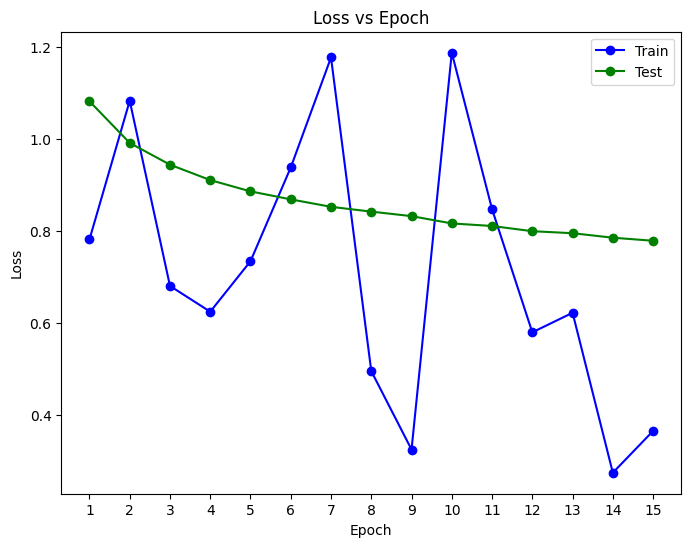

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.005531,0.004149,0.026617,0.068163,0.978170,0.987242,0.014870,0.000000
2,0.013826,0.022130,0.259929,0.421446,0.960388,0.962709,0.000000,0.000000
3,0.047010,0.049793,0.494697,0.564422,0.922492,0.924436,0.003717,0.022305
4,0.077083,0.067773,0.573716,0.600998,0.898455,0.911678,0.045539,0.096654
5,0.087798,0.099585,0.613225,0.634248,0.885946,0.896467,0.154275,0.263941
6,0.102662,0.121715,0.631940,0.633416,0.874785,0.893032,0.267658,0.375465
7,0.115105,0.117566,0.639218,0.659185,0.869144,0.881747,0.373606,0.460967
8,0.124438,0.123098,0.652734,0.664173,0.863012,0.874877,0.436803,0.524164
9,0.133771,0.106501,0.657933,0.654198,0.859701,0.882728,0.482342,0.568773


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.258065,1.000000,0.347826,0.482353,0.486846,0.495933,0.134454,0.000000
2,0.588235,0.615385,0.568699,0.629032,0.534576,0.577568,0.000000,0.000000
3,0.490975,0.433735,0.581663,0.600354,0.599649,0.626747,0.190476,0.461538
4,0.477516,0.445455,0.585030,0.607053,0.627979,0.643129,0.590361,0.604651
5,0.459313,0.431138,0.599268,0.617814,0.644195,0.668496,0.680328,0.724490
6,0.463339,0.442211,0.608043,0.641414,0.656270,0.672579,0.679245,0.721429
7,0.450000,0.452128,0.621764,0.637973,0.665009,0.683530,0.680203,0.716763
8,0.471204,0.451777,0.626422,0.641767,0.673011,0.687886,0.670471,0.708543
9,0.469091,0.461078,0.630907,0.645082,0.679725,0.683770,0.666239,0.711628


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.005531,0.004149,0.026617,0.068163,0.978170,0.987242,0.014870,0.000000
2,0.013826,0.022130,0.259929,0.421446,0.960388,0.962709,0.000000,0.000000
3,0.047010,0.049793,0.494697,0.564422,0.922492,0.924436,0.003717,0.022305
4,0.077083,0.067773,0.573716,0.600998,0.898455,0.911678,0.045539,0.096654
5,0.087798,0.099585,0.613225,0.634248,0.885946,0.896467,0.154275,0.263941
6,0.102662,0.121715,0.631940,0.633416,0.874785,0.893032,0.267658,0.375465
7,0.115105,0.117566,0.639218,0.659185,0.869144,0.881747,0.373606,0.460967
8,0.124438,0.123098,0.652734,0.664173,0.863012,0.874877,0.436803,0.524164
9,0.133771,0.106501,0.657933,0.654198,0.859701,0.882728,0.482342,0.568773


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.010829,0.008264,0.049449,0.119446,0.650120,0.660213,0.026778,0.000000
2,0.027018,0.042724,0.356786,0.504729,0.686839,0.721987,0.000000,0.000000
3,0.085804,0.089330,0.534667,0.581834,0.726834,0.747026,0.007293,0.042553
4,0.132738,0.117647,0.579318,0.604010,0.739253,0.754211,0.084556,0.166667
5,0.147417,0.161798,0.606166,0.625923,0.745973,0.765877,0.251515,0.386921
6,0.168081,0.190889,0.619761,0.637390,0.749934,0.767285,0.384000,0.493888
7,0.183320,0.186608,0.630370,0.648406,0.753495,0.770088,0.482304,0.561086
8,0.196883,0.193478,0.639308,0.652778,0.756260,0.770194,0.528981,0.602564
9,0.208176,0.173034,0.644137,0.649608,0.759192,0.770615,0.559569,0.632231


### Gráfico ROC para cada clase

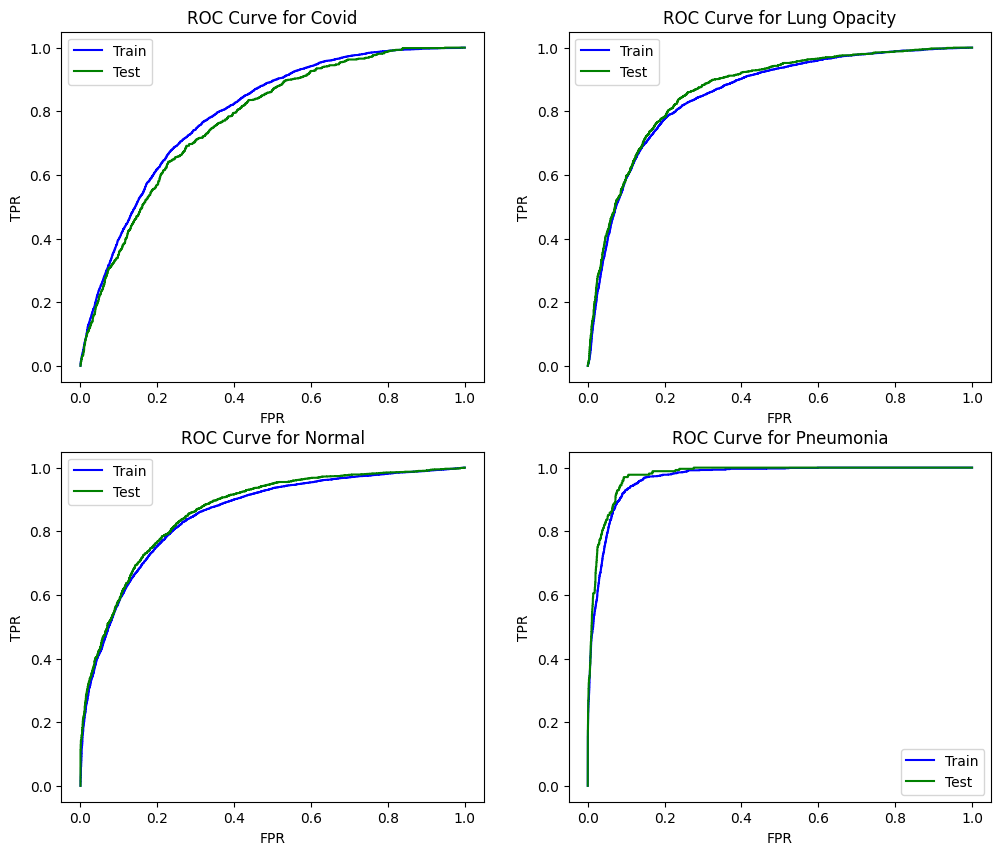

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 3 - MLP con regularización
## Sin Feature Extractor

## Arquitectura del modelo

In [ ]:
class MLP_reg(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5, weight_decay=0.01):
        super(MLP_reg, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay

        # Capa de entrada
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()

        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            hidden_layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden_layers.append(hidden_layer)

        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        # Regularización L2
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def calculate_l2_loss(self):
        l2_loss = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return l2_loss * self.weight_decay

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-4
momentum = 0.2
epochs = 15

unfiltered_reg_mlp_model = MLP_reg(250*250, [512, 256], 4, 0.5, 0.01) .to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_reg_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_reg_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_reg_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.367575  [   32/16932]
Current Loss: 1.364093  [  352/16932]
Current Loss: 1.341577  [  672/16932]
Current Loss: 1.328855  [  992/16932]
Current Loss: 1.329021  [ 1312/16932]
Current Loss: 1.322504  [ 1632/16932]
Current Loss: 1.321253  [ 1952/16932]
Current Loss: 1.276587  [ 2272/16932]
Current Loss: 1.305356  [ 2592/16932]
Current Loss: 1.308076  [ 2912/16932]
Current Loss: 1.254331  [ 3232/16932]
Current Loss: 1.252153  [ 3552/16932]
Current Loss: 1.254084  [ 3872/16932]
Current Loss: 1.256459  [ 4192/16932]
Current Loss: 1.227732  [ 4512/16932]
Current Loss: 1.204617  [ 4832/16932]
Current Loss: 1.280340  [ 5152/16932]
Current Loss: 1.142116  [ 5472/16932]
Current Loss: 1.289247  [ 5792/16932]
Current Loss: 1.279886  [ 6112/16932]
Current Loss: 1.212270  [ 6432/16932]
Current Loss: 1.245229  [ 6752/16932]
Current Loss: 1.252750  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.009682,0.171239,0.987242,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.042297  [   32/16932]
Current Loss: 0.987051  [  352/16932]
Current Loss: 1.121985  [  672/16932]
Current Loss: 1.169998  [  992/16932]
Current Loss: 1.161984  [ 1312/16932]
Current Loss: 1.042404  [ 1632/16932]
Current Loss: 1.043813  [ 1952/16932]
Current Loss: 0.949493  [ 2272/16932]
Current Loss: 1.168766  [ 2592/16932]
Current Loss: 1.032521  [ 2912/16932]
Current Loss: 1.084915  [ 3232/16932]
Current Loss: 1.033856  [ 3552/16932]
Current Loss: 0.988017  [ 3872/16932]
Current Loss: 1.038942  [ 4192/16932]
Current Loss: 0.966413  [ 4512/16932]
Current Loss: 0.946541  [ 4832/16932]
Current Loss: 0.930894  [ 5152/16932]
Current Loss: 1.056176  [ 5472/16932]
Current Loss: 0.963200  [ 5792/16932]
Current Loss: 1.098001  [ 6112/16932]
Current Loss: 1.153618  [ 6432/16932]
Current Loss: 1.094548  [ 6752/16932]
Current Loss: 1.088207  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.015214,0.481297,0.965162,0.018587


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.930283  [   32/16932]
Current Loss: 1.047480  [  352/16932]
Current Loss: 0.989687  [  672/16932]
Current Loss: 0.968444  [  992/16932]
Current Loss: 0.843788  [ 1312/16932]
Current Loss: 1.057303  [ 1632/16932]
Current Loss: 0.953391  [ 1952/16932]
Current Loss: 0.978070  [ 2272/16932]
Current Loss: 0.986038  [ 2592/16932]
Current Loss: 1.060354  [ 2912/16932]
Current Loss: 1.062637  [ 3232/16932]
Current Loss: 1.071531  [ 3552/16932]
Current Loss: 1.134455  [ 3872/16932]
Current Loss: 1.052223  [ 4192/16932]
Current Loss: 1.010231  [ 4512/16932]
Current Loss: 1.033327  [ 4832/16932]
Current Loss: 1.106721  [ 5152/16932]
Current Loss: 1.083277  [ 5472/16932]
Current Loss: 1.020987  [ 5792/16932]
Current Loss: 0.897248  [ 6112/16932]
Current Loss: 1.008040  [ 6432/16932]
Current Loss: 0.917446  [ 6752/16932]
Current Loss: 0.889103  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.042877,0.577722,0.933759,0.159851


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.957325  [   32/16932]
Current Loss: 1.070617  [  352/16932]
Current Loss: 0.974344  [  672/16932]
Current Loss: 0.969142  [  992/16932]
Current Loss: 0.838788  [ 1312/16932]
Current Loss: 0.898116  [ 1632/16932]
Current Loss: 0.998441  [ 1952/16932]
Current Loss: 0.804911  [ 2272/16932]
Current Loss: 0.985149  [ 2592/16932]
Current Loss: 0.996937  [ 2912/16932]
Current Loss: 1.085666  [ 3232/16932]
Current Loss: 1.080607  [ 3552/16932]
Current Loss: 0.888114  [ 3872/16932]
Current Loss: 0.935233  [ 4192/16932]
Current Loss: 0.906433  [ 4512/16932]
Current Loss: 0.958821  [ 4832/16932]
Current Loss: 0.989924  [ 5152/16932]
Current Loss: 0.924098  [ 5472/16932]
Current Loss: 0.863655  [ 5792/16932]
Current Loss: 0.972803  [ 6112/16932]
Current Loss: 0.864482  [ 6432/16932]
Current Loss: 0.830651  [ 6752/16932]
Current Loss: 1.010161  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.077455,0.58936,0.923945,0.33829


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.937207  [   32/16932]
Current Loss: 0.777433  [  352/16932]
Current Loss: 0.969064  [  672/16932]
Current Loss: 0.756892  [  992/16932]
Current Loss: 1.058860  [ 1312/16932]
Current Loss: 0.751920  [ 1632/16932]
Current Loss: 1.037922  [ 1952/16932]
Current Loss: 0.781175  [ 2272/16932]
Current Loss: 0.830224  [ 2592/16932]
Current Loss: 0.843805  [ 2912/16932]
Current Loss: 0.917046  [ 3232/16932]
Current Loss: 0.836472  [ 3552/16932]
Current Loss: 1.023511  [ 3872/16932]
Current Loss: 0.880772  [ 4192/16932]
Current Loss: 0.854032  [ 4512/16932]
Current Loss: 0.886480  [ 4832/16932]
Current Loss: 1.107693  [ 5152/16932]
Current Loss: 0.903202  [ 5472/16932]
Current Loss: 1.038240  [ 5792/16932]
Current Loss: 0.910721  [ 6112/16932]
Current Loss: 0.895070  [ 6432/16932]
Current Loss: 0.925502  [ 6752/16932]
Current Loss: 0.845955  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.087137,0.63591,0.899902,0.446097


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.110218  [   32/16932]
Current Loss: 0.820214  [  352/16932]
Current Loss: 1.019857  [  672/16932]
Current Loss: 0.967746  [  992/16932]
Current Loss: 0.874217  [ 1312/16932]
Current Loss: 0.943472  [ 1632/16932]
Current Loss: 0.882224  [ 1952/16932]
Current Loss: 0.832370  [ 2272/16932]
Current Loss: 0.802333  [ 2592/16932]
Current Loss: 0.890133  [ 2912/16932]
Current Loss: 0.897129  [ 3232/16932]
Current Loss: 1.137229  [ 3552/16932]
Current Loss: 0.732078  [ 3872/16932]
Current Loss: 0.918670  [ 4192/16932]
Current Loss: 0.797938  [ 4512/16932]
Current Loss: 1.035071  [ 4832/16932]
Current Loss: 0.919658  [ 5152/16932]
Current Loss: 0.794230  [ 5472/16932]
Current Loss: 1.046935  [ 5792/16932]
Current Loss: 0.976107  [ 6112/16932]
Current Loss: 0.926398  [ 6432/16932]
Current Loss: 0.619342  [ 6752/16932]
Current Loss: 0.755858  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.08852,0.659185,0.892051,0.513011


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.964304  [   32/16932]
Current Loss: 0.848917  [  352/16932]
Current Loss: 1.029627  [  672/16932]
Current Loss: 0.856169  [  992/16932]
Current Loss: 0.997643  [ 1312/16932]
Current Loss: 0.886487  [ 1632/16932]
Current Loss: 0.865086  [ 1952/16932]
Current Loss: 0.840826  [ 2272/16932]
Current Loss: 0.974524  [ 2592/16932]
Current Loss: 0.909982  [ 2912/16932]
Current Loss: 0.808440  [ 3232/16932]
Current Loss: 1.071444  [ 3552/16932]
Current Loss: 1.100698  [ 3872/16932]
Current Loss: 0.923548  [ 4192/16932]
Current Loss: 0.960493  [ 4512/16932]
Current Loss: 0.854410  [ 4832/16932]
Current Loss: 0.777851  [ 5152/16932]
Current Loss: 0.914231  [ 5472/16932]
Current Loss: 0.898133  [ 5792/16932]
Current Loss: 1.211897  [ 6112/16932]
Current Loss: 0.723648  [ 6432/16932]
Current Loss: 0.789632  [ 6752/16932]
Current Loss: 0.894528  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.084371,0.636741,0.900883,0.546468


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.792415  [   32/16932]
Current Loss: 0.739465  [  352/16932]
Current Loss: 0.737069  [  672/16932]
Current Loss: 0.881232  [  992/16932]
Current Loss: 0.747410  [ 1312/16932]
Current Loss: 0.660658  [ 1632/16932]
Current Loss: 0.731162  [ 1952/16932]
Current Loss: 0.848352  [ 2272/16932]
Current Loss: 0.872338  [ 2592/16932]
Current Loss: 0.926227  [ 2912/16932]
Current Loss: 1.013887  [ 3232/16932]
Current Loss: 0.754880  [ 3552/16932]
Current Loss: 0.905746  [ 3872/16932]
Current Loss: 0.912416  [ 4192/16932]
Current Loss: 0.813511  [ 4512/16932]
Current Loss: 0.832353  [ 4832/16932]
Current Loss: 0.540790  [ 5152/16932]
Current Loss: 0.953040  [ 5472/16932]
Current Loss: 0.882525  [ 5792/16932]
Current Loss: 0.709776  [ 6112/16932]
Current Loss: 0.866619  [ 6432/16932]
Current Loss: 0.679383  [ 6752/16932]
Current Loss: 0.777939  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.094053,0.645054,0.89843,0.605948


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.709483  [   32/16932]
Current Loss: 0.905200  [  352/16932]
Current Loss: 0.881403  [  672/16932]
Current Loss: 0.796126  [  992/16932]
Current Loss: 0.907905  [ 1312/16932]
Current Loss: 0.853182  [ 1632/16932]
Current Loss: 0.753416  [ 1952/16932]
Current Loss: 0.832085  [ 2272/16932]
Current Loss: 0.802587  [ 2592/16932]
Current Loss: 0.931392  [ 2912/16932]
Current Loss: 0.871881  [ 3232/16932]
Current Loss: 1.216150  [ 3552/16932]
Current Loss: 0.862224  [ 3872/16932]
Current Loss: 0.984982  [ 4192/16932]
Current Loss: 0.841764  [ 4512/16932]
Current Loss: 1.019606  [ 4832/16932]
Current Loss: 0.936120  [ 5152/16932]
Current Loss: 0.900964  [ 5472/16932]
Current Loss: 0.848351  [ 5792/16932]
Current Loss: 0.640259  [ 6112/16932]
Current Loss: 0.757591  [ 6432/16932]
Current Loss: 0.631767  [ 6752/16932]
Current Loss: 0.966633  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.109267,0.664173,0.881747,0.635688


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.038287  [   32/16932]
Current Loss: 0.879837  [  352/16932]
Current Loss: 1.122093  [  672/16932]
Current Loss: 0.832056  [  992/16932]
Current Loss: 0.938661  [ 1312/16932]
Current Loss: 0.902591  [ 1632/16932]
Current Loss: 0.907304  [ 1952/16932]
Current Loss: 0.873784  [ 2272/16932]
Current Loss: 0.853933  [ 2592/16932]
Current Loss: 0.934220  [ 2912/16932]
Current Loss: 0.906944  [ 3232/16932]
Current Loss: 0.731750  [ 3552/16932]
Current Loss: 0.696767  [ 3872/16932]
Current Loss: 0.944554  [ 4192/16932]
Current Loss: 0.743107  [ 4512/16932]
Current Loss: 1.010417  [ 4832/16932]
Current Loss: 0.902028  [ 5152/16932]
Current Loss: 0.935929  [ 5472/16932]
Current Loss: 0.899450  [ 5792/16932]
Current Loss: 0.906219  [ 6112/16932]
Current Loss: 0.887565  [ 6432/16932]
Current Loss: 0.716175  [ 6752/16932]
Current Loss: 0.835162  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.094053,0.651704,0.899411,0.654275


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.991683  [   32/16932]
Current Loss: 0.653213  [  352/16932]
Current Loss: 0.661887  [  672/16932]
Current Loss: 0.809509  [  992/16932]
Current Loss: 0.634134  [ 1312/16932]
Current Loss: 1.180959  [ 1632/16932]
Current Loss: 0.849533  [ 1952/16932]
Current Loss: 0.777286  [ 2272/16932]
Current Loss: 0.731981  [ 2592/16932]
Current Loss: 0.716625  [ 2912/16932]
Current Loss: 0.705554  [ 3232/16932]
Current Loss: 0.855548  [ 3552/16932]
Current Loss: 0.763491  [ 3872/16932]
Current Loss: 0.751824  [ 4192/16932]
Current Loss: 0.886785  [ 4512/16932]
Current Loss: 0.778476  [ 4832/16932]
Current Loss: 0.857990  [ 5152/16932]
Current Loss: 0.930149  [ 5472/16932]
Current Loss: 0.766176  [ 5792/16932]
Current Loss: 0.921986  [ 6112/16932]
Current Loss: 0.702666  [ 6432/16932]
Current Loss: 0.953267  [ 6752/16932]
Current Loss: 0.848228  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.13278,0.648379,0.888616,0.687732


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.661412  [   32/16932]
Current Loss: 0.812731  [  352/16932]
Current Loss: 0.956577  [  672/16932]
Current Loss: 0.560407  [  992/16932]
Current Loss: 0.738149  [ 1312/16932]
Current Loss: 0.882403  [ 1632/16932]
Current Loss: 0.832239  [ 1952/16932]
Current Loss: 0.656535  [ 2272/16932]
Current Loss: 0.806548  [ 2592/16932]
Current Loss: 0.784232  [ 2912/16932]
Current Loss: 0.880988  [ 3232/16932]
Current Loss: 0.689554  [ 3552/16932]
Current Loss: 0.883415  [ 3872/16932]
Current Loss: 0.796658  [ 4192/16932]
Current Loss: 0.928555  [ 4512/16932]
Current Loss: 0.785830  [ 4832/16932]
Current Loss: 0.730882  [ 5152/16932]
Current Loss: 0.974882  [ 5472/16932]
Current Loss: 0.799371  [ 5792/16932]
Current Loss: 0.819504  [ 6112/16932]
Current Loss: 0.870594  [ 6432/16932]
Current Loss: 0.781356  [ 6752/16932]
Current Loss: 0.772209  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.124481,0.666667,0.884691,0.698885


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.004626  [   32/16932]
Current Loss: 0.893740  [  352/16932]
Current Loss: 1.034632  [  672/16932]
Current Loss: 0.659908  [  992/16932]
Current Loss: 0.810239  [ 1312/16932]
Current Loss: 1.027788  [ 1632/16932]
Current Loss: 0.831976  [ 1952/16932]
Current Loss: 0.633410  [ 2272/16932]
Current Loss: 1.000360  [ 2592/16932]
Current Loss: 0.651483  [ 2912/16932]
Current Loss: 0.885641  [ 3232/16932]
Current Loss: 0.858024  [ 3552/16932]
Current Loss: 0.839033  [ 3872/16932]
Current Loss: 0.897808  [ 4192/16932]
Current Loss: 0.969877  [ 4512/16932]
Current Loss: 0.974164  [ 4832/16932]
Current Loss: 0.805494  [ 5152/16932]
Current Loss: 0.688769  [ 5472/16932]
Current Loss: 0.901281  [ 5792/16932]
Current Loss: 0.671333  [ 6112/16932]
Current Loss: 0.696747  [ 6432/16932]
Current Loss: 0.753950  [ 6752/16932]
Current Loss: 0.896542  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.136929,0.658354,0.885182,0.713755


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.055162  [   32/16932]
Current Loss: 0.945962  [  352/16932]
Current Loss: 0.710139  [  672/16932]
Current Loss: 0.784468  [  992/16932]
Current Loss: 0.877643  [ 1312/16932]
Current Loss: 0.992745  [ 1632/16932]
Current Loss: 0.923532  [ 1952/16932]
Current Loss: 0.831836  [ 2272/16932]
Current Loss: 0.793710  [ 2592/16932]
Current Loss: 0.667619  [ 2912/16932]
Current Loss: 0.900331  [ 3232/16932]
Current Loss: 0.708904  [ 3552/16932]
Current Loss: 0.688915  [ 3872/16932]
Current Loss: 0.700111  [ 4192/16932]
Current Loss: 0.829366  [ 4512/16932]
Current Loss: 0.743992  [ 4832/16932]
Current Loss: 0.709593  [ 5152/16932]
Current Loss: 0.614597  [ 5472/16932]
Current Loss: 0.949134  [ 5792/16932]
Current Loss: 0.677690  [ 6112/16932]
Current Loss: 0.661511  [ 6432/16932]
Current Loss: 0.953559  [ 6752/16932]
Current Loss: 0.717248  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.134163,0.65586,0.890579,0.72119


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.750875  [   32/16932]
Current Loss: 0.743312  [  352/16932]
Current Loss: 0.827131  [  672/16932]
Current Loss: 0.771292  [  992/16932]
Current Loss: 0.640376  [ 1312/16932]
Current Loss: 0.708682  [ 1632/16932]
Current Loss: 0.843311  [ 1952/16932]
Current Loss: 1.038983  [ 2272/16932]
Current Loss: 0.754095  [ 2592/16932]
Current Loss: 0.729420  [ 2912/16932]
Current Loss: 0.778882  [ 3232/16932]
Current Loss: 0.632500  [ 3552/16932]
Current Loss: 0.611816  [ 3872/16932]
Current Loss: 0.970417  [ 4192/16932]
Current Loss: 0.816858  [ 4512/16932]
Current Loss: 0.721728  [ 4832/16932]
Current Loss: 0.926225  [ 5152/16932]
Current Loss: 1.040466  [ 5472/16932]
Current Loss: 0.742851  [ 5792/16932]
Current Loss: 0.856681  [ 6112/16932]
Current Loss: 0.576570  [ 6432/16932]
Current Loss: 0.767688  [ 6752/16932]
Current Loss: 0.819972  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.147994,0.664173,0.882728,0.728625


Training time: 19.100 minutes


## Evaluación del modelo

### Curva de entrenamiento

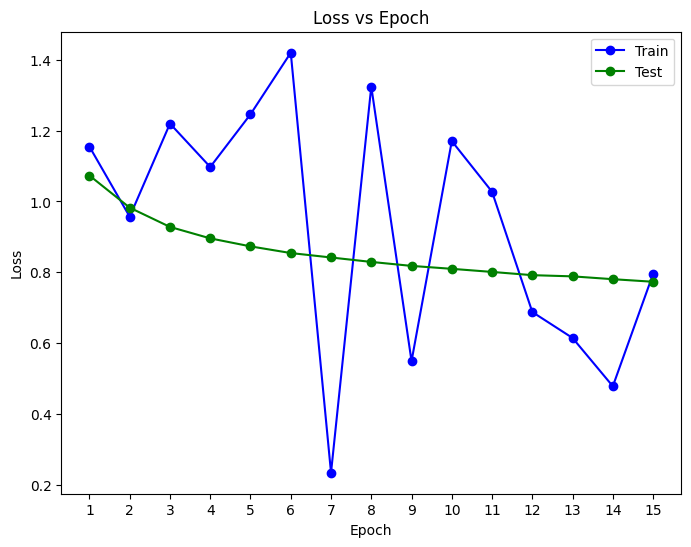

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.018697,0.009682,0.188707,0.171239,0.921872,0.987242,0.000000,0.000000
2,0.011753,0.015214,0.325431,0.481297,0.960755,0.965162,0.007435,0.018587
3,0.040097,0.042877,0.501560,0.577722,0.929482,0.933759,0.078996,0.159851
4,0.070861,0.077455,0.570597,0.589360,0.898700,0.923945,0.215613,0.338290
5,0.091600,0.087137,0.597422,0.635910,0.885087,0.899902,0.328996,0.446097
6,0.099551,0.088520,0.608235,0.659185,0.873559,0.892051,0.426580,0.513011
7,0.120982,0.084371,0.630900,0.636741,0.863380,0.900883,0.480483,0.546468
8,0.122710,0.094053,0.630692,0.645054,0.865710,0.898430,0.518587,0.605948
9,0.132043,0.109267,0.633396,0.664173,0.860804,0.881747,0.553903,0.635688


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.222488,0.875000,0.456522,0.664516,0.511960,0.514052,0.000000,0.000000
2,0.295652,0.407407,0.618333,0.662471,0.548907,0.591757,0.571429,0.625000
3,0.374194,0.407895,0.621169,0.631818,0.599937,0.633489,0.801887,0.811321
4,0.374771,0.411765,0.612227,0.646308,0.631343,0.651332,0.783784,0.834862
5,0.402124,0.398734,0.617186,0.644482,0.646974,0.670322,0.764579,0.789474
6,0.385027,0.410256,0.621547,0.646292,0.655772,0.680644,0.745130,0.770950
7,0.426309,0.398693,0.625954,0.654701,0.666856,0.675745,0.731259,0.761658
8,0.441542,0.433121,0.632534,0.664953,0.669036,0.679406,0.713555,0.761682
9,0.434585,0.451429,0.640858,0.661424,0.671482,0.685878,0.703660,0.743478


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.018697,0.009682,0.188707,0.171239,0.921872,0.987242,0.000000,0.000000
2,0.011753,0.015214,0.325431,0.481297,0.960755,0.965162,0.007435,0.018587
3,0.040097,0.042877,0.501560,0.577722,0.929482,0.933759,0.078996,0.159851
4,0.070861,0.077455,0.570597,0.589360,0.898700,0.923945,0.215613,0.338290
5,0.091600,0.087137,0.597422,0.635910,0.885087,0.899902,0.328996,0.446097
6,0.099551,0.088520,0.608235,0.659185,0.873559,0.892051,0.426580,0.513011
7,0.120982,0.084371,0.630900,0.636741,0.863380,0.900883,0.480483,0.546468
8,0.122710,0.094053,0.630692,0.645054,0.865710,0.898430,0.518587,0.605948
9,0.132043,0.109267,0.633396,0.664173,0.860804,0.881747,0.553903,0.635688


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.034496,0.019152,0.267033,0.272307,0.658322,0.676075,0.000000,0.000000
2,0.022606,0.029333,0.426431,0.557535,0.698653,0.733681,0.014679,0.036101
3,0.072432,0.077597,0.554993,0.603561,0.729206,0.754859,0.143824,0.267081
4,0.119186,0.130384,0.590679,0.616522,0.741663,0.764050,0.338192,0.481481
5,0.149212,0.143019,0.607143,0.640167,0.747527,0.768328,0.460039,0.570071
6,0.158198,0.145620,0.614819,0.652675,0.749159,0.772138,0.542553,0.616071
7,0.188476,0.139269,0.628418,0.645596,0.752499,0.772240,0.579921,0.636364
8,0.192048,0.154545,0.631612,0.654852,0.754771,0.773716,0.600646,0.674948
9,0.202545,0.175947,0.637105,0.662796,0.754447,0.771576,0.619865,0.685371


### Gráfico ROC para cada clase

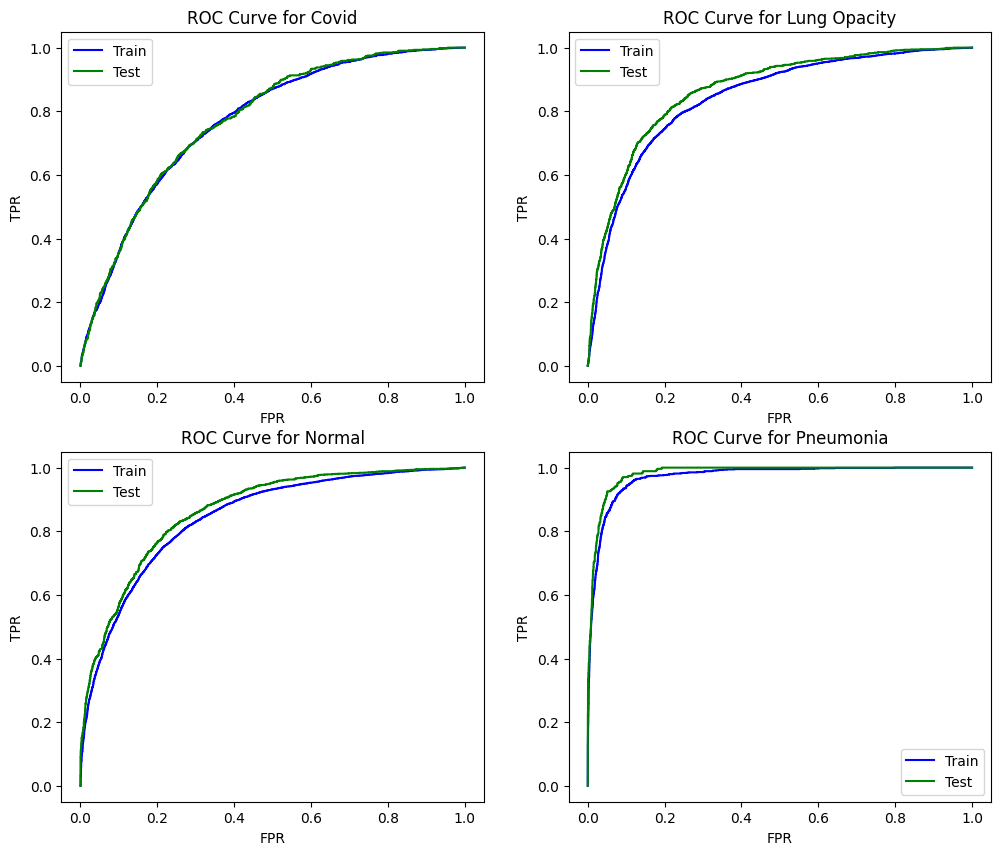

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 3 - MLP con regularización
## Con Feature Extractor

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-4
momentum = 0.2
epochs = 15

feature_extracted_reg_mlp_model = MLP_reg(250*250, [512, 256], 4, 0.5, 0.01) .to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_reg_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_reg_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_reg_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.385110  [   32/16932]
Current Loss: 1.385105  [  352/16932]
Current Loss: 1.376185  [  672/16932]
Current Loss: 1.335279  [  992/16932]
Current Loss: 1.385250  [ 1312/16932]
Current Loss: 1.321822  [ 1632/16932]
Current Loss: 1.343714  [ 1952/16932]
Current Loss: 1.332061  [ 2272/16932]
Current Loss: 1.317825  [ 2592/16932]
Current Loss: 1.328623  [ 2912/16932]
Current Loss: 1.324305  [ 3232/16932]
Current Loss: 1.247969  [ 3552/16932]
Current Loss: 1.288507  [ 3872/16932]
Current Loss: 1.329311  [ 4192/16932]
Current Loss: 1.292132  [ 4512/16932]
Current Loss: 1.313336  [ 4832/16932]
Current Loss: 1.274863  [ 5152/16932]
Current Loss: 1.308846  [ 5472/16932]
Current Loss: 1.284809  [ 5792/16932]
Current Loss: 1.254472  [ 6112/16932]
Current Loss: 1.220587  [ 6432/16932]
Current Loss: 1.231743  [ 6752/16932]
Current Loss: 1.250049  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.001383,0.119701,0.984298,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.081544  [   32/16932]
Current Loss: 0.966166  [  352/16932]
Current Loss: 1.102942  [  672/16932]
Current Loss: 1.013826  [  992/16932]
Current Loss: 1.064999  [ 1312/16932]
Current Loss: 1.176899  [ 1632/16932]
Current Loss: 1.239992  [ 1952/16932]
Current Loss: 1.022651  [ 2272/16932]
Current Loss: 1.064231  [ 2592/16932]
Current Loss: 0.944604  [ 2912/16932]
Current Loss: 0.989948  [ 3232/16932]
Current Loss: 0.789160  [ 3552/16932]
Current Loss: 1.032568  [ 3872/16932]
Current Loss: 0.945044  [ 4192/16932]
Current Loss: 0.973011  [ 4512/16932]
Current Loss: 1.068201  [ 4832/16932]
Current Loss: 1.025006  [ 5152/16932]
Current Loss: 1.138404  [ 5472/16932]
Current Loss: 1.247314  [ 5792/16932]
Current Loss: 1.210925  [ 6112/16932]
Current Loss: 1.076384  [ 6432/16932]
Current Loss: 1.057149  [ 6752/16932]
Current Loss: 0.935289  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.011065,0.472153,0.950442,0.0


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.934507  [   32/16932]
Current Loss: 0.970845  [  352/16932]
Current Loss: 0.962016  [  672/16932]
Current Loss: 1.025509  [  992/16932]
Current Loss: 1.166191  [ 1312/16932]
Current Loss: 1.056203  [ 1632/16932]
Current Loss: 1.067287  [ 1952/16932]
Current Loss: 0.985061  [ 2272/16932]
Current Loss: 1.120859  [ 2592/16932]
Current Loss: 0.981747  [ 2912/16932]
Current Loss: 0.989191  [ 3232/16932]
Current Loss: 0.801982  [ 3552/16932]
Current Loss: 1.208603  [ 3872/16932]
Current Loss: 0.978727  [ 4192/16932]
Current Loss: 0.997432  [ 4512/16932]
Current Loss: 0.878475  [ 4832/16932]
Current Loss: 0.949458  [ 5152/16932]
Current Loss: 0.908429  [ 5472/16932]
Current Loss: 1.018931  [ 5792/16932]
Current Loss: 0.816562  [ 6112/16932]
Current Loss: 0.933917  [ 6432/16932]
Current Loss: 0.939486  [ 6752/16932]
Current Loss: 1.126716  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.027663,0.561929,0.933268,0.033457


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.180563  [   32/16932]
Current Loss: 0.982069  [  352/16932]
Current Loss: 0.867306  [  672/16932]
Current Loss: 1.108120  [  992/16932]
Current Loss: 0.959634  [ 1312/16932]
Current Loss: 0.877593  [ 1632/16932]
Current Loss: 0.951755  [ 1952/16932]
Current Loss: 0.760369  [ 2272/16932]
Current Loss: 0.976263  [ 2592/16932]
Current Loss: 0.744271  [ 2912/16932]
Current Loss: 1.009938  [ 3232/16932]
Current Loss: 0.780776  [ 3552/16932]
Current Loss: 0.831530  [ 3872/16932]
Current Loss: 1.109808  [ 4192/16932]
Current Loss: 1.015265  [ 4512/16932]
Current Loss: 0.659041  [ 4832/16932]
Current Loss: 1.053945  [ 5152/16932]
Current Loss: 1.055112  [ 5472/16932]
Current Loss: 0.922470  [ 5792/16932]
Current Loss: 0.969623  [ 6112/16932]
Current Loss: 0.910869  [ 6432/16932]
Current Loss: 1.082615  [ 6752/16932]
Current Loss: 1.065461  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.031812,0.620948,0.909225,0.133829


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.986468  [   32/16932]
Current Loss: 0.905196  [  352/16932]
Current Loss: 0.950845  [  672/16932]
Current Loss: 1.105309  [  992/16932]
Current Loss: 0.770379  [ 1312/16932]
Current Loss: 1.361236  [ 1632/16932]
Current Loss: 0.961531  [ 1952/16932]
Current Loss: 1.082963  [ 2272/16932]
Current Loss: 0.852481  [ 2592/16932]
Current Loss: 1.018457  [ 2912/16932]
Current Loss: 0.867353  [ 3232/16932]
Current Loss: 0.999013  [ 3552/16932]
Current Loss: 1.160330  [ 3872/16932]
Current Loss: 0.765586  [ 4192/16932]
Current Loss: 0.751554  [ 4512/16932]
Current Loss: 0.993218  [ 4832/16932]
Current Loss: 0.839977  [ 5152/16932]
Current Loss: 0.988231  [ 5472/16932]
Current Loss: 1.071205  [ 5792/16932]
Current Loss: 1.013493  [ 6112/16932]
Current Loss: 0.887460  [ 6432/16932]
Current Loss: 0.966807  [ 6752/16932]
Current Loss: 0.840295  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.069156,0.620948,0.903337,0.289963


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.871882  [   32/16932]
Current Loss: 0.874580  [  352/16932]
Current Loss: 0.986523  [  672/16932]
Current Loss: 1.092327  [  992/16932]
Current Loss: 0.845318  [ 1312/16932]
Current Loss: 1.109751  [ 1632/16932]
Current Loss: 0.890612  [ 1952/16932]
Current Loss: 0.843024  [ 2272/16932]
Current Loss: 0.879176  [ 2592/16932]
Current Loss: 0.846661  [ 2912/16932]
Current Loss: 0.836653  [ 3232/16932]
Current Loss: 0.699741  [ 3552/16932]
Current Loss: 1.048555  [ 3872/16932]
Current Loss: 0.950967  [ 4192/16932]
Current Loss: 0.887811  [ 4512/16932]
Current Loss: 0.863555  [ 4832/16932]
Current Loss: 0.727140  [ 5152/16932]
Current Loss: 0.942916  [ 5472/16932]
Current Loss: 0.921587  [ 5792/16932]
Current Loss: 1.112408  [ 6112/16932]
Current Loss: 1.022683  [ 6432/16932]
Current Loss: 1.086658  [ 6752/16932]
Current Loss: 0.883598  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.074689,0.653367,0.89156,0.412639


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.687377  [   32/16932]
Current Loss: 0.874053  [  352/16932]
Current Loss: 1.045320  [  672/16932]
Current Loss: 0.776488  [  992/16932]
Current Loss: 0.633518  [ 1312/16932]
Current Loss: 1.029464  [ 1632/16932]
Current Loss: 0.921789  [ 1952/16932]
Current Loss: 0.923592  [ 2272/16932]
Current Loss: 0.770668  [ 2592/16932]
Current Loss: 0.830144  [ 2912/16932]
Current Loss: 0.697846  [ 3232/16932]
Current Loss: 0.705980  [ 3552/16932]
Current Loss: 0.754713  [ 3872/16932]
Current Loss: 0.859059  [ 4192/16932]
Current Loss: 0.869276  [ 4512/16932]
Current Loss: 0.866021  [ 4832/16932]
Current Loss: 0.735633  [ 5152/16932]
Current Loss: 0.920454  [ 5472/16932]
Current Loss: 0.987514  [ 5792/16932]
Current Loss: 0.816297  [ 6112/16932]
Current Loss: 0.841346  [ 6432/16932]
Current Loss: 0.868602  [ 6752/16932]
Current Loss: 1.225656  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.082988,0.651704,0.890088,0.483271


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.908642  [   32/16932]
Current Loss: 0.864807  [  352/16932]
Current Loss: 0.846093  [  672/16932]
Current Loss: 0.892883  [  992/16932]
Current Loss: 0.842643  [ 1312/16932]
Current Loss: 0.804499  [ 1632/16932]
Current Loss: 0.875226  [ 1952/16932]
Current Loss: 0.876575  [ 2272/16932]
Current Loss: 0.896815  [ 2592/16932]
Current Loss: 1.109540  [ 2912/16932]
Current Loss: 0.670837  [ 3232/16932]
Current Loss: 0.782947  [ 3552/16932]
Current Loss: 0.725960  [ 3872/16932]
Current Loss: 1.071020  [ 4192/16932]
Current Loss: 0.966248  [ 4512/16932]
Current Loss: 0.791777  [ 4832/16932]
Current Loss: 0.815429  [ 5152/16932]
Current Loss: 1.122427  [ 5472/16932]
Current Loss: 0.878736  [ 5792/16932]
Current Loss: 1.020072  [ 6112/16932]
Current Loss: 0.787191  [ 6432/16932]
Current Loss: 1.012702  [ 6752/16932]
Current Loss: 0.920787  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.074689,0.657523,0.89156,0.546468


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.890260  [   32/16932]
Current Loss: 1.055182  [  352/16932]
Current Loss: 0.919660  [  672/16932]
Current Loss: 0.864866  [  992/16932]
Current Loss: 1.001756  [ 1312/16932]
Current Loss: 0.940726  [ 1632/16932]
Current Loss: 0.973477  [ 1952/16932]
Current Loss: 0.834830  [ 2272/16932]
Current Loss: 0.947809  [ 2592/16932]
Current Loss: 0.929947  [ 2912/16932]
Current Loss: 0.625771  [ 3232/16932]
Current Loss: 0.729446  [ 3552/16932]
Current Loss: 0.898155  [ 3872/16932]
Current Loss: 0.984449  [ 4192/16932]
Current Loss: 0.785256  [ 4512/16932]
Current Loss: 0.864028  [ 4832/16932]
Current Loss: 0.943626  [ 5152/16932]
Current Loss: 0.638753  [ 5472/16932]
Current Loss: 0.734020  [ 5792/16932]
Current Loss: 0.791722  [ 6112/16932]
Current Loss: 0.773659  [ 6432/16932]
Current Loss: 0.917092  [ 6752/16932]
Current Loss: 1.018877  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.089903,0.67581,0.882237,0.591078


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.795144  [   32/16932]
Current Loss: 0.792838  [  352/16932]
Current Loss: 0.802556  [  672/16932]
Current Loss: 0.904740  [  992/16932]
Current Loss: 0.890496  [ 1312/16932]
Current Loss: 0.807967  [ 1632/16932]
Current Loss: 0.777129  [ 1952/16932]
Current Loss: 0.873762  [ 2272/16932]
Current Loss: 0.893494  [ 2592/16932]
Current Loss: 0.911581  [ 2912/16932]
Current Loss: 0.898948  [ 3232/16932]
Current Loss: 0.928735  [ 3552/16932]
Current Loss: 0.908391  [ 3872/16932]
Current Loss: 1.125366  [ 4192/16932]
Current Loss: 0.873474  [ 4512/16932]
Current Loss: 1.022403  [ 4832/16932]
Current Loss: 0.877459  [ 5152/16932]
Current Loss: 1.005748  [ 5472/16932]
Current Loss: 0.696692  [ 5792/16932]
Current Loss: 0.913242  [ 6112/16932]
Current Loss: 0.860232  [ 6432/16932]
Current Loss: 0.800790  [ 6752/16932]
Current Loss: 0.879468  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.114799,0.67581,0.868008,0.6171


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.819622  [   32/16932]
Current Loss: 0.905158  [  352/16932]
Current Loss: 0.881510  [  672/16932]
Current Loss: 0.968822  [  992/16932]
Current Loss: 0.844174  [ 1312/16932]
Current Loss: 0.763686  [ 1632/16932]
Current Loss: 0.857111  [ 1952/16932]
Current Loss: 1.123361  [ 2272/16932]
Current Loss: 0.898586  [ 2592/16932]
Current Loss: 0.919453  [ 2912/16932]
Current Loss: 0.851788  [ 3232/16932]
Current Loss: 1.181500  [ 3552/16932]
Current Loss: 0.842463  [ 3872/16932]
Current Loss: 0.773472  [ 4192/16932]
Current Loss: 0.991882  [ 4512/16932]
Current Loss: 0.968628  [ 4832/16932]
Current Loss: 0.827208  [ 5152/16932]
Current Loss: 0.731348  [ 5472/16932]
Current Loss: 1.024367  [ 5792/16932]
Current Loss: 1.137848  [ 6112/16932]
Current Loss: 0.848714  [ 6432/16932]
Current Loss: 0.963239  [ 6752/16932]
Current Loss: 0.982643  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.099585,0.686617,0.870461,0.63197


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.747524  [   32/16932]
Current Loss: 1.094599  [  352/16932]
Current Loss: 0.895414  [  672/16932]
Current Loss: 1.084277  [  992/16932]
Current Loss: 0.738406  [ 1312/16932]
Current Loss: 0.820062  [ 1632/16932]
Current Loss: 0.760465  [ 1952/16932]
Current Loss: 1.034566  [ 2272/16932]
Current Loss: 0.895590  [ 2592/16932]
Current Loss: 0.850829  [ 2912/16932]
Current Loss: 0.672149  [ 3232/16932]
Current Loss: 0.830491  [ 3552/16932]
Current Loss: 0.902532  [ 3872/16932]
Current Loss: 0.708242  [ 4192/16932]
Current Loss: 0.668822  [ 4512/16932]
Current Loss: 0.898868  [ 4832/16932]
Current Loss: 0.722816  [ 5152/16932]
Current Loss: 0.823257  [ 5472/16932]
Current Loss: 0.685320  [ 5792/16932]
Current Loss: 0.641365  [ 6112/16932]
Current Loss: 0.649810  [ 6432/16932]
Current Loss: 0.793950  [ 6752/16932]
Current Loss: 0.700178  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.127248,0.661679,0.880275,0.66171


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.928482  [   32/16932]
Current Loss: 0.674838  [  352/16932]
Current Loss: 0.749409  [  672/16932]
Current Loss: 0.768936  [  992/16932]
Current Loss: 0.806553  [ 1312/16932]
Current Loss: 0.871622  [ 1632/16932]
Current Loss: 0.813227  [ 1952/16932]
Current Loss: 0.922854  [ 2272/16932]
Current Loss: 0.740222  [ 2592/16932]
Current Loss: 0.779645  [ 2912/16932]
Current Loss: 0.956475  [ 3232/16932]
Current Loss: 0.973789  [ 3552/16932]
Current Loss: 1.043822  [ 3872/16932]
Current Loss: 1.007580  [ 4192/16932]
Current Loss: 0.738922  [ 4512/16932]
Current Loss: 0.868615  [ 4832/16932]
Current Loss: 0.976117  [ 5152/16932]
Current Loss: 0.880943  [ 5472/16932]
Current Loss: 0.706375  [ 5792/16932]
Current Loss: 0.880415  [ 6112/16932]
Current Loss: 1.011909  [ 6432/16932]
Current Loss: 1.100679  [ 6752/16932]
Current Loss: 0.983873  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.149378,0.664173,0.871443,0.695167


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.869637  [   32/16932]
Current Loss: 0.976994  [  352/16932]
Current Loss: 0.667316  [  672/16932]
Current Loss: 0.718673  [  992/16932]
Current Loss: 0.918503  [ 1312/16932]
Current Loss: 0.729324  [ 1632/16932]
Current Loss: 0.872056  [ 1952/16932]
Current Loss: 0.856458  [ 2272/16932]
Current Loss: 0.822454  [ 2592/16932]
Current Loss: 0.880208  [ 2912/16932]
Current Loss: 0.669428  [ 3232/16932]
Current Loss: 0.956904  [ 3552/16932]
Current Loss: 0.802941  [ 3872/16932]
Current Loss: 0.863510  [ 4192/16932]
Current Loss: 0.925655  [ 4512/16932]
Current Loss: 0.763799  [ 4832/16932]
Current Loss: 0.753980  [ 5152/16932]
Current Loss: 0.758232  [ 5472/16932]
Current Loss: 0.958040  [ 5792/16932]
Current Loss: 0.769254  [ 6112/16932]
Current Loss: 0.845503  [ 6432/16932]
Current Loss: 0.891692  [ 6752/16932]
Current Loss: 0.867169  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.138313,0.683292,0.867027,0.698885


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.730538  [   32/16932]
Current Loss: 0.662047  [  352/16932]
Current Loss: 0.832968  [  672/16932]
Current Loss: 0.675656  [  992/16932]
Current Loss: 0.893997  [ 1312/16932]
Current Loss: 0.951338  [ 1632/16932]
Current Loss: 0.800079  [ 1952/16932]
Current Loss: 0.861845  [ 2272/16932]
Current Loss: 1.010380  [ 2592/16932]
Current Loss: 0.739013  [ 2912/16932]
Current Loss: 0.809777  [ 3232/16932]
Current Loss: 0.890236  [ 3552/16932]
Current Loss: 0.871075  [ 3872/16932]
Current Loss: 0.699332  [ 4192/16932]
Current Loss: 0.685664  [ 4512/16932]
Current Loss: 0.847290  [ 4832/16932]
Current Loss: 0.807628  [ 5152/16932]
Current Loss: 0.671130  [ 5472/16932]
Current Loss: 0.719992  [ 5792/16932]
Current Loss: 0.826214  [ 6112/16932]
Current Loss: 0.795394  [ 6432/16932]
Current Loss: 0.858497  [ 6752/16932]
Current Loss: 1.036338  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.153527,0.665835,0.876349,0.698885


Training time: 27.007 minutes


## Evaluación del modelo

### Curva de entrenamiento

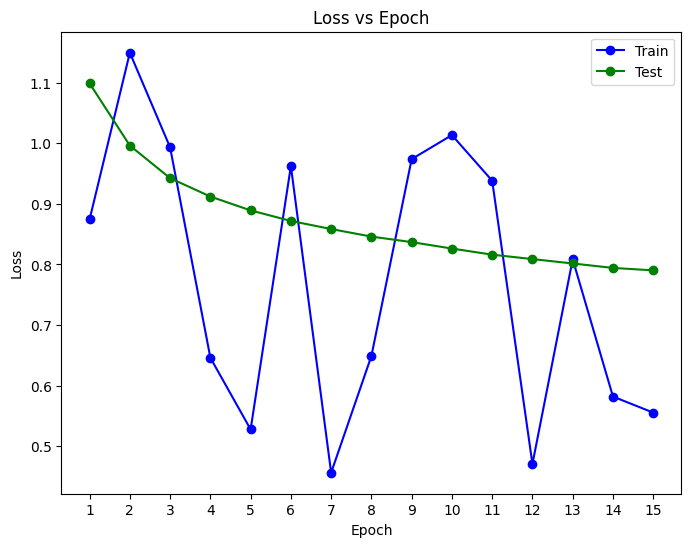

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.036295,0.001383,0.044916,0.119701,0.936963,0.984298,0.027881,0.000000
2,0.005185,0.011065,0.308172,0.472153,0.949227,0.950442,0.001859,0.000000
3,0.023159,0.027663,0.509669,0.561929,0.909492,0.933268,0.020446,0.033457
4,0.055652,0.031812,0.567062,0.620948,0.890974,0.909225,0.077138,0.133829
5,0.071552,0.069156,0.604907,0.620948,0.876380,0.903337,0.200743,0.289963
6,0.096440,0.074689,0.612601,0.653367,0.865465,0.891560,0.305762,0.412639
7,0.096094,0.082988,0.633812,0.651704,0.858352,0.890088,0.406134,0.483271
8,0.111303,0.074689,0.637347,0.657523,0.859823,0.891560,0.434015,0.546468
9,0.116142,0.089903,0.646912,0.675810,0.852220,0.882237,0.477695,0.591078


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.186170,1.000000,0.556701,0.587755,0.491129,0.504527,0.070755,0.000000
2,0.500000,0.888889,0.578906,0.617391,0.541183,0.587504,0.050000,0.000000
3,0.440789,0.540541,0.575082,0.613987,0.595519,0.618939,0.338462,0.409091
4,0.443526,0.479167,0.579719,0.605839,0.620145,0.640069,0.553333,0.631579
5,0.463087,0.485437,0.588271,0.617866,0.637751,0.654229,0.644776,0.728972
6,0.454397,0.465517,0.603565,0.625796,0.645713,0.670727,0.647638,0.730263
7,0.421851,0.476190,0.611925,0.635848,0.657739,0.673598,0.671275,0.718232
8,0.436314,0.514286,0.621704,0.646770,0.664676,0.673712,0.652235,0.706731
9,0.451613,0.500000,0.625956,0.648843,0.666955,0.684692,0.643304,0.709821


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.036295,0.001383,0.044916,0.119701,0.936963,0.984298,0.027881,0.000000
2,0.005185,0.011065,0.308172,0.472153,0.949227,0.950442,0.001859,0.000000
3,0.023159,0.027663,0.509669,0.561929,0.909492,0.933268,0.020446,0.033457
4,0.055652,0.031812,0.567062,0.620948,0.890974,0.909225,0.077138,0.133829
5,0.071552,0.069156,0.604907,0.620948,0.876380,0.903337,0.200743,0.289963
6,0.096440,0.074689,0.612601,0.653367,0.865465,0.891560,0.305762,0.412639
7,0.096094,0.082988,0.633812,0.651704,0.858352,0.890088,0.406134,0.483271
8,0.111303,0.074689,0.637347,0.657523,0.859823,0.891560,0.434015,0.546468
9,0.116142,0.089903,0.646912,0.675810,0.852220,0.882237,0.477695,0.591078


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.060746,0.002762,0.083125,0.198895,0.644454,0.667110,0.040000,0.000000
2,0.010263,0.021858,0.402226,0.535092,0.689348,0.726148,0.003584,0.000000
3,0.044007,0.052632,0.540403,0.586806,0.719755,0.744277,0.038563,0.061856
4,0.098894,0.059663,0.573321,0.613301,0.731290,0.751267,0.135400,0.220859
5,0.123952,0.121065,0.596473,0.619403,0.738261,0.758862,0.306166,0.414894
6,0.159110,0.128725,0.608050,0.639284,0.739611,0.765536,0.415404,0.527316
7,0.156532,0.141343,0.622676,0.643678,0.744773,0.766857,0.506080,0.577778
8,0.177362,0.130435,0.629428,0.652102,0.749759,0.767476,0.521205,0.616352
9,0.184768,0.152403,0.636261,0.662052,0.748291,0.771012,0.548267,0.645030


### Gráfico ROC para cada clase

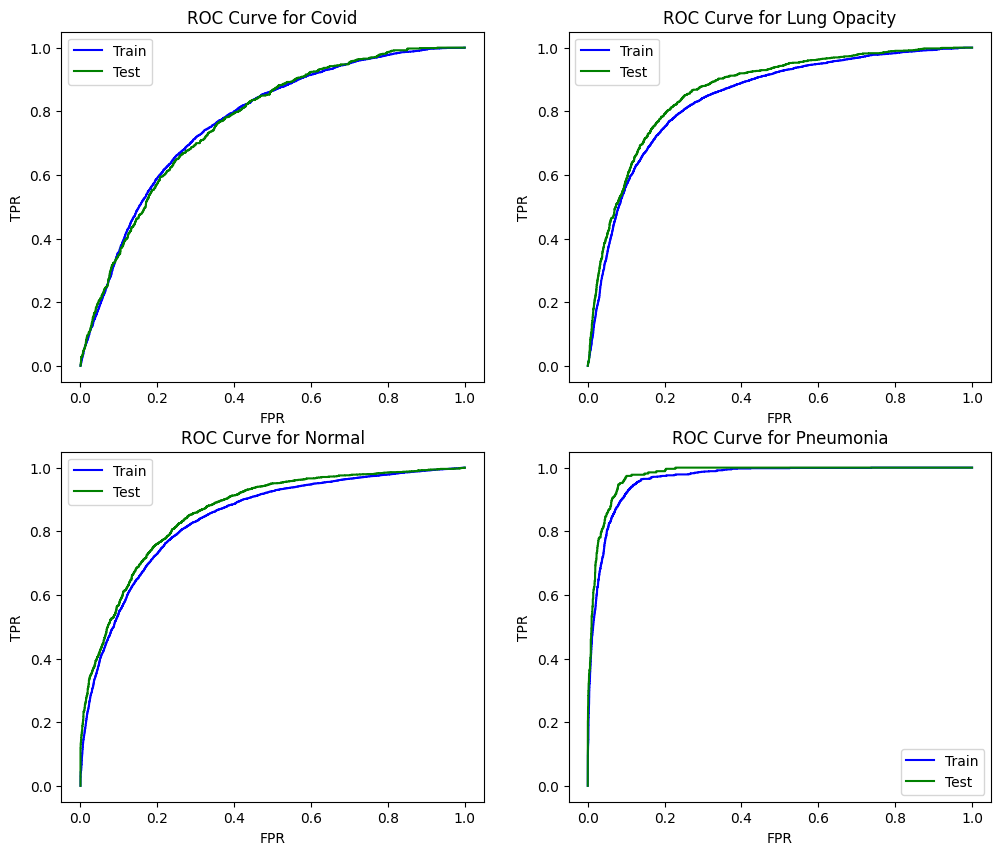

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Red Convolucional 
## Sin Bilateral Filter

## Arquitectura del modelo

In [22]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=13456, out_features=512),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=4)
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

## Entrenamiento del modelo

In [23]:
batch_size = 32
learning_rate = 1e-2
momentum = 0.9
epochs = 15

unfiltered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [24]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_cnn_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.411273  [   32/16932]
Current Loss: 1.303863  [  352/16932]
Current Loss: 1.245485  [  672/16932]
Current Loss: 1.229798  [  992/16932]
Current Loss: 1.260278  [ 1312/16932]
Current Loss: 1.339894  [ 1632/16932]
Current Loss: 1.108017  [ 1952/16932]
Current Loss: 1.224400  [ 2272/16932]
Current Loss: 1.196328  [ 2592/16932]
Current Loss: 1.026974  [ 2912/16932]
Current Loss: 0.801293  [ 3232/16932]
Current Loss: 0.741109  [ 3552/16932]
Current Loss: 1.027659  [ 3872/16932]
Current Loss: 0.733171  [ 4192/16932]
Current Loss: 0.927682  [ 4512/16932]
Current Loss: 1.077389  [ 4832/16932]
Current Loss: 0.818001  [ 5152/16932]
Current Loss: 0.811794  [ 5472/16932]
Current Loss: 0.786983  [ 5792/16932]
Current Loss: 0.881287  [ 6112/16932]
Current Loss: 0.684541  [ 6432/16932]
Current Loss: 0.762056  [ 6752/16932]
Current Loss: 0.925609  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.218534,0.699917,0.919038,0.628253


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.091769  [   32/16932]
Current Loss: 0.771899  [  352/16932]
Current Loss: 0.869833  [  672/16932]
Current Loss: 0.620272  [  992/16932]
Current Loss: 0.632008  [ 1312/16932]
Current Loss: 0.534266  [ 1632/16932]
Current Loss: 0.757859  [ 1952/16932]
Current Loss: 0.804348  [ 2272/16932]
Current Loss: 0.675022  [ 2592/16932]
Current Loss: 0.673314  [ 2912/16932]
Current Loss: 0.638139  [ 3232/16932]
Current Loss: 0.624490  [ 3552/16932]
Current Loss: 0.772995  [ 3872/16932]
Current Loss: 0.622785  [ 4192/16932]
Current Loss: 0.734349  [ 4512/16932]
Current Loss: 0.625727  [ 4832/16932]
Current Loss: 0.695856  [ 5152/16932]
Current Loss: 0.524072  [ 5472/16932]
Current Loss: 0.658067  [ 5792/16932]
Current Loss: 0.647922  [ 6112/16932]
Current Loss: 0.858645  [ 6432/16932]
Current Loss: 0.680851  [ 6752/16932]
Current Loss: 0.793316  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.318119,0.857855,0.851816,0.847584


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.422301  [   32/16932]
Current Loss: 0.570586  [  352/16932]
Current Loss: 0.670839  [  672/16932]
Current Loss: 0.530394  [  992/16932]
Current Loss: 0.713483  [ 1312/16932]
Current Loss: 0.848169  [ 1632/16932]
Current Loss: 0.684553  [ 1952/16932]
Current Loss: 0.565682  [ 2272/16932]
Current Loss: 0.738343  [ 2592/16932]
Current Loss: 0.498837  [ 2912/16932]
Current Loss: 0.712222  [ 3232/16932]
Current Loss: 0.451919  [ 3552/16932]
Current Loss: 0.822030  [ 3872/16932]
Current Loss: 0.699021  [ 4192/16932]
Current Loss: 0.764557  [ 4512/16932]
Current Loss: 0.581429  [ 4832/16932]
Current Loss: 0.709946  [ 5152/16932]
Current Loss: 0.476906  [ 5472/16932]
Current Loss: 0.542033  [ 5792/16932]
Current Loss: 0.867767  [ 6112/16932]
Current Loss: 0.710883  [ 6432/16932]
Current Loss: 0.771486  [ 6752/16932]
Current Loss: 0.598123  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.489627,0.711554,0.896958,0.869888


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.274782  [   32/16932]
Current Loss: 0.430559  [  352/16932]
Current Loss: 0.634324  [  672/16932]
Current Loss: 0.374672  [  992/16932]
Current Loss: 0.364145  [ 1312/16932]
Current Loss: 0.795725  [ 1632/16932]
Current Loss: 0.735907  [ 1952/16932]
Current Loss: 0.395875  [ 2272/16932]
Current Loss: 0.375341  [ 2592/16932]
Current Loss: 0.767968  [ 2912/16932]
Current Loss: 0.867994  [ 3232/16932]
Current Loss: 0.516002  [ 3552/16932]
Current Loss: 0.477985  [ 3872/16932]
Current Loss: 0.632527  [ 4192/16932]
Current Loss: 0.680650  [ 4512/16932]
Current Loss: 0.729098  [ 4832/16932]
Current Loss: 0.579627  [ 5152/16932]
Current Loss: 0.435253  [ 5472/16932]
Current Loss: 0.603671  [ 5792/16932]
Current Loss: 0.471005  [ 6112/16932]
Current Loss: 0.637472  [ 6432/16932]
Current Loss: 0.645199  [ 6752/16932]
Current Loss: 0.753463  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.640387,0.684123,0.90579,0.847584


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.467493  [   32/16932]
Current Loss: 0.257927  [  352/16932]
Current Loss: 0.343324  [  672/16932]
Current Loss: 0.506487  [  992/16932]
Current Loss: 0.639304  [ 1312/16932]
Current Loss: 0.491255  [ 1632/16932]
Current Loss: 0.493353  [ 1952/16932]
Current Loss: 0.409924  [ 2272/16932]
Current Loss: 0.449683  [ 2592/16932]
Current Loss: 0.370884  [ 2912/16932]
Current Loss: 0.435582  [ 3232/16932]
Current Loss: 0.530927  [ 3552/16932]
Current Loss: 0.390009  [ 3872/16932]
Current Loss: 0.369021  [ 4192/16932]
Current Loss: 0.487636  [ 4512/16932]
Current Loss: 0.333635  [ 4832/16932]
Current Loss: 0.291874  [ 5152/16932]
Current Loss: 0.386098  [ 5472/16932]
Current Loss: 0.509823  [ 5792/16932]
Current Loss: 0.252662  [ 6112/16932]
Current Loss: 0.384874  [ 6432/16932]
Current Loss: 0.395360  [ 6752/16932]
Current Loss: 0.395164  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.621024,0.779717,0.871443,0.903346


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.247254  [   32/16932]
Current Loss: 0.633441  [  352/16932]
Current Loss: 0.225778  [  672/16932]
Current Loss: 0.320108  [  992/16932]
Current Loss: 0.613467  [ 1312/16932]
Current Loss: 0.603578  [ 1632/16932]
Current Loss: 0.407213  [ 1952/16932]
Current Loss: 0.592307  [ 2272/16932]
Current Loss: 0.332350  [ 2592/16932]
Current Loss: 0.519734  [ 2912/16932]
Current Loss: 0.520586  [ 3232/16932]
Current Loss: 0.527686  [ 3552/16932]
Current Loss: 0.436244  [ 3872/16932]
Current Loss: 0.796550  [ 4192/16932]
Current Loss: 0.487207  [ 4512/16932]
Current Loss: 0.466395  [ 4832/16932]
Current Loss: 0.438378  [ 5152/16932]
Current Loss: 0.561098  [ 5472/16932]
Current Loss: 0.613880  [ 5792/16932]
Current Loss: 0.322023  [ 6112/16932]
Current Loss: 0.365621  [ 6432/16932]
Current Loss: 0.463128  [ 6752/16932]
Current Loss: 0.517732  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.526971,0.826268,0.887635,0.710037


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.517749  [   32/16932]
Current Loss: 0.491354  [  352/16932]
Current Loss: 0.581322  [  672/16932]
Current Loss: 0.312585  [  992/16932]
Current Loss: 0.547127  [ 1312/16932]
Current Loss: 0.670550  [ 1632/16932]
Current Loss: 0.705287  [ 1952/16932]
Current Loss: 0.605362  [ 2272/16932]
Current Loss: 0.522866  [ 2592/16932]
Current Loss: 0.374234  [ 2912/16932]
Current Loss: 0.220707  [ 3232/16932]
Current Loss: 0.393820  [ 3552/16932]
Current Loss: 0.277895  [ 3872/16932]
Current Loss: 0.530658  [ 4192/16932]
Current Loss: 0.323996  [ 4512/16932]
Current Loss: 0.480643  [ 4832/16932]
Current Loss: 0.387980  [ 5152/16932]
Current Loss: 0.477202  [ 5472/16932]
Current Loss: 0.364552  [ 5792/16932]
Current Loss: 0.296613  [ 6112/16932]
Current Loss: 0.281467  [ 6432/16932]
Current Loss: 0.529757  [ 6752/16932]
Current Loss: 0.453078  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.710927,0.778886,0.842493,0.936803


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.571129  [   32/16932]
Current Loss: 0.797926  [  352/16932]
Current Loss: 0.374339  [  672/16932]
Current Loss: 0.527460  [  992/16932]
Current Loss: 0.326913  [ 1312/16932]
Current Loss: 0.393841  [ 1632/16932]
Current Loss: 0.360384  [ 1952/16932]
Current Loss: 0.613966  [ 2272/16932]
Current Loss: 0.174251  [ 2592/16932]
Current Loss: 0.284946  [ 2912/16932]
Current Loss: 0.324184  [ 3232/16932]
Current Loss: 0.219318  [ 3552/16932]
Current Loss: 0.431095  [ 3872/16932]
Current Loss: 0.458600  [ 4192/16932]
Current Loss: 0.257111  [ 4512/16932]
Current Loss: 0.594336  [ 4832/16932]
Current Loss: 0.715365  [ 5152/16932]
Current Loss: 0.402927  [ 5472/16932]
Current Loss: 0.575709  [ 5792/16932]
Current Loss: 0.276721  [ 6112/16932]
Current Loss: 0.307966  [ 6432/16932]
Current Loss: 0.375701  [ 6752/16932]
Current Loss: 0.412340  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.674965,0.738155,0.915113,0.743494


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.487079  [   32/16932]
Current Loss: 0.239915  [  352/16932]
Current Loss: 0.328604  [  672/16932]
Current Loss: 0.441347  [  992/16932]
Current Loss: 0.300561  [ 1312/16932]
Current Loss: 0.515455  [ 1632/16932]
Current Loss: 0.472820  [ 1952/16932]
Current Loss: 0.451624  [ 2272/16932]
Current Loss: 0.235875  [ 2592/16932]
Current Loss: 0.214919  [ 2912/16932]
Current Loss: 0.296628  [ 3232/16932]
Current Loss: 0.674011  [ 3552/16932]
Current Loss: 0.484484  [ 3872/16932]
Current Loss: 0.335549  [ 4192/16932]
Current Loss: 0.349915  [ 4512/16932]
Current Loss: 0.192047  [ 4832/16932]
Current Loss: 0.430773  [ 5152/16932]
Current Loss: 0.345734  [ 5472/16932]
Current Loss: 0.387212  [ 5792/16932]
Current Loss: 0.391598  [ 6112/16932]
Current Loss: 0.405845  [ 6432/16932]
Current Loss: 0.295236  [ 6752/16932]
Current Loss: 0.252746  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.639004,0.770574,0.914622,0.918216


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.158472  [   32/16932]
Current Loss: 0.346035  [  352/16932]
Current Loss: 0.386114  [  672/16932]
Current Loss: 0.186936  [  992/16932]
Current Loss: 0.415064  [ 1312/16932]
Current Loss: 0.228185  [ 1632/16932]
Current Loss: 0.460737  [ 1952/16932]
Current Loss: 0.190701  [ 2272/16932]
Current Loss: 0.139896  [ 2592/16932]
Current Loss: 0.354992  [ 2912/16932]
Current Loss: 0.555751  [ 3232/16932]
Current Loss: 0.317070  [ 3552/16932]
Current Loss: 0.301011  [ 3872/16932]
Current Loss: 0.392035  [ 4192/16932]
Current Loss: 0.558948  [ 4512/16932]
Current Loss: 0.337709  [ 4832/16932]
Current Loss: 0.708437  [ 5152/16932]
Current Loss: 0.367150  [ 5472/16932]
Current Loss: 0.213464  [ 5792/16932]
Current Loss: 0.423127  [ 6112/16932]
Current Loss: 0.282869  [ 6432/16932]
Current Loss: 0.468030  [ 6752/16932]
Current Loss: 0.313066  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.727524,0.769742,0.910206,0.869888


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.136915  [   32/16932]
Current Loss: 0.270380  [  352/16932]
Current Loss: 0.162778  [  672/16932]
Current Loss: 0.262305  [  992/16932]
Current Loss: 0.216638  [ 1312/16932]
Current Loss: 0.355731  [ 1632/16932]
Current Loss: 0.401142  [ 1952/16932]
Current Loss: 0.296621  [ 2272/16932]
Current Loss: 0.335239  [ 2592/16932]
Current Loss: 0.502924  [ 2912/16932]
Current Loss: 0.312809  [ 3232/16932]
Current Loss: 0.301720  [ 3552/16932]
Current Loss: 0.337361  [ 3872/16932]
Current Loss: 0.315941  [ 4192/16932]
Current Loss: 0.304264  [ 4512/16932]
Current Loss: 0.183861  [ 4832/16932]
Current Loss: 0.330752  [ 5152/16932]
Current Loss: 0.243066  [ 5472/16932]
Current Loss: 0.606753  [ 5792/16932]
Current Loss: 0.113671  [ 6112/16932]
Current Loss: 0.334183  [ 6432/16932]
Current Loss: 0.557972  [ 6752/16932]
Current Loss: 0.137002  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.662517,0.842893,0.894014,0.903346


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.290978  [   32/16932]
Current Loss: 0.275242  [  352/16932]
Current Loss: 0.222938  [  672/16932]
Current Loss: 0.142105  [  992/16932]
Current Loss: 0.165090  [ 1312/16932]
Current Loss: 0.145441  [ 1632/16932]
Current Loss: 0.168531  [ 1952/16932]
Current Loss: 0.237794  [ 2272/16932]
Current Loss: 0.317057  [ 2592/16932]
Current Loss: 0.437086  [ 2912/16932]
Current Loss: 0.167026  [ 3232/16932]
Current Loss: 0.457099  [ 3552/16932]
Current Loss: 0.166370  [ 3872/16932]
Current Loss: 0.304900  [ 4192/16932]
Current Loss: 0.195900  [ 4512/16932]
Current Loss: 0.597288  [ 4832/16932]
Current Loss: 0.206940  [ 5152/16932]
Current Loss: 0.362270  [ 5472/16932]
Current Loss: 0.187349  [ 5792/16932]
Current Loss: 0.311603  [ 6112/16932]
Current Loss: 0.345028  [ 6432/16932]
Current Loss: 0.270700  [ 6752/16932]
Current Loss: 0.169165  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.658368,0.776392,0.937193,0.828996


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.308846  [   32/16932]
Current Loss: 0.143857  [  352/16932]
Current Loss: 0.234323  [  672/16932]
Current Loss: 0.305814  [  992/16932]
Current Loss: 0.421827  [ 1312/16932]
Current Loss: 0.304713  [ 1632/16932]
Current Loss: 0.149797  [ 1952/16932]
Current Loss: 0.524858  [ 2272/16932]
Current Loss: 0.186613  [ 2592/16932]
Current Loss: 0.284745  [ 2912/16932]
Current Loss: 0.101760  [ 3232/16932]
Current Loss: 0.105411  [ 3552/16932]
Current Loss: 0.274009  [ 3872/16932]
Current Loss: 0.307645  [ 4192/16932]
Current Loss: 0.234272  [ 4512/16932]
Current Loss: 0.048426  [ 4832/16932]
Current Loss: 0.330173  [ 5152/16932]
Current Loss: 0.211725  [ 5472/16932]
Current Loss: 0.264098  [ 5792/16932]
Current Loss: 0.181066  [ 6112/16932]
Current Loss: 0.270824  [ 6432/16932]
Current Loss: 0.250499  [ 6752/16932]
Current Loss: 0.228222  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.70816,0.793017,0.928852,0.881041


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.157013  [   32/16932]
Current Loss: 0.242634  [  352/16932]
Current Loss: 0.181838  [  672/16932]
Current Loss: 0.248704  [  992/16932]
Current Loss: 0.272083  [ 1312/16932]
Current Loss: 0.085267  [ 1632/16932]
Current Loss: 0.371846  [ 1952/16932]
Current Loss: 0.198119  [ 2272/16932]
Current Loss: 0.173395  [ 2592/16932]
Current Loss: 0.100830  [ 2912/16932]
Current Loss: 0.255661  [ 3232/16932]
Current Loss: 0.309768  [ 3552/16932]
Current Loss: 0.184072  [ 3872/16932]
Current Loss: 0.050753  [ 4192/16932]
Current Loss: 0.328878  [ 4512/16932]
Current Loss: 0.249890  [ 4832/16932]
Current Loss: 0.252681  [ 5152/16932]
Current Loss: 0.062292  [ 5472/16932]
Current Loss: 0.350558  [ 5792/16932]
Current Loss: 0.262656  [ 6112/16932]
Current Loss: 0.147438  [ 6432/16932]
Current Loss: 0.331589  [ 6752/16932]
Current Loss: 0.285257  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.726141,0.737323,0.915604,0.936803


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.167428  [   32/16932]
Current Loss: 0.081514  [  352/16932]
Current Loss: 0.088952  [  672/16932]
Current Loss: 0.161659  [  992/16932]
Current Loss: 0.266539  [ 1312/16932]
Current Loss: 0.187222  [ 1632/16932]
Current Loss: 0.112743  [ 1952/16932]
Current Loss: 0.113622  [ 2272/16932]
Current Loss: 0.089927  [ 2592/16932]
Current Loss: 0.124855  [ 2912/16932]
Current Loss: 0.293165  [ 3232/16932]
Current Loss: 0.233181  [ 3552/16932]
Current Loss: 0.080344  [ 3872/16932]
Current Loss: 0.189201  [ 4192/16932]
Current Loss: 0.269626  [ 4512/16932]
Current Loss: 0.220737  [ 4832/16932]
Current Loss: 0.187475  [ 5152/16932]
Current Loss: 0.056672  [ 5472/16932]
Current Loss: 0.290670  [ 5792/16932]
Current Loss: 0.415374  [ 6112/16932]
Current Loss: 0.328507  [ 6432/16932]
Current Loss: 0.310227  [ 6752/16932]
Current Loss: 0.089643  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.733057,0.772236,0.933759,0.866171


Training time: 100.429 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_75727/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


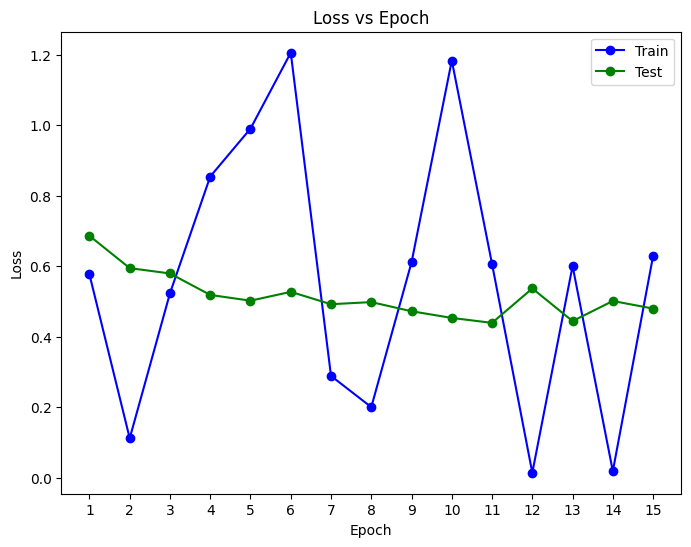

In [25]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [26]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.107847,0.218534,0.533167,0.699917,0.867795,0.919038,0.488848,0.628253
2,0.412375,0.318119,0.693283,0.857855,0.861172,0.851816,0.788104,0.847584
3,0.524369,0.489627,0.730921,0.711554,0.870002,0.896958,0.834572,0.869888
4,0.583823,0.640387,0.743398,0.684123,0.884229,0.905790,0.862454,0.847584
5,0.637401,0.621024,0.756498,0.779717,0.888398,0.871443,0.882900,0.903346
6,0.659869,0.526971,0.767311,0.826268,0.894285,0.887635,0.868959,0.710037
7,0.690287,0.710927,0.771054,0.778886,0.898455,0.842493,0.908922,0.936803
8,0.730038,0.674965,0.782699,0.738155,0.902870,0.915113,0.916357,0.743494
9,0.763913,0.639004,0.791433,0.770574,0.911209,0.914622,0.923792,0.918216


### Precision

In [27]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.388060,0.593985,0.627970,0.703425,0.628419,0.724005,0.670064,0.923497
2,0.576607,0.723270,0.706805,0.654407,0.770209,0.835419,0.824101,0.876923
3,0.642797,0.615652,0.754778,0.794063,0.799775,0.797209,0.859330,0.815331
4,0.693635,0.671988,0.773810,0.827136,0.816627,0.806466,0.885496,0.876923
5,0.721440,0.685496,0.793976,0.773289,0.829687,0.850168,0.893697,0.880435
6,0.733385,0.765060,0.799393,0.720290,0.839705,0.838276,0.908649,0.969543
7,0.759893,0.670143,0.814050,0.775662,0.842941,0.878261,0.924386,0.831683
8,0.779336,0.706223,0.826345,0.826816,0.855748,0.828153,0.926692,0.925926
9,0.800145,0.771285,0.841291,0.813158,0.865261,0.835874,0.938621,0.935606


### Recall

In [28]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.107847,0.218534,0.533167,0.699917,0.867795,0.919038,0.488848,0.628253
2,0.412375,0.318119,0.693283,0.857855,0.861172,0.851816,0.788104,0.847584
3,0.524369,0.489627,0.730921,0.711554,0.870002,0.896958,0.834572,0.869888
4,0.583823,0.640387,0.743398,0.684123,0.884229,0.905790,0.862454,0.847584
5,0.637401,0.621024,0.756498,0.779717,0.888398,0.871443,0.882900,0.903346
6,0.659869,0.526971,0.767311,0.826268,0.894285,0.887635,0.868959,0.710037
7,0.690287,0.710927,0.771054,0.778886,0.898455,0.842493,0.908922,0.936803
8,0.730038,0.674965,0.782699,0.738155,0.902870,0.915113,0.916357,0.743494
9,0.763913,0.639004,0.791433,0.770574,0.911209,0.914622,0.923792,0.918216


### F1-Score

In [29]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.168785,0.319515,0.576698,0.701667,0.728958,0.809946,0.565287,0.747788
2,0.480854,0.441883,0.699979,0.742446,0.813155,0.843537,0.805701,0.862004
3,0.577575,0.545455,0.742658,0.750548,0.833412,0.844147,0.846770,0.841727
4,0.634009,0.655807,0.758299,0.748863,0.849084,0.853247,0.873823,0.862004
5,0.676821,0.651669,0.774784,0.776490,0.858040,0.860674,0.888266,0.891743
6,0.694687,0.624079,0.783024,0.769648,0.866136,0.862250,0.888361,0.819743
7,0.723420,0.689933,0.791969,0.777271,0.869813,0.860005,0.916589,0.881119
8,0.753882,0.690240,0.803930,0.779974,0.878678,0.869464,0.921495,0.824742
9,0.781609,0.698941,0.815601,0.791293,0.887641,0.873477,0.931148,0.926829


### Gráfico ROC para cada clase

/tmp/ipykernel_75727/82169573.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


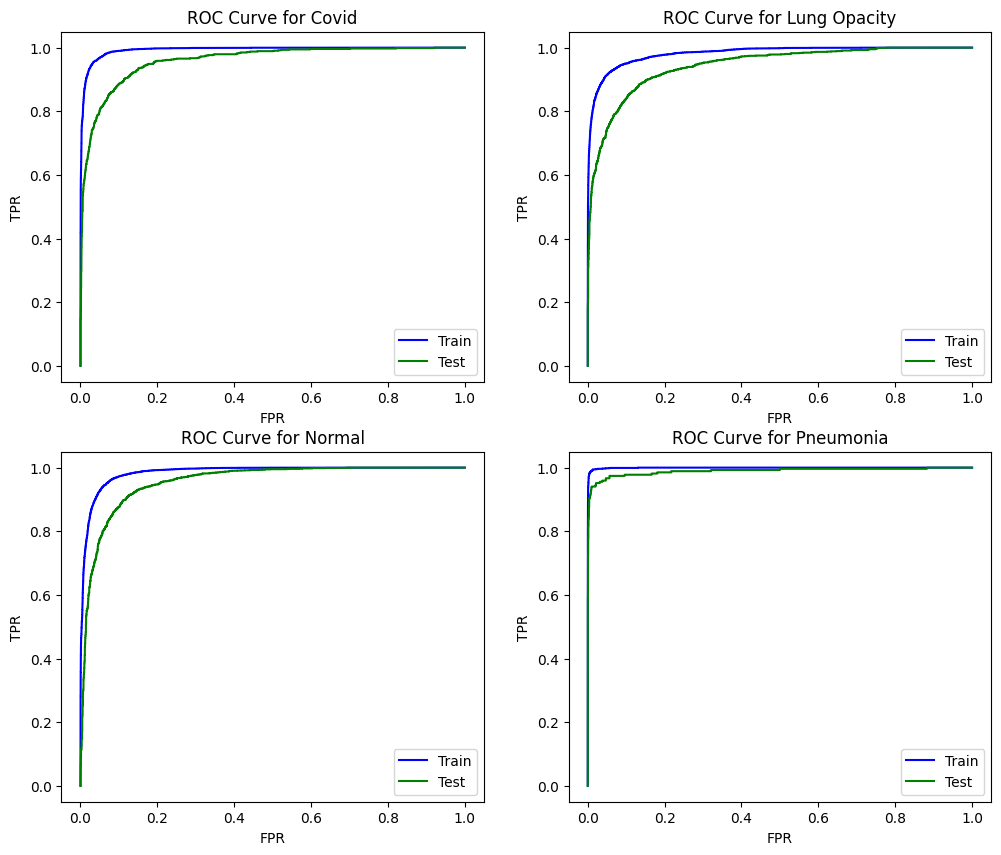

In [30]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Red Convolucional 
## Con Bilateral Filter

## Entrenamiento del modelo

In [77]:
batch_size = 32
learning_rate = 1e-2
momentum = 0.9
epochs = 15

bilateral_filtered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bilateral_filtered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

bilateral_filtered_train_dataloader = DataLoader(
    bilateral_filtered_train_dataset, batch_size=batch_size, shuffle=True)

bilateral_filtered_test_dataloader = DataLoader(
    bilateral_filtered_test_dataset, batch_size=batch_size, shuffle=True)

In [78]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(bilateral_filtered_train_dataloader, bilateral_filtered_cnn_model, loss_fn, optimizer)
    test_loss = test(bilateral_filtered_test_dataloader, bilateral_filtered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.398147  [   32/16932]
Current Loss: 1.308797  [  352/16932]
Current Loss: 1.344199  [  672/16932]
Current Loss: 1.185071  [  992/16932]
Current Loss: 1.187471  [ 1312/16932]
Current Loss: 1.211684  [ 1632/16932]
Current Loss: 1.182678  [ 1952/16932]
Current Loss: 1.184624  [ 2272/16932]
Current Loss: 1.185900  [ 2592/16932]
Current Loss: 1.291973  [ 2912/16932]
Current Loss: 1.144853  [ 3232/16932]
Current Loss: 1.141671  [ 3552/16932]
Current Loss: 1.348900  [ 3872/16932]
Current Loss: 1.145589  [ 4192/16932]
Current Loss: 1.179030  [ 4512/16932]
Current Loss: 1.251558  [ 4832/16932]
Current Loss: 1.305441  [ 5152/16932]
Current Loss: 1.132958  [ 5472/16932]
Current Loss: 1.159508  [ 5792/16932]
Current Loss: 1.200697  [ 6112/16932]
Current Loss: 1.184557  [ 6432/16932]
Current Loss: 1.177939  [ 6752/16932]
Current Loss: 1.187333  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.272476,0.733167,0.829244,0.576208


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.967041  [   32/16932]
Current Loss: 1.017586  [  352/16932]
Current Loss: 0.787626  [  672/16932]
Current Loss: 0.650077  [  992/16932]
Current Loss: 0.745067  [ 1312/16932]
Current Loss: 0.740460  [ 1632/16932]
Current Loss: 0.837150  [ 1952/16932]
Current Loss: 0.866618  [ 2272/16932]
Current Loss: 0.783407  [ 2592/16932]
Current Loss: 0.536005  [ 2912/16932]
Current Loss: 0.666843  [ 3232/16932]
Current Loss: 0.719470  [ 3552/16932]
Current Loss: 0.631306  [ 3872/16932]
Current Loss: 0.792142  [ 4192/16932]
Current Loss: 1.059444  [ 4512/16932]
Current Loss: 0.907620  [ 4832/16932]
Current Loss: 0.803345  [ 5152/16932]
Current Loss: 0.471605  [ 5472/16932]
Current Loss: 0.666189  [ 5792/16932]
Current Loss: 0.691574  [ 6112/16932]
Current Loss: 0.859200  [ 6432/16932]
Current Loss: 0.895710  [ 6752/16932]
Current Loss: 0.546703  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.744122,0.433084,0.758096,0.832714


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.704686  [   32/16932]
Current Loss: 0.773250  [  352/16932]
Current Loss: 0.787034  [  672/16932]
Current Loss: 0.894205  [  992/16932]
Current Loss: 0.837916  [ 1312/16932]
Current Loss: 0.517056  [ 1632/16932]
Current Loss: 0.641065  [ 1952/16932]
Current Loss: 0.832618  [ 2272/16932]
Current Loss: 0.497320  [ 2592/16932]
Current Loss: 0.679971  [ 2912/16932]
Current Loss: 0.605436  [ 3232/16932]
Current Loss: 0.454739  [ 3552/16932]
Current Loss: 0.599408  [ 3872/16932]
Current Loss: 0.459152  [ 4192/16932]
Current Loss: 0.705922  [ 4512/16932]
Current Loss: 0.723272  [ 4832/16932]
Current Loss: 1.017137  [ 5152/16932]
Current Loss: 0.582993  [ 5472/16932]
Current Loss: 0.715201  [ 5792/16932]
Current Loss: 0.511149  [ 6112/16932]
Current Loss: 0.680506  [ 6432/16932]
Current Loss: 0.608842  [ 6752/16932]
Current Loss: 0.662770  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.607192,0.640898,0.902846,0.773234


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.591071  [   32/16932]
Current Loss: 0.535821  [  352/16932]
Current Loss: 0.471187  [  672/16932]
Current Loss: 0.728892  [  992/16932]
Current Loss: 0.600168  [ 1312/16932]
Current Loss: 0.626377  [ 1632/16932]
Current Loss: 0.478148  [ 1952/16932]
Current Loss: 0.748993  [ 2272/16932]
Current Loss: 0.446300  [ 2592/16932]
Current Loss: 0.423018  [ 2912/16932]
Current Loss: 0.544031  [ 3232/16932]
Current Loss: 0.552630  [ 3552/16932]
Current Loss: 0.613690  [ 3872/16932]
Current Loss: 0.591474  [ 4192/16932]
Current Loss: 0.638693  [ 4512/16932]
Current Loss: 0.633925  [ 4832/16932]
Current Loss: 0.272349  [ 5152/16932]
Current Loss: 0.356592  [ 5472/16932]
Current Loss: 0.520277  [ 5792/16932]
Current Loss: 0.463333  [ 6112/16932]
Current Loss: 0.574505  [ 6432/16932]
Current Loss: 0.491285  [ 6752/16932]
Current Loss: 0.560609  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.520055,0.802161,0.866536,0.892193


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.456206  [   32/16932]
Current Loss: 0.408294  [  352/16932]
Current Loss: 0.705764  [  672/16932]
Current Loss: 0.531612  [  992/16932]
Current Loss: 0.765157  [ 1312/16932]
Current Loss: 0.324271  [ 1632/16932]
Current Loss: 0.448204  [ 1952/16932]
Current Loss: 0.365237  [ 2272/16932]
Current Loss: 0.336627  [ 2592/16932]
Current Loss: 0.351731  [ 2912/16932]
Current Loss: 0.477917  [ 3232/16932]
Current Loss: 0.442241  [ 3552/16932]
Current Loss: 0.577857  [ 3872/16932]
Current Loss: 0.470118  [ 4192/16932]
Current Loss: 0.552549  [ 4512/16932]
Current Loss: 0.488642  [ 4832/16932]
Current Loss: 0.567742  [ 5152/16932]
Current Loss: 0.350742  [ 5472/16932]
Current Loss: 0.522229  [ 5792/16932]
Current Loss: 0.842777  [ 6112/16932]
Current Loss: 0.642667  [ 6432/16932]
Current Loss: 0.370859  [ 6752/16932]
Current Loss: 0.202214  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.61964,0.77473,0.916585,0.892193


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.519542  [   32/16932]
Current Loss: 0.630812  [  352/16932]
Current Loss: 0.248202  [  672/16932]
Current Loss: 0.529420  [  992/16932]
Current Loss: 0.663853  [ 1312/16932]
Current Loss: 0.479519  [ 1632/16932]
Current Loss: 0.387383  [ 1952/16932]
Current Loss: 0.408262  [ 2272/16932]
Current Loss: 0.362100  [ 2592/16932]
Current Loss: 0.447752  [ 2912/16932]
Current Loss: 0.658698  [ 3232/16932]
Current Loss: 0.460200  [ 3552/16932]
Current Loss: 0.478902  [ 3872/16932]
Current Loss: 0.511824  [ 4192/16932]
Current Loss: 0.511608  [ 4512/16932]
Current Loss: 0.301445  [ 4832/16932]
Current Loss: 0.394866  [ 5152/16932]
Current Loss: 0.432402  [ 5472/16932]
Current Loss: 0.496211  [ 5792/16932]
Current Loss: 0.512166  [ 6112/16932]
Current Loss: 0.311344  [ 6432/16932]
Current Loss: 0.429455  [ 6752/16932]
Current Loss: 0.642883  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.598894,0.778055,0.865554,0.855019


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.348594  [   32/16932]
Current Loss: 0.446604  [  352/16932]
Current Loss: 0.468693  [  672/16932]
Current Loss: 0.404936  [  992/16932]
Current Loss: 0.318257  [ 1312/16932]
Current Loss: 0.659271  [ 1632/16932]
Current Loss: 0.356620  [ 1952/16932]
Current Loss: 0.383522  [ 2272/16932]
Current Loss: 0.325468  [ 2592/16932]
Current Loss: 0.837350  [ 2912/16932]
Current Loss: 0.330518  [ 3232/16932]
Current Loss: 0.299485  [ 3552/16932]
Current Loss: 0.598716  [ 3872/16932]
Current Loss: 0.630289  [ 4192/16932]
Current Loss: 0.379169  [ 4512/16932]
Current Loss: 0.562922  [ 4832/16932]
Current Loss: 0.681434  [ 5152/16932]
Current Loss: 0.812249  [ 5472/16932]
Current Loss: 0.467896  [ 5792/16932]
Current Loss: 0.352565  [ 6112/16932]
Current Loss: 0.342617  [ 6432/16932]
Current Loss: 0.382484  [ 6752/16932]
Current Loss: 0.276432  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.677732,0.75478,0.823356,0.728625


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.332116  [   32/16932]
Current Loss: 0.371684  [  352/16932]
Current Loss: 0.406434  [  672/16932]
Current Loss: 0.619977  [  992/16932]
Current Loss: 0.246874  [ 1312/16932]
Current Loss: 0.509131  [ 1632/16932]
Current Loss: 0.418515  [ 1952/16932]
Current Loss: 0.392081  [ 2272/16932]
Current Loss: 0.580900  [ 2592/16932]
Current Loss: 0.252069  [ 2912/16932]
Current Loss: 0.479184  [ 3232/16932]
Current Loss: 0.559994  [ 3552/16932]
Current Loss: 0.326472  [ 3872/16932]
Current Loss: 0.219262  [ 4192/16932]
Current Loss: 0.348389  [ 4512/16932]
Current Loss: 0.349499  [ 4832/16932]
Current Loss: 0.289704  [ 5152/16932]
Current Loss: 0.311701  [ 5472/16932]
Current Loss: 0.129381  [ 5792/16932]
Current Loss: 0.777848  [ 6112/16932]
Current Loss: 0.227815  [ 6432/16932]
Current Loss: 0.297445  [ 6752/16932]
Current Loss: 0.352716  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.717842,0.724855,0.90579,0.825279


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.485695  [   32/16932]
Current Loss: 0.158333  [  352/16932]
Current Loss: 0.403152  [  672/16932]
Current Loss: 0.505224  [  992/16932]
Current Loss: 0.372939  [ 1312/16932]
Current Loss: 0.469914  [ 1632/16932]
Current Loss: 0.408331  [ 1952/16932]
Current Loss: 0.445698  [ 2272/16932]
Current Loss: 0.319139  [ 2592/16932]
Current Loss: 0.174722  [ 2912/16932]
Current Loss: 0.254037  [ 3232/16932]
Current Loss: 0.218296  [ 3552/16932]
Current Loss: 0.495616  [ 3872/16932]
Current Loss: 0.278834  [ 4192/16932]
Current Loss: 0.327396  [ 4512/16932]
Current Loss: 0.431489  [ 4832/16932]
Current Loss: 0.512412  [ 5152/16932]
Current Loss: 0.295274  [ 5472/16932]
Current Loss: 0.254049  [ 5792/16932]
Current Loss: 0.346935  [ 6112/16932]
Current Loss: 0.293244  [ 6432/16932]
Current Loss: 0.424894  [ 6752/16932]
Current Loss: 0.221986  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.647303,0.795511,0.89107,0.892193


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.325100  [   32/16932]
Current Loss: 0.569780  [  352/16932]
Current Loss: 0.166983  [  672/16932]
Current Loss: 0.314402  [  992/16932]
Current Loss: 0.426260  [ 1312/16932]
Current Loss: 0.142995  [ 1632/16932]
Current Loss: 0.237698  [ 1952/16932]
Current Loss: 0.098792  [ 2272/16932]
Current Loss: 0.347065  [ 2592/16932]
Current Loss: 0.298025  [ 2912/16932]
Current Loss: 0.177779  [ 3232/16932]
Current Loss: 0.291517  [ 3552/16932]
Current Loss: 0.527220  [ 3872/16932]
Current Loss: 0.370409  [ 4192/16932]
Current Loss: 0.250627  [ 4512/16932]
Current Loss: 0.289771  [ 4832/16932]
Current Loss: 0.146067  [ 5152/16932]
Current Loss: 0.311812  [ 5472/16932]
Current Loss: 0.179965  [ 5792/16932]
Current Loss: 0.436475  [ 6112/16932]
Current Loss: 0.528533  [ 6432/16932]
Current Loss: 0.379623  [ 6752/16932]
Current Loss: 0.272435  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.6639,0.748961,0.928852,0.810409


--------------------------- Epoch 11 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.290397  [   32/16932]
Current Loss: 0.213446  [  352/16932]
Current Loss: 0.284699  [  672/16932]
Current Loss: 0.448527  [  992/16932]
Current Loss: 0.173970  [ 1312/16932]
Current Loss: 0.199556  [ 1632/16932]
Current Loss: 0.139247  [ 1952/16932]
Current Loss: 0.269632  [ 2272/16932]
Current Loss: 0.223394  [ 2592/16932]
Current Loss: 0.076708  [ 2912/16932]
Current Loss: 0.303630  [ 3232/16932]
Current Loss: 0.241977  [ 3552/16932]
Current Loss: 0.427174  [ 3872/16932]
Current Loss: 0.148741  [ 4192/16932]
Current Loss: 0.130398  [ 4512/16932]
Current Loss: 0.421545  [ 4832/16932]
Current Loss: 0.130988  [ 5152/16932]
Current Loss: 0.338206  [ 5472/16932]
Current Loss: 0.386304  [ 5792/16932]
Current Loss: 0.363997  [ 6112/16932]
Current Loss: 0.218952  [ 6432/16932]
Current Loss: 0.321760  [ 6752/16932]
Current Loss: 0.222211  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.590595,0.806318,0.900393,0.810409


--------------------------- Epoch 12 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.117798  [   32/16932]
Current Loss: 0.124221  [  352/16932]
Current Loss: 0.122705  [  672/16932]
Current Loss: 0.275811  [  992/16932]
Current Loss: 0.226205  [ 1312/16932]
Current Loss: 0.188348  [ 1632/16932]
Current Loss: 0.364605  [ 1952/16932]
Current Loss: 0.055868  [ 2272/16932]
Current Loss: 0.236405  [ 2592/16932]
Current Loss: 0.149035  [ 2912/16932]
Current Loss: 0.135478  [ 3232/16932]
Current Loss: 0.262787  [ 3552/16932]
Current Loss: 0.244749  [ 3872/16932]
Current Loss: 0.223258  [ 4192/16932]
Current Loss: 0.096832  [ 4512/16932]
Current Loss: 0.484515  [ 4832/16932]
Current Loss: 0.400226  [ 5152/16932]
Current Loss: 0.376837  [ 5472/16932]
Current Loss: 0.353258  [ 5792/16932]
Current Loss: 0.059513  [ 6112/16932]
Current Loss: 0.320141  [ 6432/16932]
Current Loss: 0.243223  [ 6752/16932]
Current Loss: 0.186198  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.578147,0.803824,0.899411,0.884758


--------------------------- Epoch 13 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.363278  [   32/16932]
Current Loss: 0.148064  [  352/16932]
Current Loss: 0.073767  [  672/16932]
Current Loss: 0.223879  [  992/16932]
Current Loss: 0.234408  [ 1312/16932]
Current Loss: 0.200366  [ 1632/16932]
Current Loss: 0.387590  [ 1952/16932]
Current Loss: 0.105829  [ 2272/16932]
Current Loss: 0.120030  [ 2592/16932]
Current Loss: 0.318280  [ 2912/16932]
Current Loss: 0.280591  [ 3232/16932]
Current Loss: 0.472715  [ 3552/16932]
Current Loss: 0.047584  [ 3872/16932]
Current Loss: 0.177176  [ 4192/16932]
Current Loss: 0.060614  [ 4512/16932]
Current Loss: 0.171118  [ 4832/16932]
Current Loss: 0.377942  [ 5152/16932]
Current Loss: 0.166859  [ 5472/16932]
Current Loss: 0.148411  [ 5792/16932]
Current Loss: 0.061867  [ 6112/16932]
Current Loss: 0.078008  [ 6432/16932]
Current Loss: 0.035858  [ 6752/16932]
Current Loss: 0.125631  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.716459,0.818786,0.870952,0.862454


--------------------------- Epoch 14 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.137696  [   32/16932]
Current Loss: 0.291181  [  352/16932]
Current Loss: 0.156018  [  672/16932]
Current Loss: 0.205756  [  992/16932]
Current Loss: 0.165105  [ 1312/16932]
Current Loss: 0.083490  [ 1632/16932]
Current Loss: 0.142010  [ 1952/16932]
Current Loss: 0.031499  [ 2272/16932]
Current Loss: 0.242225  [ 2592/16932]
Current Loss: 0.213753  [ 2912/16932]
Current Loss: 0.040359  [ 3232/16932]
Current Loss: 0.094368  [ 3552/16932]
Current Loss: 0.067011  [ 3872/16932]
Current Loss: 0.076829  [ 4192/16932]
Current Loss: 0.065862  [ 4512/16932]
Current Loss: 0.119741  [ 4832/16932]
Current Loss: 0.236078  [ 5152/16932]
Current Loss: 0.419701  [ 5472/16932]
Current Loss: 0.059254  [ 5792/16932]
Current Loss: 0.065269  [ 6112/16932]
Current Loss: 0.149378  [ 6432/16932]
Current Loss: 0.212934  [ 6752/16932]
Current Loss: 0.154934  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.670816,0.750623,0.91315,0.769517


--------------------------- Epoch 15 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.262114  [   32/16932]
Current Loss: 0.137078  [  352/16932]
Current Loss: 0.124747  [  672/16932]
Current Loss: 0.212537  [  992/16932]
Current Loss: 0.074228  [ 1312/16932]
Current Loss: 0.060649  [ 1632/16932]
Current Loss: 0.165187  [ 1952/16932]
Current Loss: 0.089201  [ 2272/16932]
Current Loss: 0.043823  [ 2592/16932]
Current Loss: 0.129253  [ 2912/16932]
Current Loss: 0.245009  [ 3232/16932]
Current Loss: 0.266391  [ 3552/16932]
Current Loss: 0.045363  [ 3872/16932]
Current Loss: 0.162813  [ 4192/16932]
Current Loss: 0.116038  [ 4512/16932]
Current Loss: 0.073349  [ 4832/16932]
Current Loss: 0.039103  [ 5152/16932]
Current Loss: 0.194130  [ 5472/16932]
Current Loss: 0.065790  [ 5792/16932]
Current Loss: 0.106799  [ 6112/16932]
Current Loss: 0.058737  [ 6432/16932]
Current Loss: 0.029945  [ 6752/16932]
Current Loss: 0.268111  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.589212,0.779717,0.895976,0.910781


Training time: 74.745 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_67245/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


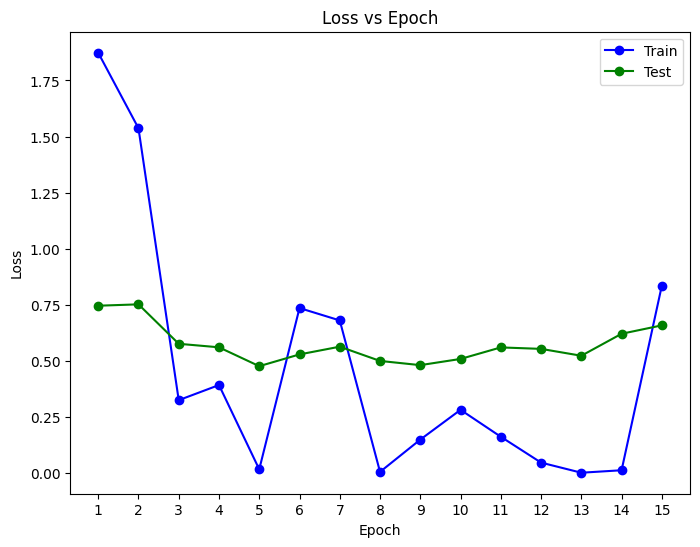

In [79]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [80]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Accuracy,Lung-Opacity Test Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.036640,0.272476,0.367852,0.733167,0.896860,0.829244,0.329926,0.576208
2,0.296578,0.744122,0.691620,0.433084,0.845352,0.758096,0.769517,0.832714
3,0.493951,0.607192,0.706384,0.640898,0.861540,0.902846,0.811338,0.773234
4,0.585551,0.520055,0.735912,0.802161,0.875889,0.866536,0.847584,0.892193
5,0.648807,0.619640,0.755459,0.774730,0.884106,0.916585,0.885688,0.892193
6,0.681991,0.598894,0.757538,0.778055,0.889625,0.865554,0.887546,0.855019
7,0.716903,0.677732,0.781244,0.754780,0.896002,0.823356,0.881970,0.728625
8,0.751123,0.717842,0.792888,0.724855,0.905568,0.905790,0.917286,0.825279
9,0.789146,0.647303,0.823456,0.795511,0.916115,0.891070,0.935874,0.892193


### Precision

In [81]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Precision,Lung-Opacity Test Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.333333,0.420940,0.572492,0.640988,0.562409,0.764706,0.681382,0.865922
2,0.519056,0.365738,0.658614,0.837621,0.751772,0.826645,0.781132,0.826568
3,0.599413,0.613128,0.729126,0.817603,0.793158,0.783646,0.845930,0.920354
4,0.668772,0.761134,0.766349,0.724474,0.816789,0.828719,0.879460,0.869565
5,0.721091,0.792920,0.788240,0.815398,0.832833,0.832813,0.895677,0.851064
6,0.729390,0.684044,0.799254,0.757282,0.841141,0.833648,0.913876,0.927419
7,0.755005,0.586826,0.814967,0.780069,0.856105,0.830282,0.911623,0.920188
8,0.790469,0.706122,0.830719,0.852395,0.865245,0.823739,0.932011,0.948718
9,0.825380,0.795918,0.851979,0.770531,0.884338,0.850984,0.940243,0.892193


### Recall

In [82]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Recall,Lung-Opacity Test Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.036640,0.272476,0.367852,0.733167,0.896860,0.829244,0.329926,0.576208
2,0.296578,0.744122,0.691620,0.433084,0.845352,0.758096,0.769517,0.832714
3,0.493951,0.607192,0.706384,0.640898,0.861540,0.902846,0.811338,0.773234
4,0.585551,0.520055,0.735912,0.802161,0.875889,0.866536,0.847584,0.892193
5,0.648807,0.619640,0.755459,0.774730,0.884106,0.916585,0.885688,0.892193
6,0.681991,0.598894,0.757538,0.778055,0.889625,0.865554,0.887546,0.855019
7,0.716903,0.677732,0.781244,0.754780,0.896002,0.823356,0.881970,0.728625
8,0.751123,0.717842,0.792888,0.724855,0.905568,0.905790,0.917286,0.825279
9,0.789146,0.647303,0.823456,0.795511,0.916115,0.891070,0.935874,0.892193


### F1-Score

In [83]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train F1-Score,Lung-Opacity Test F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.066023,0.330814,0.447905,0.683986,0.691308,0.795669,0.444584,0.691964
2,0.377475,0.490428,0.674713,0.570959,0.795821,0.790888,0.775281,0.829630
3,0.541596,0.610146,0.717575,0.718546,0.825936,0.839033,0.828273,0.840404
4,0.624401,0.617913,0.750822,0.761341,0.845307,0.847206,0.863228,0.880734
5,0.683042,0.695652,0.771501,0.794544,0.857704,0.872693,0.890654,0.871143
6,0.704895,0.638643,0.777837,0.767528,0.864704,0.849302,0.900519,0.889749
7,0.735461,0.629012,0.797749,0.767216,0.875599,0.826805,0.896552,0.813278
8,0.770294,0.711934,0.811363,0.783468,0.884947,0.862818,0.924590,0.882704
9,0.806856,0.713959,0.837475,0.782822,0.899946,0.870566,0.938053,0.892193


### Gráfico ROC para cada clase

/tmp/ipykernel_67245/82169573.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


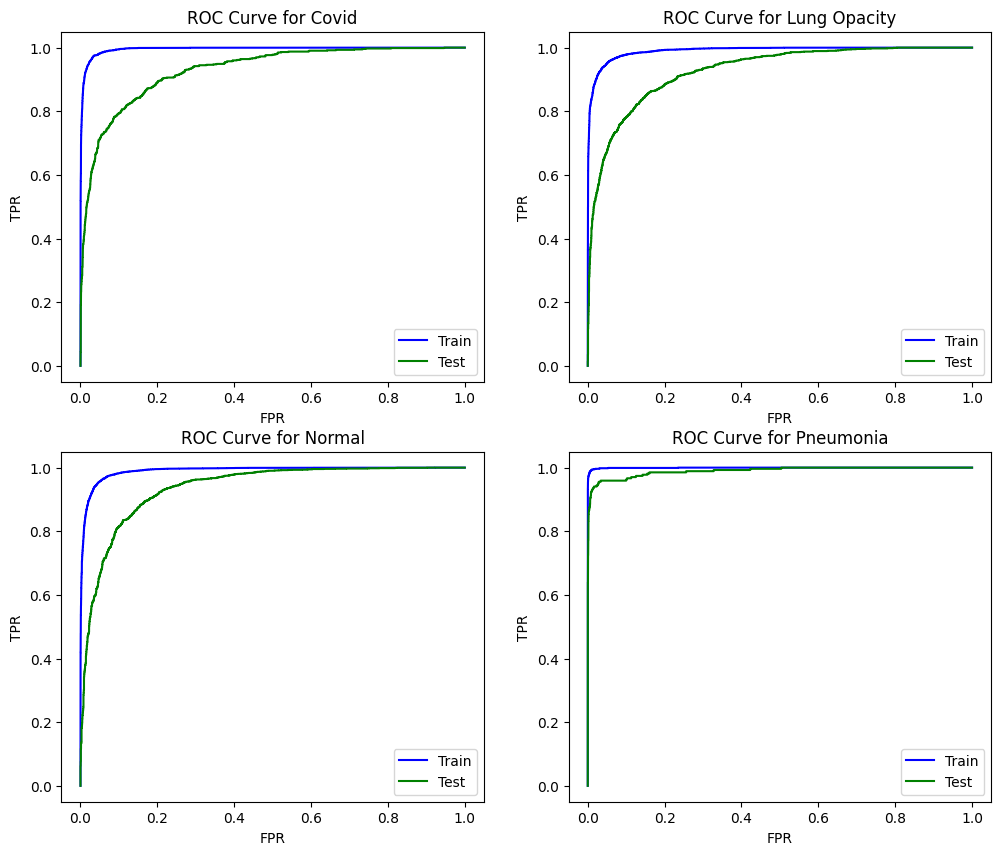

In [84]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Saliency Maps

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x841 and 13456x512)

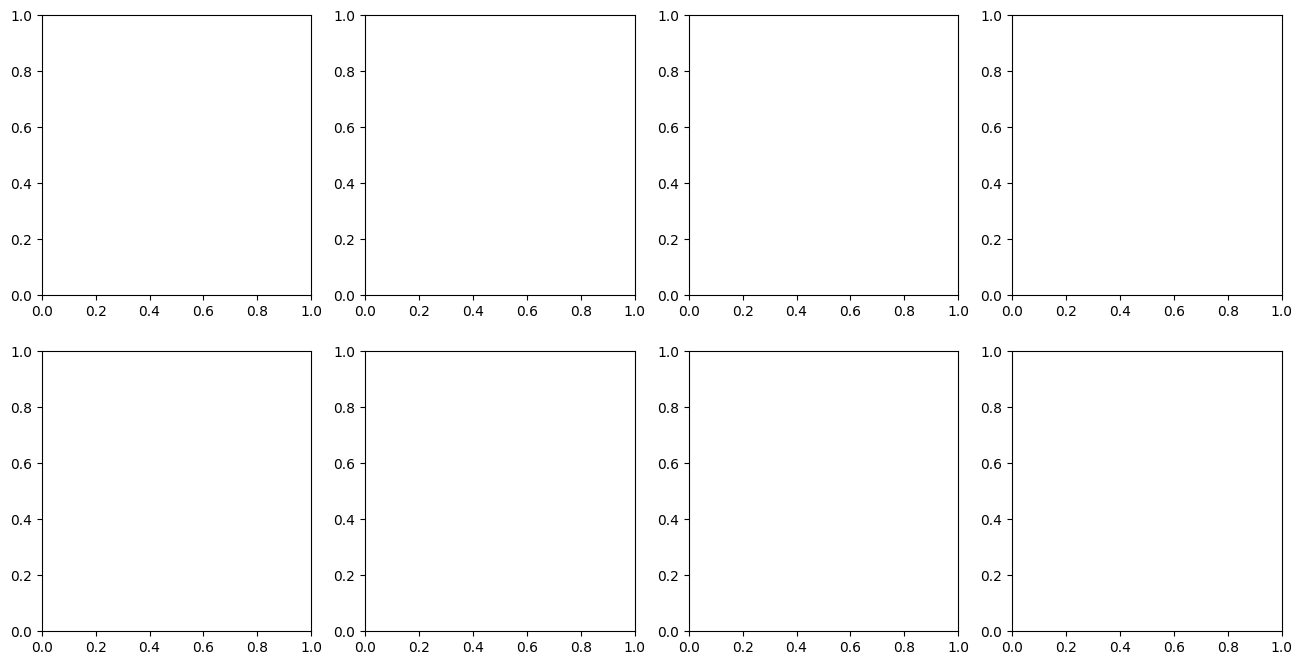

In [31]:
unfiltered_cnn_model.eval()

X_test = next(iter(unfiltered_test_dataloader))

num_samples = 4

fig, ax = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    current_sample = X_test[0][i]
    
    current_sample.requires_grad_()

    scores = unfiltered_cnn_model(current_sample)

    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index.item()]

    score_max.backward()

    X_test_grad = current_sample.grad.abs()

    X_test_grad = X_test_grad.detach().numpy()

    ax[0, i].imshow(current_sample[0].detach().numpy())
    ax[0, i].axis('off')

    img = ax[1, i].imshow(X_test_grad[0], cmap=plt.cm.hot)
    ax[1, i].axis('off')

plt.show()

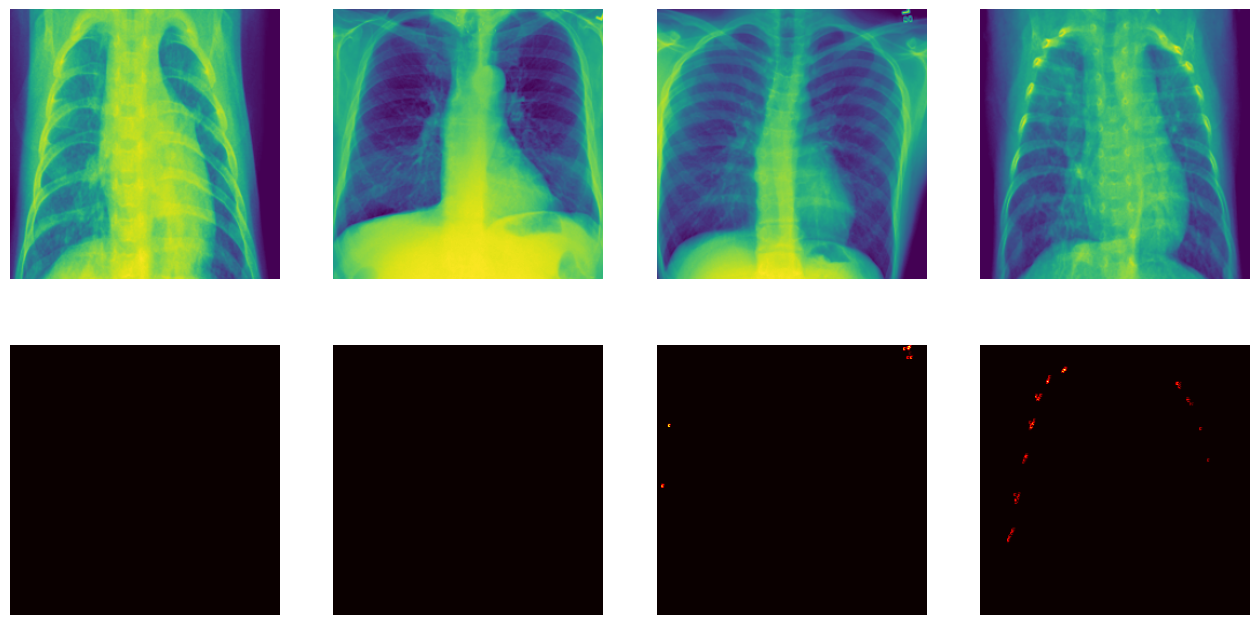

In [ ]:
model.eval()

X_test = next(iter(test_dataloader))

num_samples = 4

fig, ax = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    current_sample = X_test[0][i]
    
    current_sample.requires_grad_()

    scores = model(current_sample)

    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index.item()]

    score_max.backward()

    X_test_grad = current_sample.grad.abs()

    X_test_grad = X_test_grad.detach().numpy()

    ax[0, i].imshow(current_sample[0].detach().numpy())
    ax[0, i].axis('off')

    img = ax[1, i].imshow(X_test_grad[0], cmap=plt.cm.hot)
    ax[1, i].axis('off')

plt.show()